In [ ]:
# This R environment comes with many helpful analytics packages installed
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "covid-19-state-statistics-as-of-12062020"        
[2] "crpe-covid-state-response-database"              
[3] "device-internet-availability"                    
[4] "kids-first-state-health-data"                    
[5] "learnplatform-covid19-impact-on-digital-learning"
[6] "selected-data-from-covid-state-policy-database"  
[7] "state-trends-in-childhood-well-being"

# EDA

### A little exploration of the data, including:

* Districts distribution and demography
* Top digital learning products by engagement
* Engangement in top products across 2020 in different demographies.

In [ ]:
library(tidyverse)
library(janitor)
library(here)
library(scico)
library(usmap)
library(viridis)
library(patchwork)
library(skimr)
library(DataExplorer)
library(lubridate)
library(ggthemes)
library(corrplot)
theme_set(theme_minimal())


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


here() starts at /kaggle/working

Loading required package: viridisLite


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


corrplot 0.88 loaded



In [ ]:
input_path <- here("../input", "learnplatform-covid19-impact-on-digital-learning")

In [ ]:
#reformatting variables
reformat_col <- function(pct) {
        out <- pct %>% 
                str_split(",") %>% 
                map(str_remove, "\\[") %>% 
                map(function(x) paste(as.numeric(x) * 100, collapse = "-")) %>% 
                unlist() 
        # making NAs proper NAs
        out[out == "NA"] <- NA
        out
}

## Districts

In [ ]:
districts <- read_csv(here(input_path, "districts_info.csv"), na = c("", "NaN")) %>% 
        clean_names() %>% 
        mutate(across(starts_with("pct"), ~ reformat_col(.x)),
               pp_total_raw = str_remove_all(pp_total_raw, "\\["),
               pp_total_raw = str_replace(pp_total_raw, ", ", "-"))
districts <-districts %>% clean_names()
districts[1:10,]

Rows: 233 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): state, locale, pct_black/hispanic, pct_free/reduced, county_connect...
dbl (1): district_id


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



district_id state          locale pct_black_hispanic pct_free_reduced
1  8815        Illinois       Suburb 0-20               0-20            
2  2685        NA             NA     NA                 NA              
3  4921        Utah           Suburb 0-20               20-40           
4  3188        NA             NA     NA                 NA              
5  2238        NA             NA     NA                 NA              
6  5987        Wisconsin      Suburb 0-20               0-20            
7  3710        Utah           Suburb 0-20               40-60           
8  7177        North Carolina Suburb 20-40              20-40           
9  9812        Utah           Suburb 0-20               20-40           
10 6584        North Carolina Rural  40-60              60-80           
   county_connections_ratio pp_total_raw
1  [0.18, 1[                14000-16000 
2  NA                       NA          
3  [0.18, 1[                6000-8000   
4  NA                       NA          
5  NA                       NA          
6  [0.18, 1[                10000-12000 
7  [0.18, 1[                6000-8000   
8  [0.18, 1[                8000-10000  
9  [0.18, 1[                6000-8000   
10 [0.18, 1[                8000-10000

### Distriction Information

In [ ]:
p1 <- districts %>% 
        filter(!is.na(pct_black_hispanic)) %>% 
        mutate(pct_black_hispanic = fct_rev(pct_black_hispanic)) %>% 
        ggplot(aes(locale, fill = pct_black_hispanic)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "% black/\nhispanic") 
p2 <- districts %>% 
        filter(!is.na(pct_free_reduced)) %>% 
        mutate(pct_free_reduced = fct_rev(pct_free_reduced)) %>% 
        ggplot(aes(locale, fill =pct_free_reduced)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "% free/\nreduced lunch") 
p3 <- districts %>% 
        filter(!is.na(pp_total_raw)) %>% 
        mutate(pp_total_raw2 = as.numeric(str_extract(pp_total_raw, "^[^-]*[^ -]"))) %>% 
        mutate(pp_total_raw = fct_reorder(pp_total_raw, -pp_total_raw2)) %>% 
        ggplot(aes(locale, fill = pp_total_raw)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "Per-pupil\nexpenditure", direction = 1)

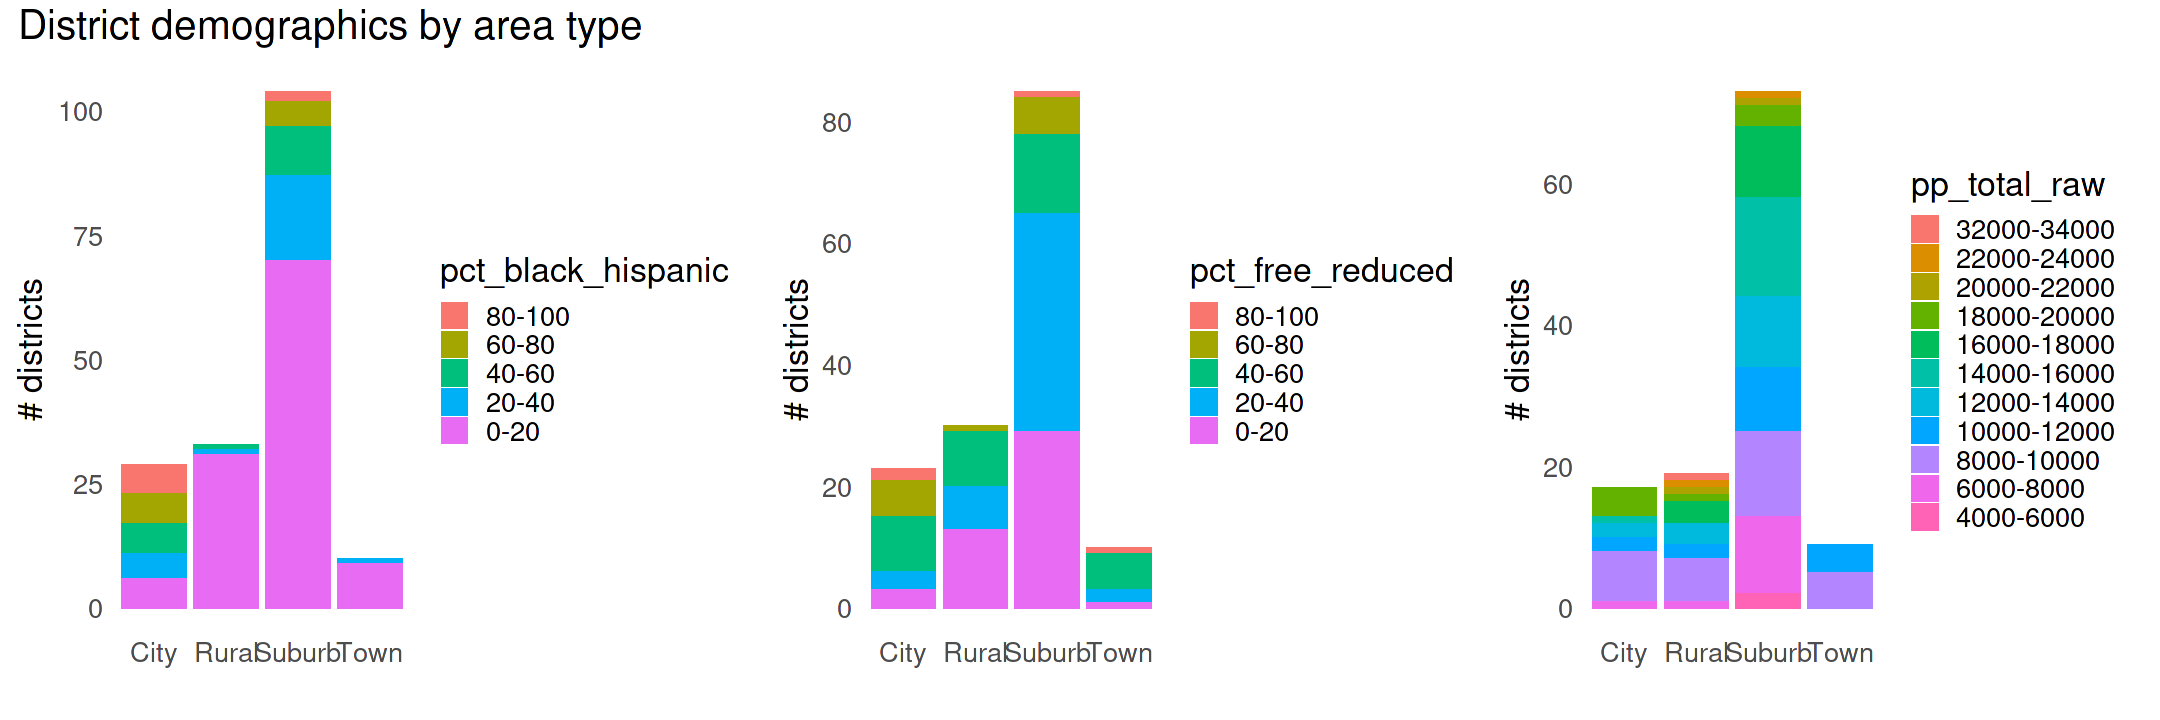

In [ ]:
options(repr.plot.width = 18, repr.plot.height = 6)
p1 + p2 + p3 +
        plot_annotation(title = 'District demographics by area type') & 
        theme(text = element_text('Lato', size = 20),
              panel.grid = element_blank()) &
        ylab("# districts") &
        xlab("")

Demographic data show that the different area types differ substantially in their proportion of blacks/hispanics and in their proportion of pupils eligible for free or reduced lunch. No very obvious patterns emerge for expenditure per pupil from this barchart.

## Products

The digital learning products are categorized in various ways. Here, we split them in their main-function and sub-function.

Main function of primary categories are:

LC = Learning & Curriculum
CM = Classroom Management,
SDO = School & District Operations

In [ ]:
products <- read_csv(here(input_path, "products_info.csv")) %>% 
                clean_names() %>% 
                separate(primary_essential_function, c("main_fun", "sub_fun"),
                         sep = " - ", extra = "merge")
products <- products %>% clean_names()
products[1:10, ]

Rows: 372 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): URL, Product Name, Provider/Company Name, Sector(s), Primary Essent...
dbl (1): LP ID


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



lp_id url                           product_name   provider_company_name  
1  13117 https://www.splashmath.com    SplashLearn    StudyPad Inc.          
2  66933 https://abcmouse.com          ABCmouse.com   Age of Learning, Inc   
3  50479 https://www.abcya.com         ABCya!         ABCya.com, LLC         
4  92993 http://www.aleks.com/         ALEKS          McGraw-Hill PreK-12    
5  73104 https://www.achieve3000.com/  Achieve3000    Achieve3000            
6  37600 http://www.activelylearn.com/ Actively Learn Actively Learn         
7  18663 http://www.adaptedmind.com    AdaptedMind    GloWorld               
8  65131 http://www.amplify.com/       Amplify        Amplify Education, Inc.
9  26491 http://www.answers.com/       Answers        Answers                
10 56441 http://www.audible.com        Audible        Amazon.com, Inc.       
   sector_s                      main_fun
1  PreK-12                       LC      
2  PreK-12                       LC      
3  PreK-12                       LC      
4  PreK-12; Higher Ed            LC      
5  PreK-12                       LC      
6  PreK-12                       LC      
7  PreK-12                       LC      
8  PreK-12                       LC      
9  PreK-12; Higher Ed            LC      
10 PreK-12; Higher Ed; Corporate LC      
   sub_fun                                           
1  Digital Learning Platforms                        
2  Digital Learning Platforms                        
3  Sites, Resources & Reference - Games & Simulations
4  Digital Learning Platforms                        
5  Digital Learning Platforms                        
6  Digital Learning Platforms                        
7  Digital Learning Platforms                        
8  Courseware & Textbooks                            
9  Study Tools - Q&A                                 
10 Sites, Resources & Reference - Streaming Services

# Data structure

In [ ]:
library(skimr)
skim(districts)

── Data Summary ────────────────────────
                           Values   
Name                       districts
Number of rows             233      
Number of columns          7        
_______________________             
Column type frequency:              
  character                6        
  numeric                  1        
________________________            
Group variables            None     

── Variable type: character ────────────────────────────────────────────────────
  skim_variable            n_missing complete_rate   min   max empty n_unique
1 state                           57         0.755     4    20     0       23
2 locale                          57         0.755     4     6     0        4
3 pct_black_hispanic              57         0.755     4     6     0        5
4 pct_free_reduced                85         0.635     4     6     0        5
5 county_connections_ratio        71         0.695     6     9     0        2
6 pp_total_raw                   115   

In [ ]:
skim(products)

── Data Summary ────────────────────────
                           Values  
Name                       products
Number of rows             372     
Number of columns          7       
_______________________            
Column type frequency:             
  character                6       
  numeric                  1       
________________________           
Group variables            None    

── Variable type: character ────────────────────────────────────────────────────
  skim_variable         n_missing complete_rate   min   max empty n_unique
1 url                           0         1        14   101     0      372
2 product_name                  0         1         2    45     0      372
3 provider_company_name         1         0.997     3    55     0      290
4 sector_s                     20         0.946     7    29     0        5
5 main_fun                     20         0.946     2     9     0        4
6 sub_fun                      20         0.946     5    68     0  

Both data sets contains missing values.
We plot the missing values proportion in each column to know the better picture.

# Missing values

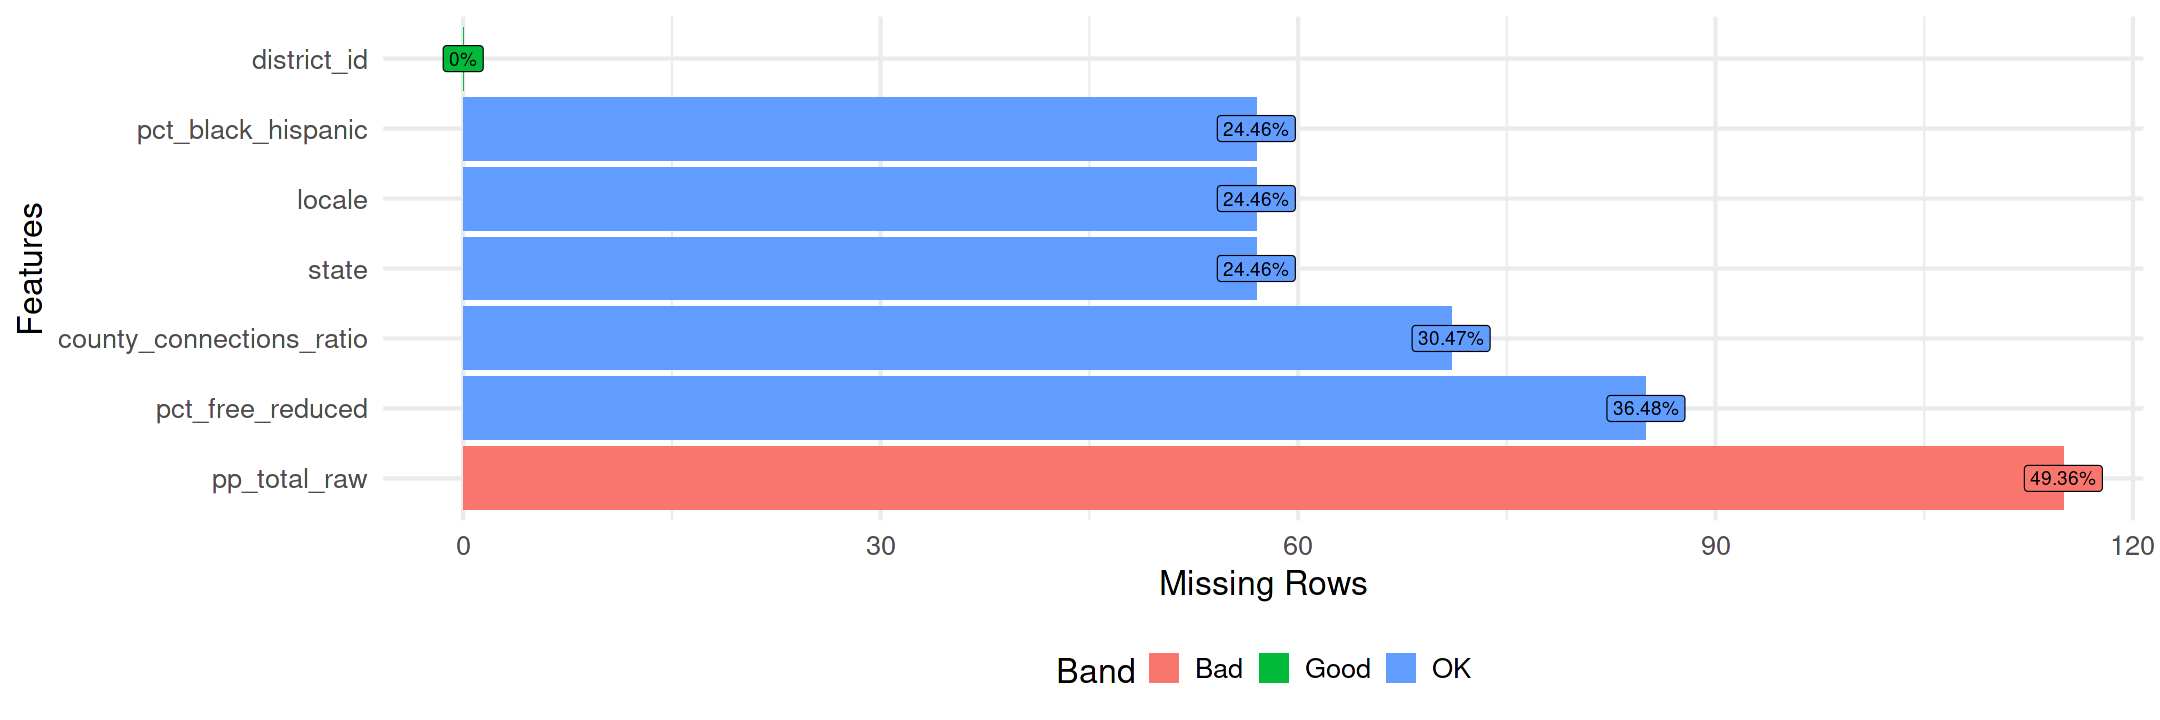

In [ ]:
library(DataExplorer)
library(lubridate)
plot_missing(districts, ggtheme = theme_minimal(base_size = 20))

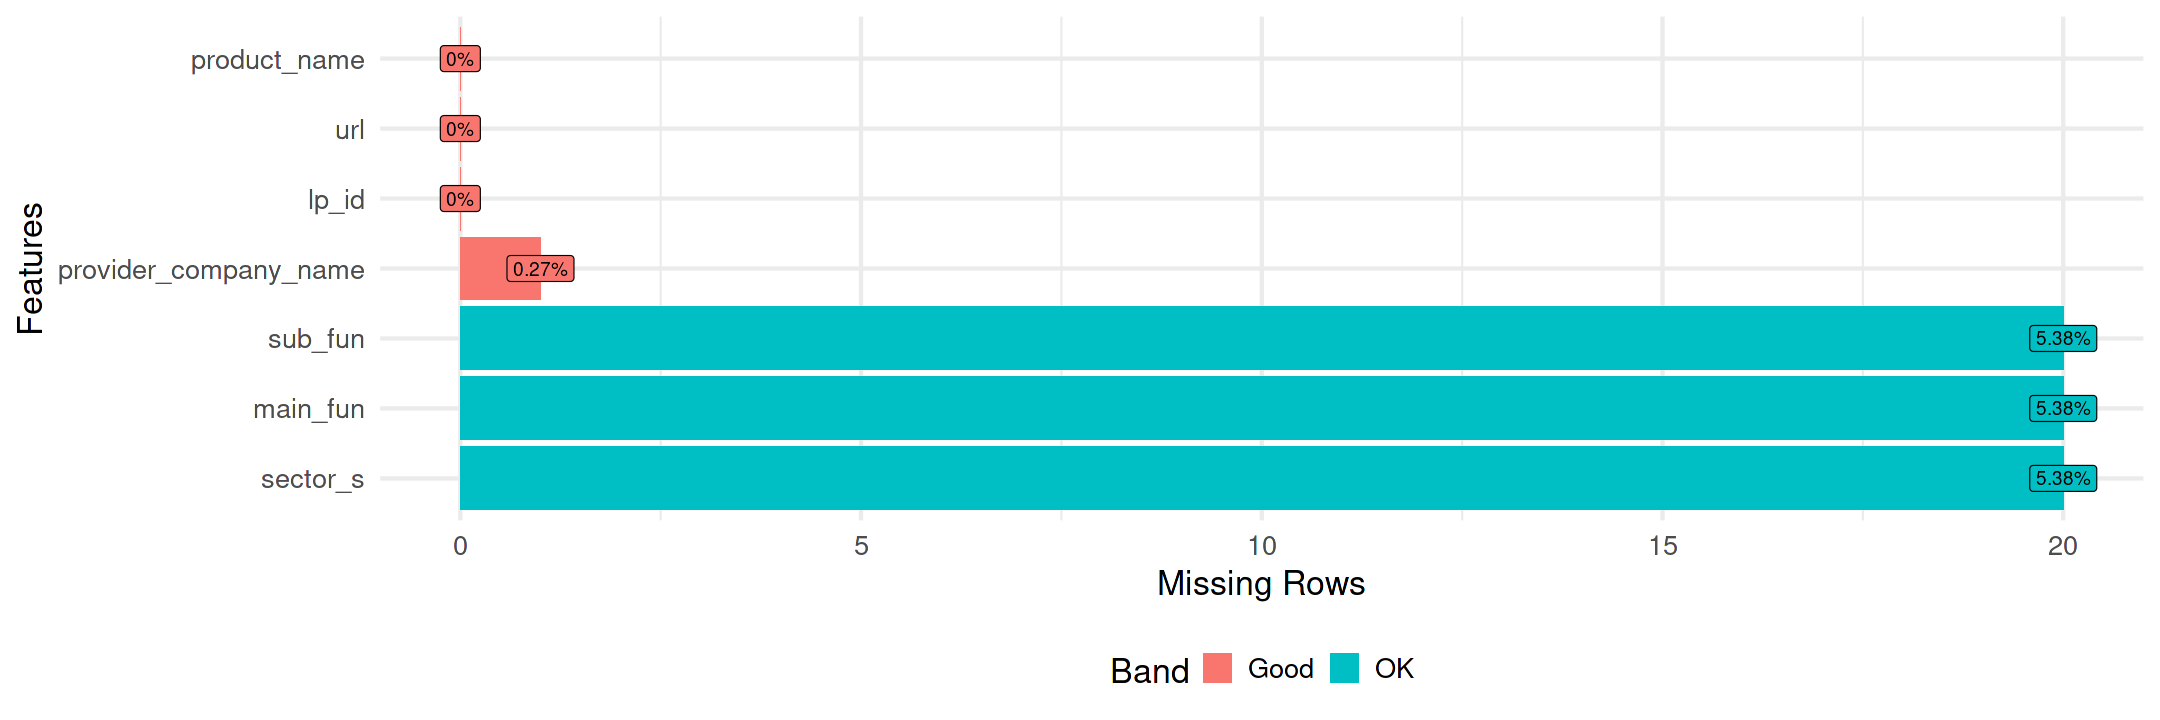

In [ ]:
plot_missing(products, ggtheme = theme_minimal(base_size = 20))

The amount of missing data in both data sets is acceptable except **pp_total_raw** column in districts dataframe. 

# Data Cleaning

In [ ]:
#cleaning pp_total_raw column
districts <- districts %>%
  separate(pp_total_raw,c("pp_total_raw-low","pp_total_raw-high"))
str(districts)

districts$`pp_total_raw-high` <- as.integer(districts$`pp_total_raw-high`)
districts$`pp_total_raw-low` <- as.integer(districts$`pp_total_raw-low`)
sum(is.na(districts$`pp_total_raw-high`))
sum(is.na(districts$`pp_total_raw-low`))
unique(districts$`pp_total_raw-high`)
unique(districts$`pp_total_raw-low`)

#Decide whether to impute `pp_total_raw-low` with mean or median
 districts %>%
  summarize(avg=mean(districts$`pp_total_raw-low`,na.rm = TRUE),med=median(districts$`pp_total_raw-low`,na.rm = TRUE))

districts <- districts %>%
  mutate(`pp_total_raw-low`=replace(districts$`pp_total_raw-low`,is.na(districts$`pp_total_raw-low`),median(districts$`pp_total_raw-low`,na.rm = TRUE)))

sum(is.na(districts$`pp_total_raw-low`))

#Decide whether to impute pp_total_raw-high with mean or median
 districts %>%
  summarize(avg=mean(districts$`pp_total_raw-high`,na.rm = TRUE),med=median(districts$`pp_total_raw-high`,na.rm = TRUE))

districts <- districts %>%
  mutate(`pp_total_raw-high`=replace(districts$`pp_total_raw-high`,is.na(districts$`pp_total_raw-high`),median(districts$`pp_total_raw-high`,na.rm = TRUE)))

sum(is.na(districts$`pp_total_raw-high`))

library(gt)

districts<- as.data.frame(districts %>%gt() %>% cols_merge_range(`pp_total_raw-low`,`pp_total_raw-high`, sep = "-"))
districts <- subset(districts, select = -c(`pp_total_raw-high`) )
districts <- districts %>%rename(pp_total_raw=`pp_total_raw-low`)
districts[1:10,]

tibble [233 × 8] (S3: tbl_df/tbl/data.frame)
 $ district_id             : num [1:233] 8815 2685 4921 3188 2238 ...
 $ state                   : chr [1:233] "Illinois" NA "Utah" NA ...
 $ locale                  : chr [1:233] "Suburb" NA "Suburb" NA ...
 $ pct_black_hispanic      : chr [1:233] "0-20" NA "0-20" NA ...
 $ pct_free_reduced        : chr [1:233] "0-20" NA "20-40" NA ...
 $ county_connections_ratio: chr [1:233] "[0.18, 1[" NA "[0.18, 1[" NA ...
 $ pp_total_raw-low        : chr [1:233] "14000" NA "6000" NA ...
 $ pp_total_raw-high       : chr [1:233] "16000" NA "8000" NA ...


[1] 115

[1] 115

[1] 16000    NA  8000 12000 10000 14000 18000 22000 20000 24000  6000 34000

[1] 14000    NA  6000 10000  8000 12000 16000 20000 18000 22000  4000 32000

avg      med  
1 11474.58 10000

[1] 0

avg      med  
1 13474.58 12000

[1] 0

district_id state          locale pct_black_hispanic pct_free_reduced
1  8815        Illinois       Suburb 0-20               0-20            
2  2685        NA             NA     NA                 NA              
3  4921        Utah           Suburb 0-20               20-40           
4  3188        NA             NA     NA                 NA              
5  2238        NA             NA     NA                 NA              
6  5987        Wisconsin      Suburb 0-20               0-20            
7  3710        Utah           Suburb 0-20               40-60           
8  7177        North Carolina Suburb 20-40              20-40           
9  9812        Utah           Suburb 0-20               20-40           
10 6584        North Carolina Rural  40-60              60-80           
   county_connections_ratio pp_total_raw
1  [0.18, 1[                14000-16000 
2  NA                       10000-12000 
3  [0.18, 1[                6000-8000   
4  NA                       10000-12000 
5  NA                       10000-12000 
6  [0.18, 1[                10000-12000 
7  [0.18, 1[                6000-8000   
8  [0.18, 1[                8000-10000  
9  [0.18, 1[                6000-8000   
10 [0.18, 1[                8000-10000

# Data distribution

1 columns ignored with more than 50 categories.
district_id: 233 categories




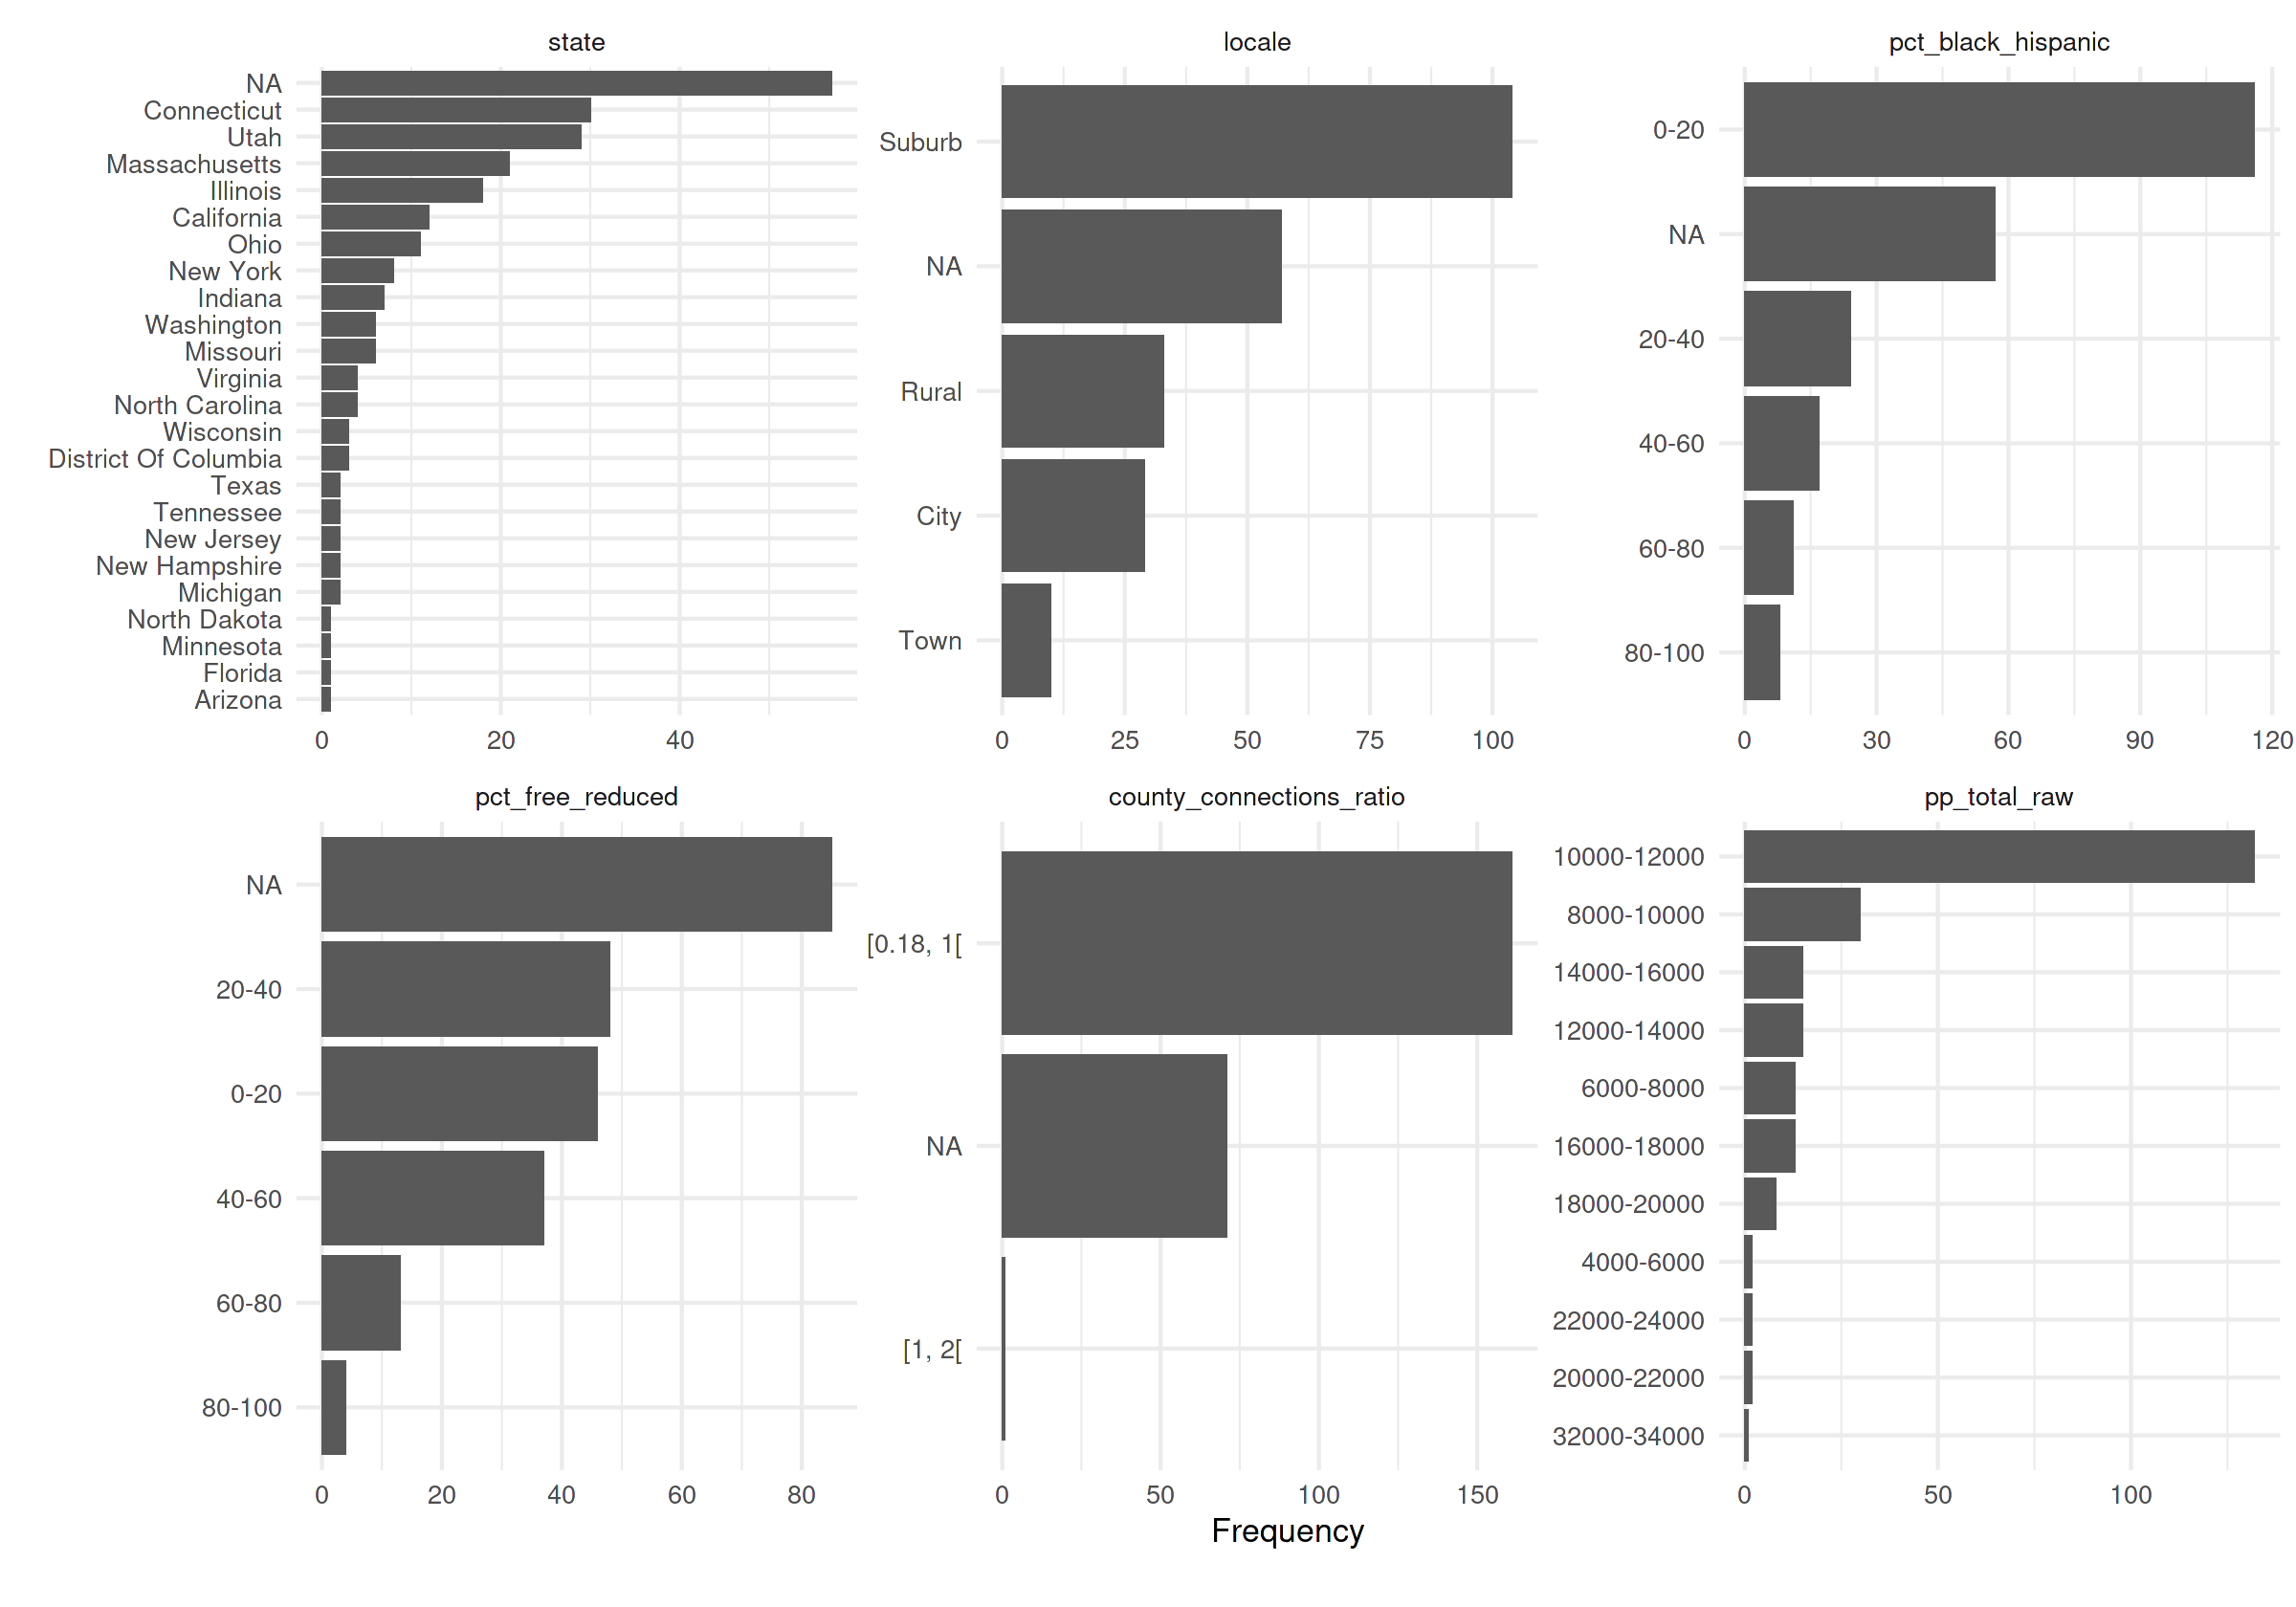

In [ ]:
#Districts
options(repr.plot.height = 14, repr.plot.width = 20)

plot_bar(districts, ggtheme = theme_minimal(base_size = 20))

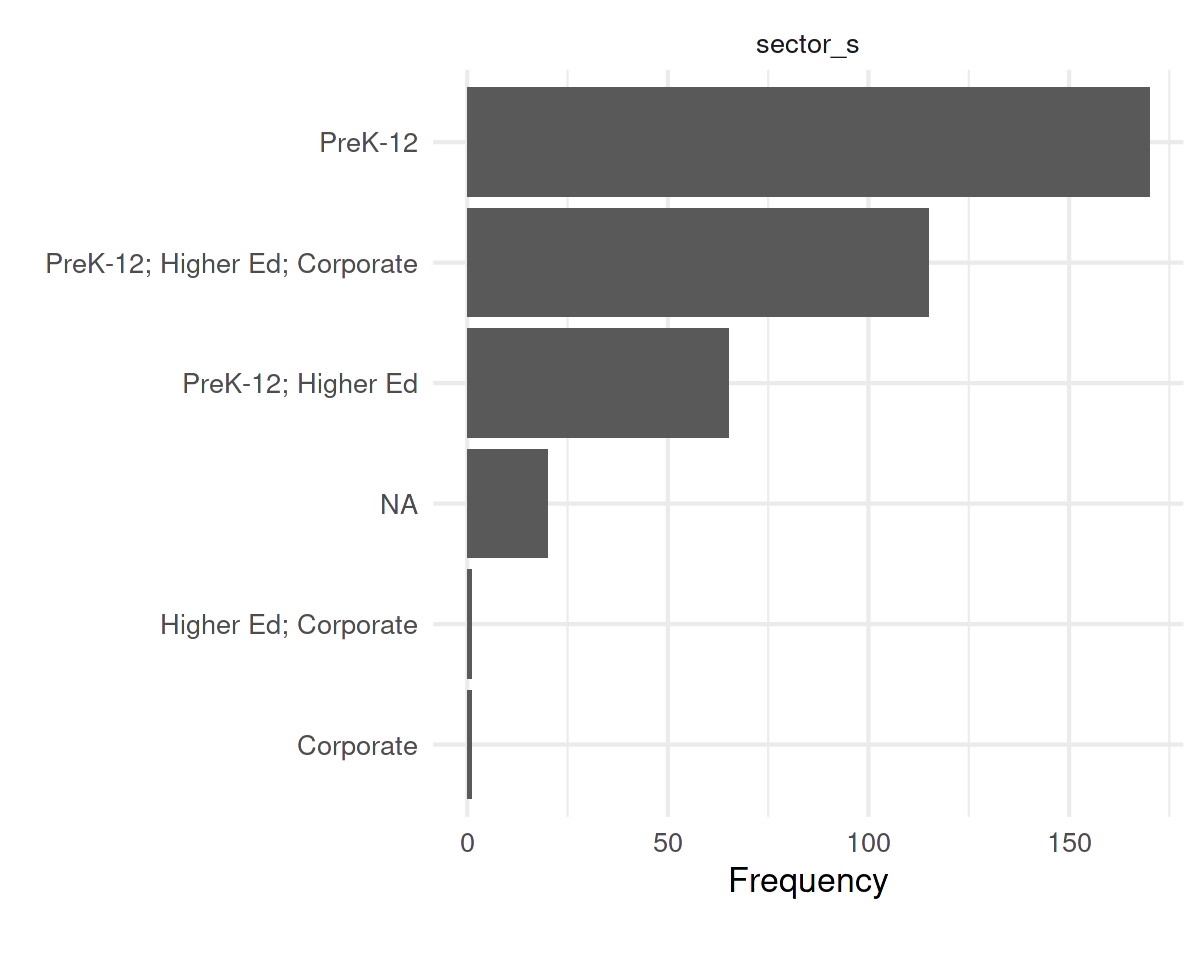

In [ ]:
# Products
options(repr.plot.height = 8, repr.plot.width = 10)

products %>%
select(`sector_s`) %>%
plot_bar(ggtheme = theme_minimal(base_size = 20))

### Districts data distribution

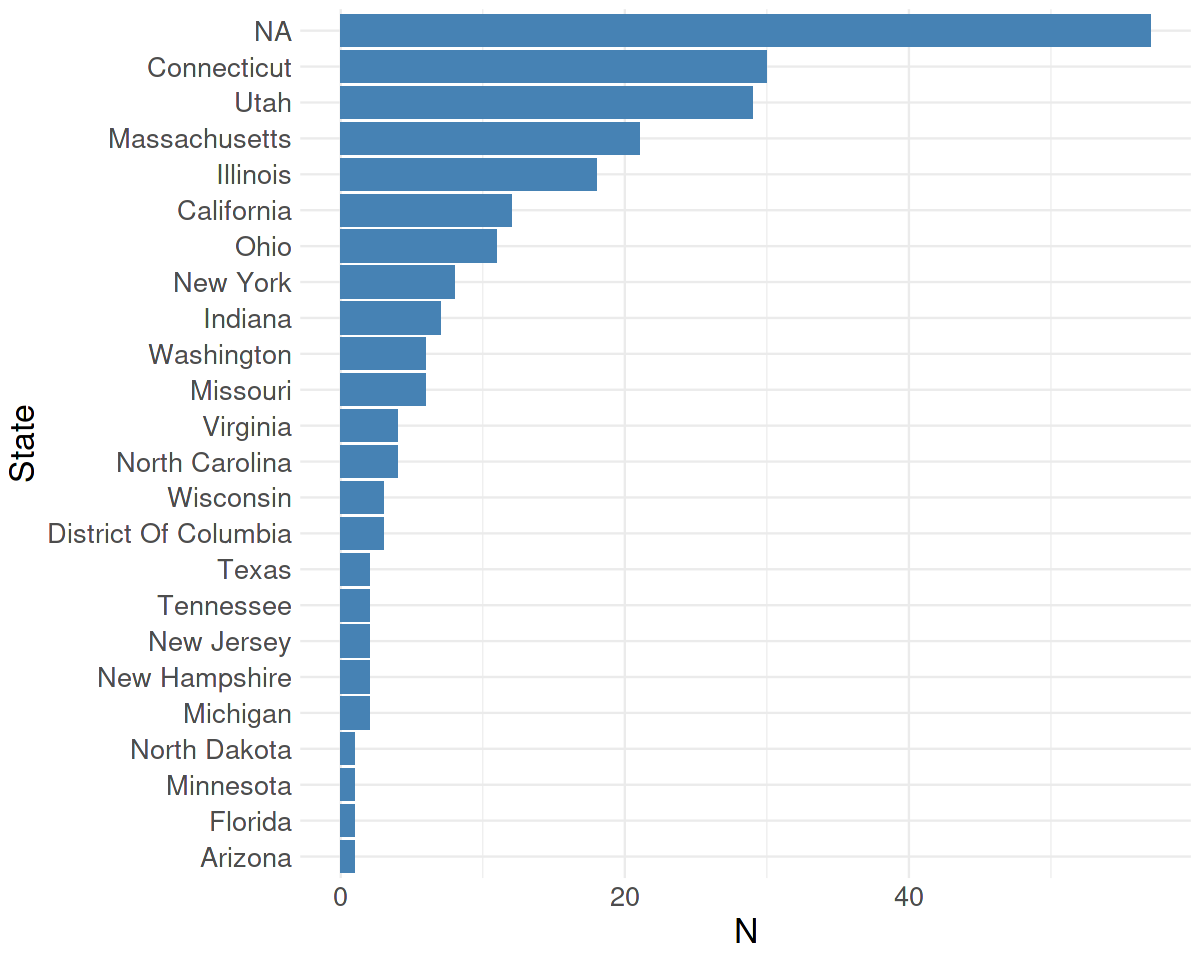

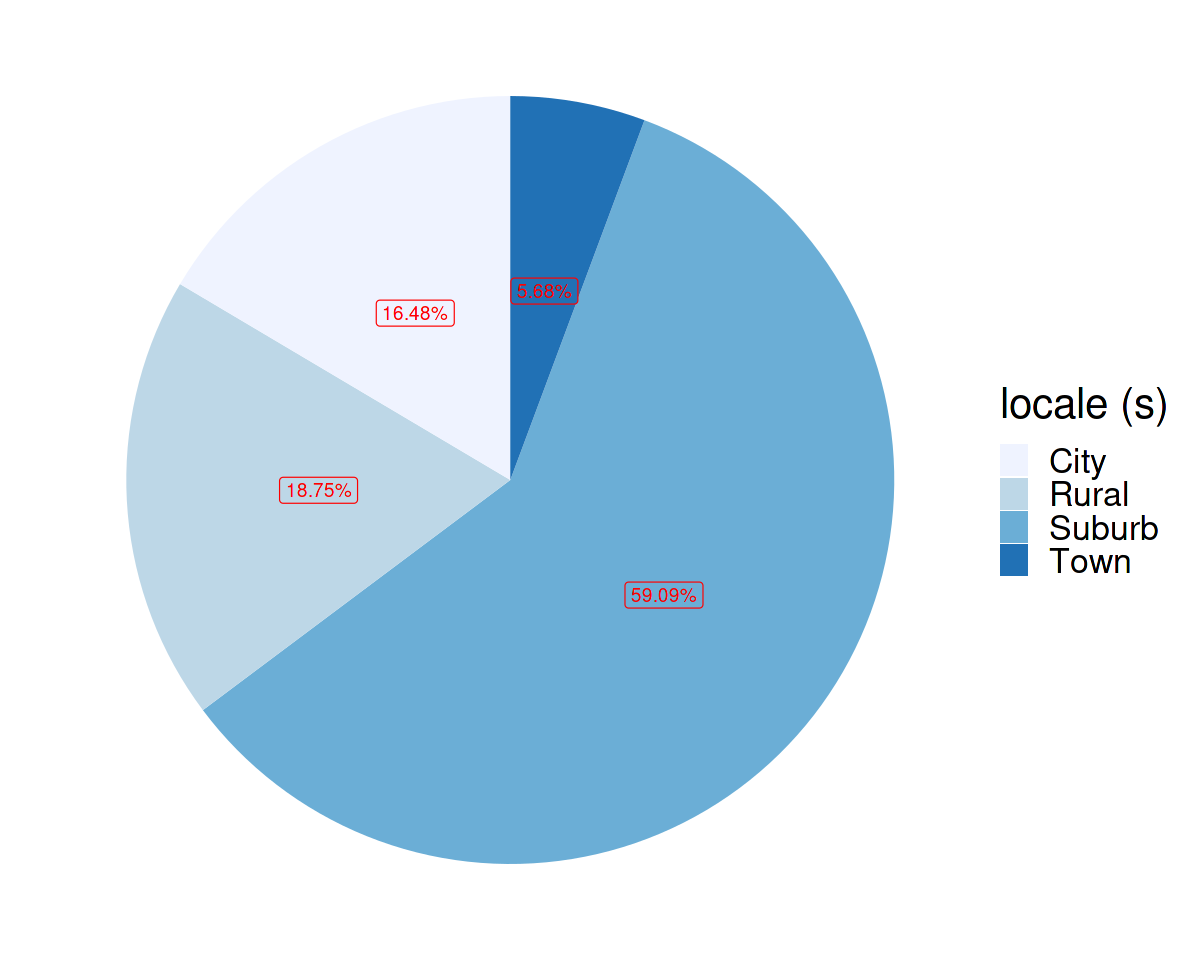

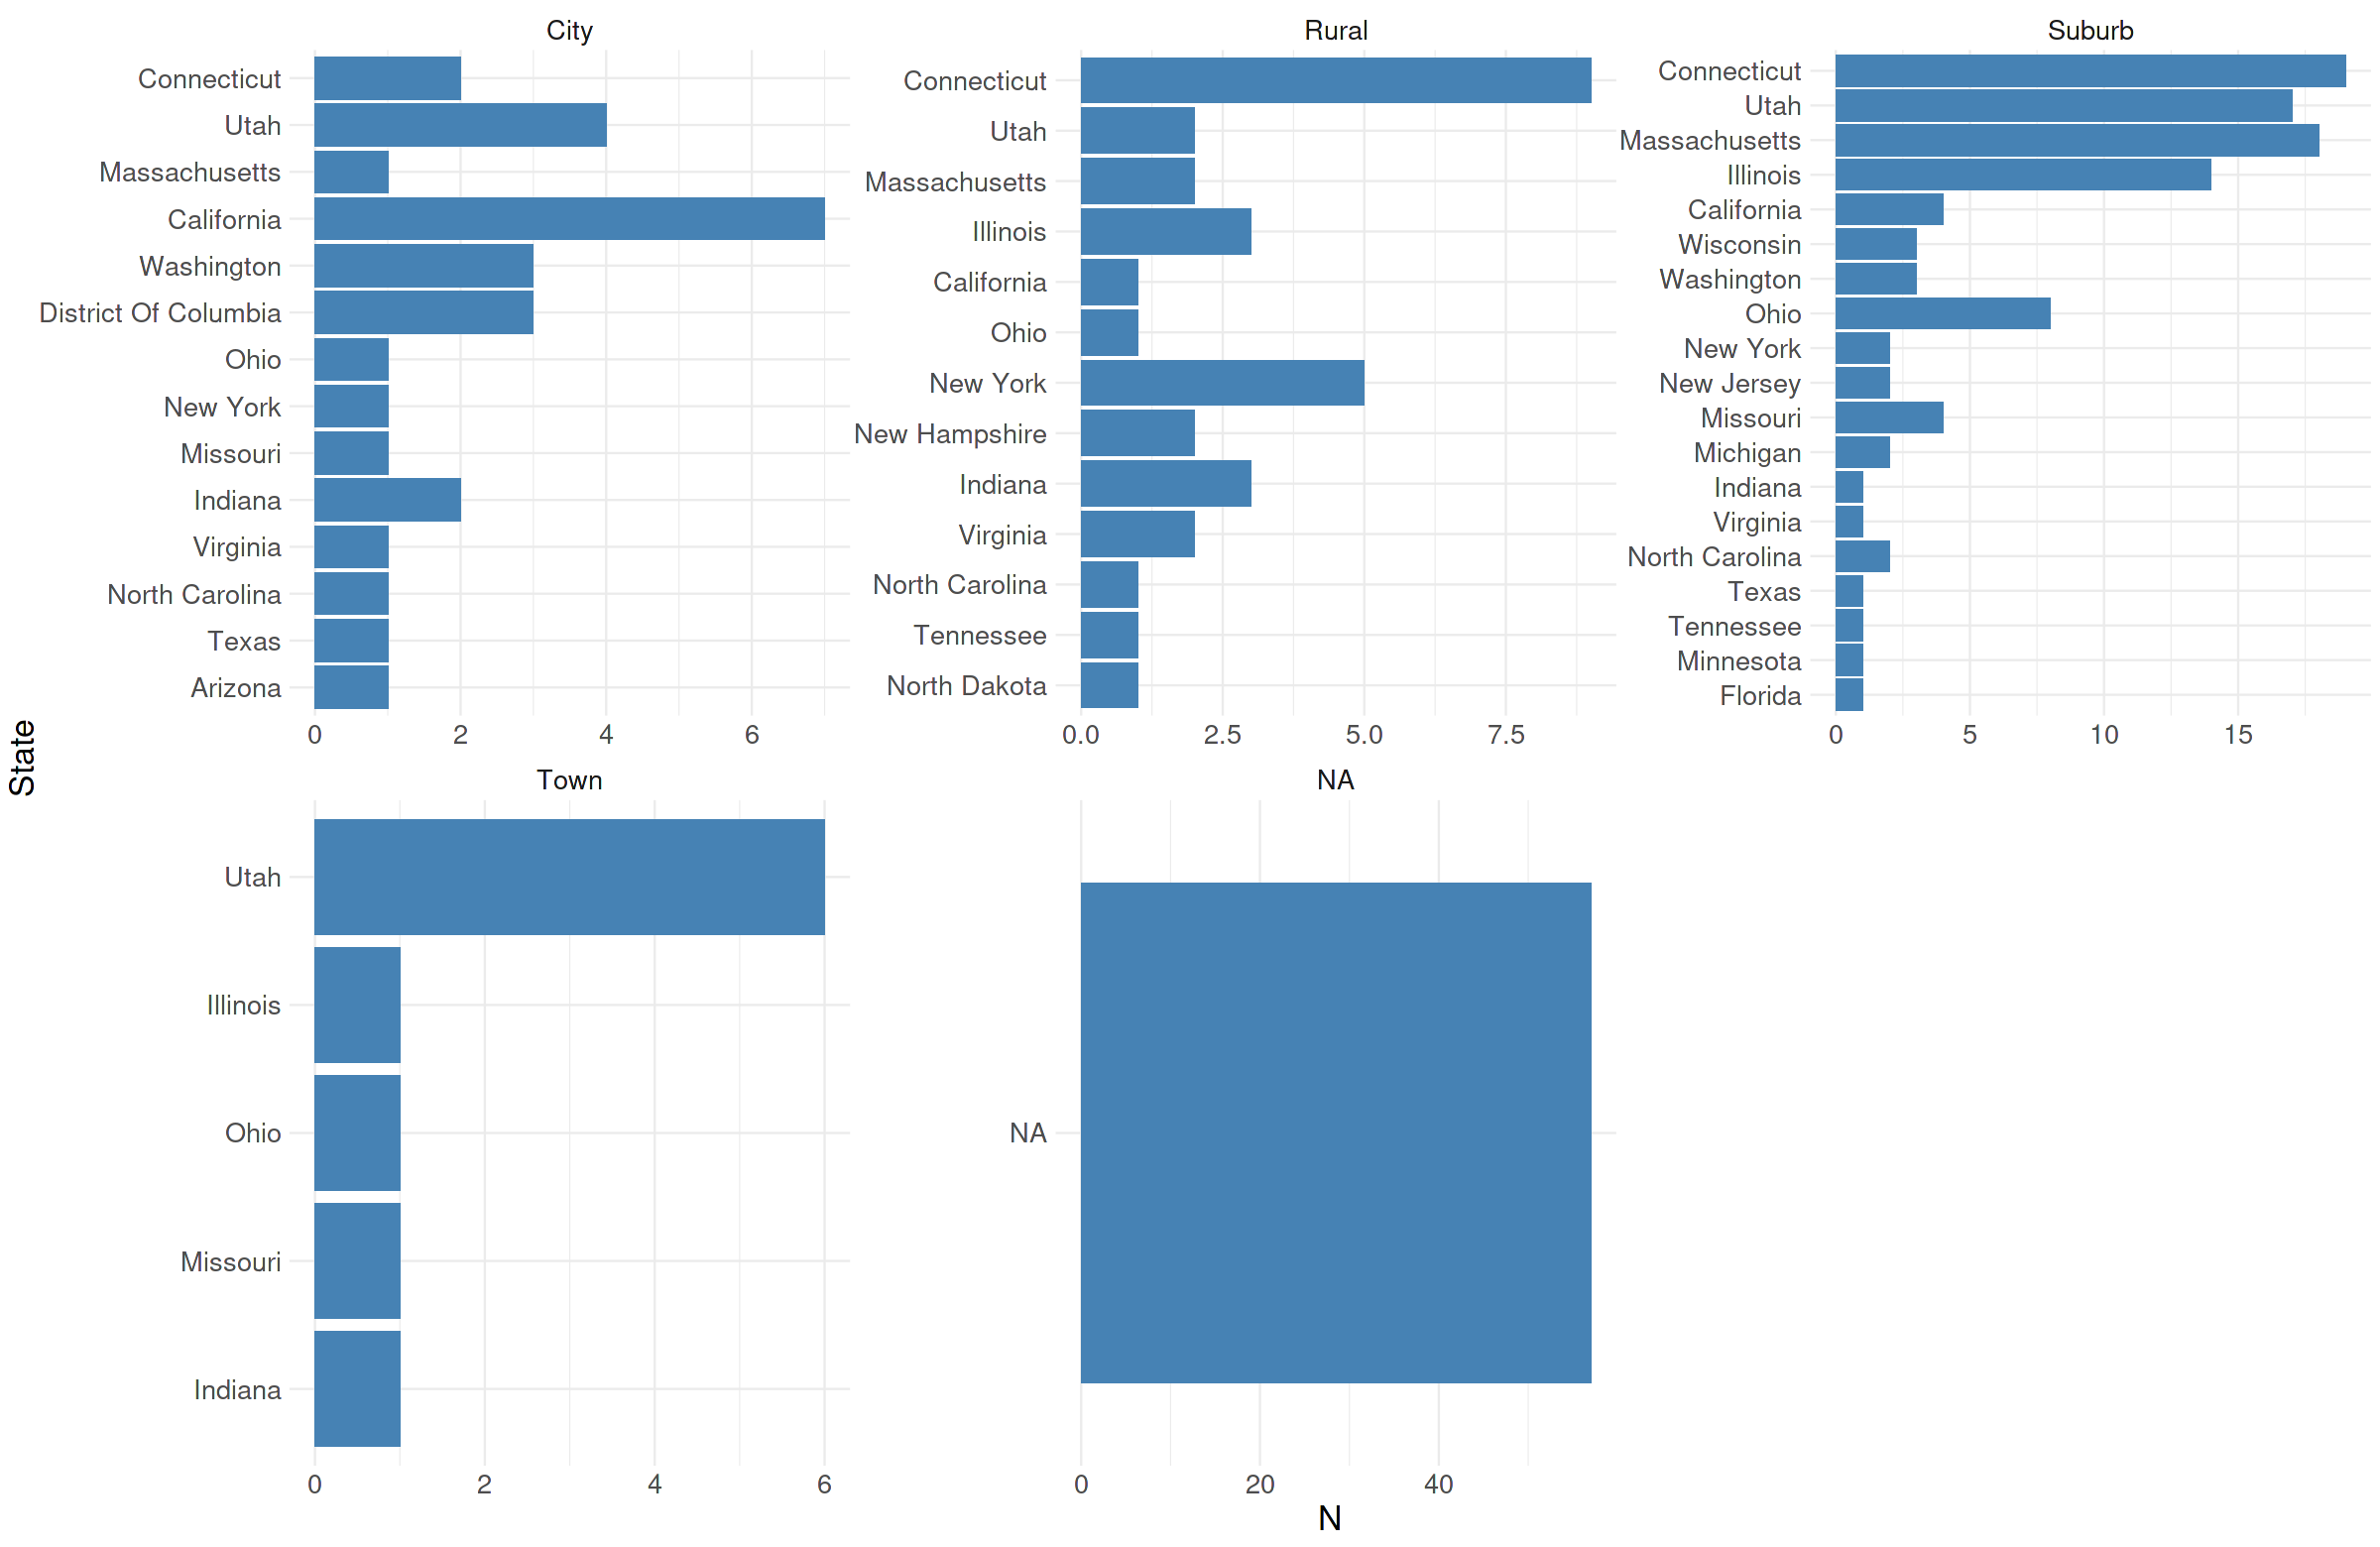

In [ ]:
#State
districts %>%
group_by(state) %>%
count() %>%
ggplot(aes(x = reorder(state, n), y = n)) +
geom_bar(stat = "identity", fill = "steelblue") +
labs(x = "State", y = "N") +
theme_minimal() +
coord_flip() +
theme(text = element_text(size=20))

#locale
districts %>% filter(locale!="") %>% 
  group_by(locale) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>% 
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=locale))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size=25)+
  geom_label(
    aes(label=perc),
    color='red',
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="locale (s)"))+
  scale_fill_brewer("Blues")

#State x locale
options(repr.plot.height = 13, repr.plot.width = 20)

districts %>%
group_by(state, locale) %>%
count() %>%
ggplot(aes(x = reorder(state, n), y = n)) +
geom_bar(stat = "identity", fill = "steelblue") +
labs(x = "State", y = "N") +
theme_minimal() +
coord_flip() +
facet_wrap(~locale, scales = "free") +
theme(text = element_text(size=20))

### Products data distribution

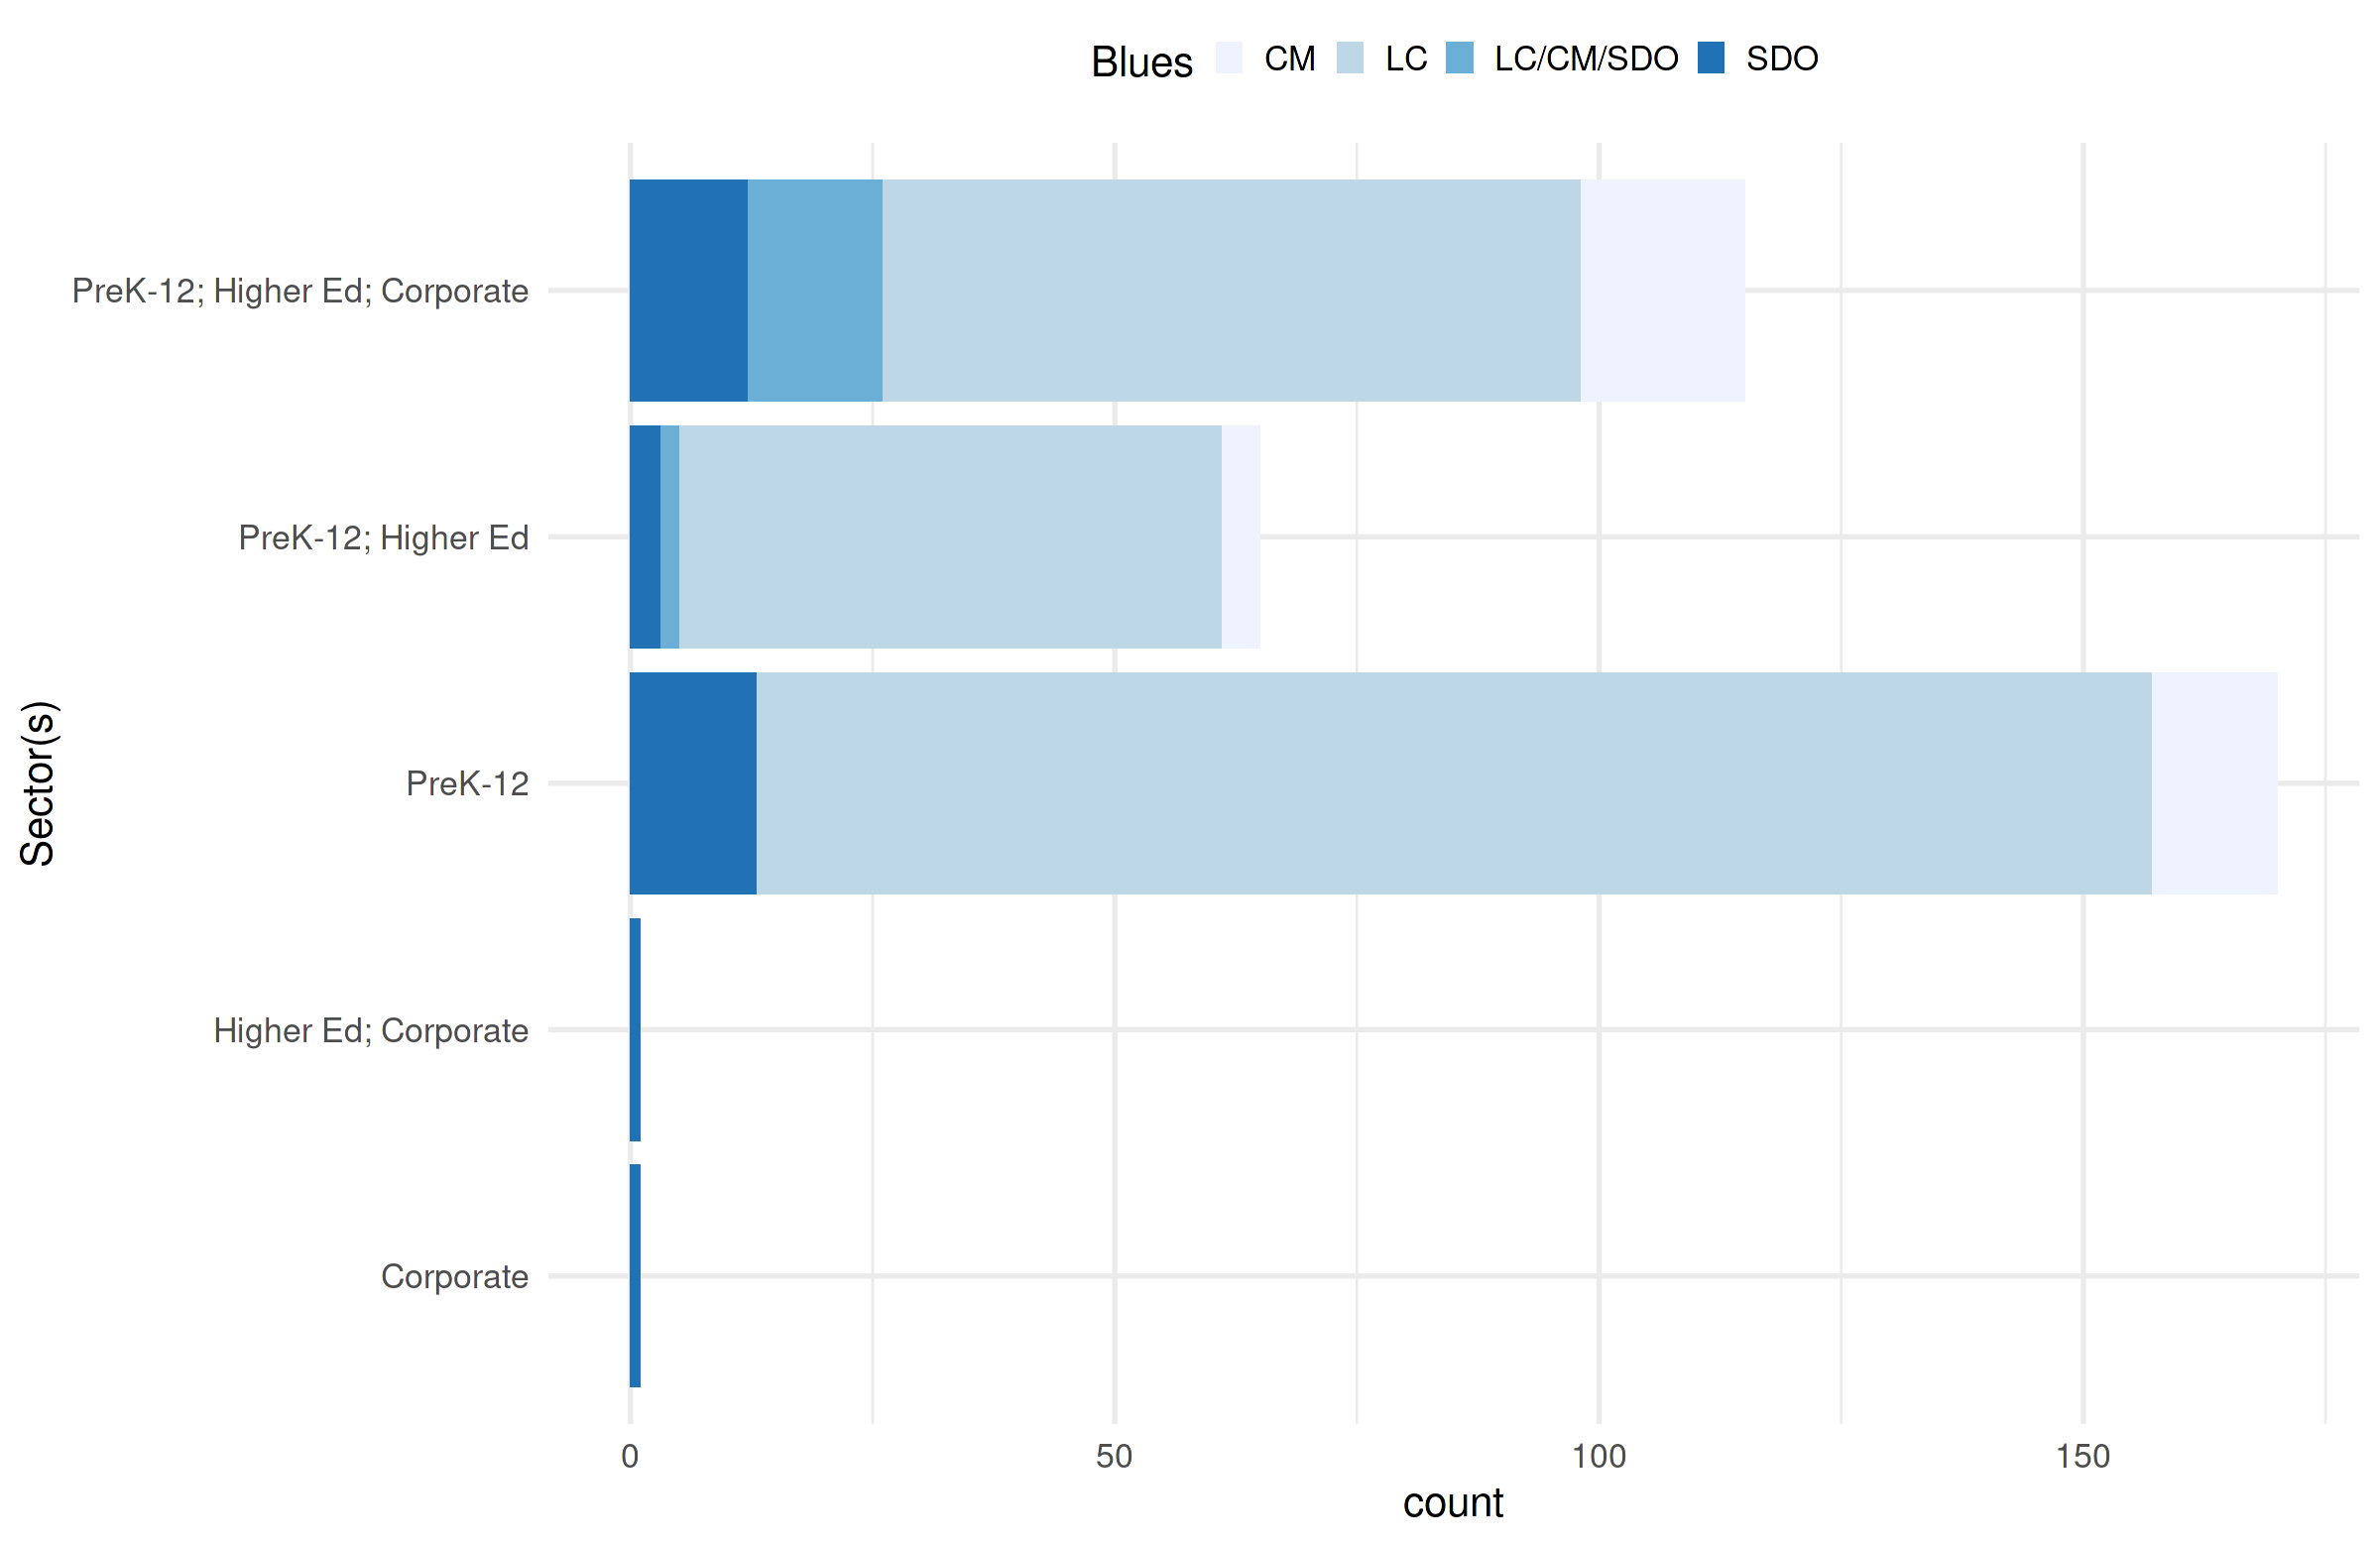

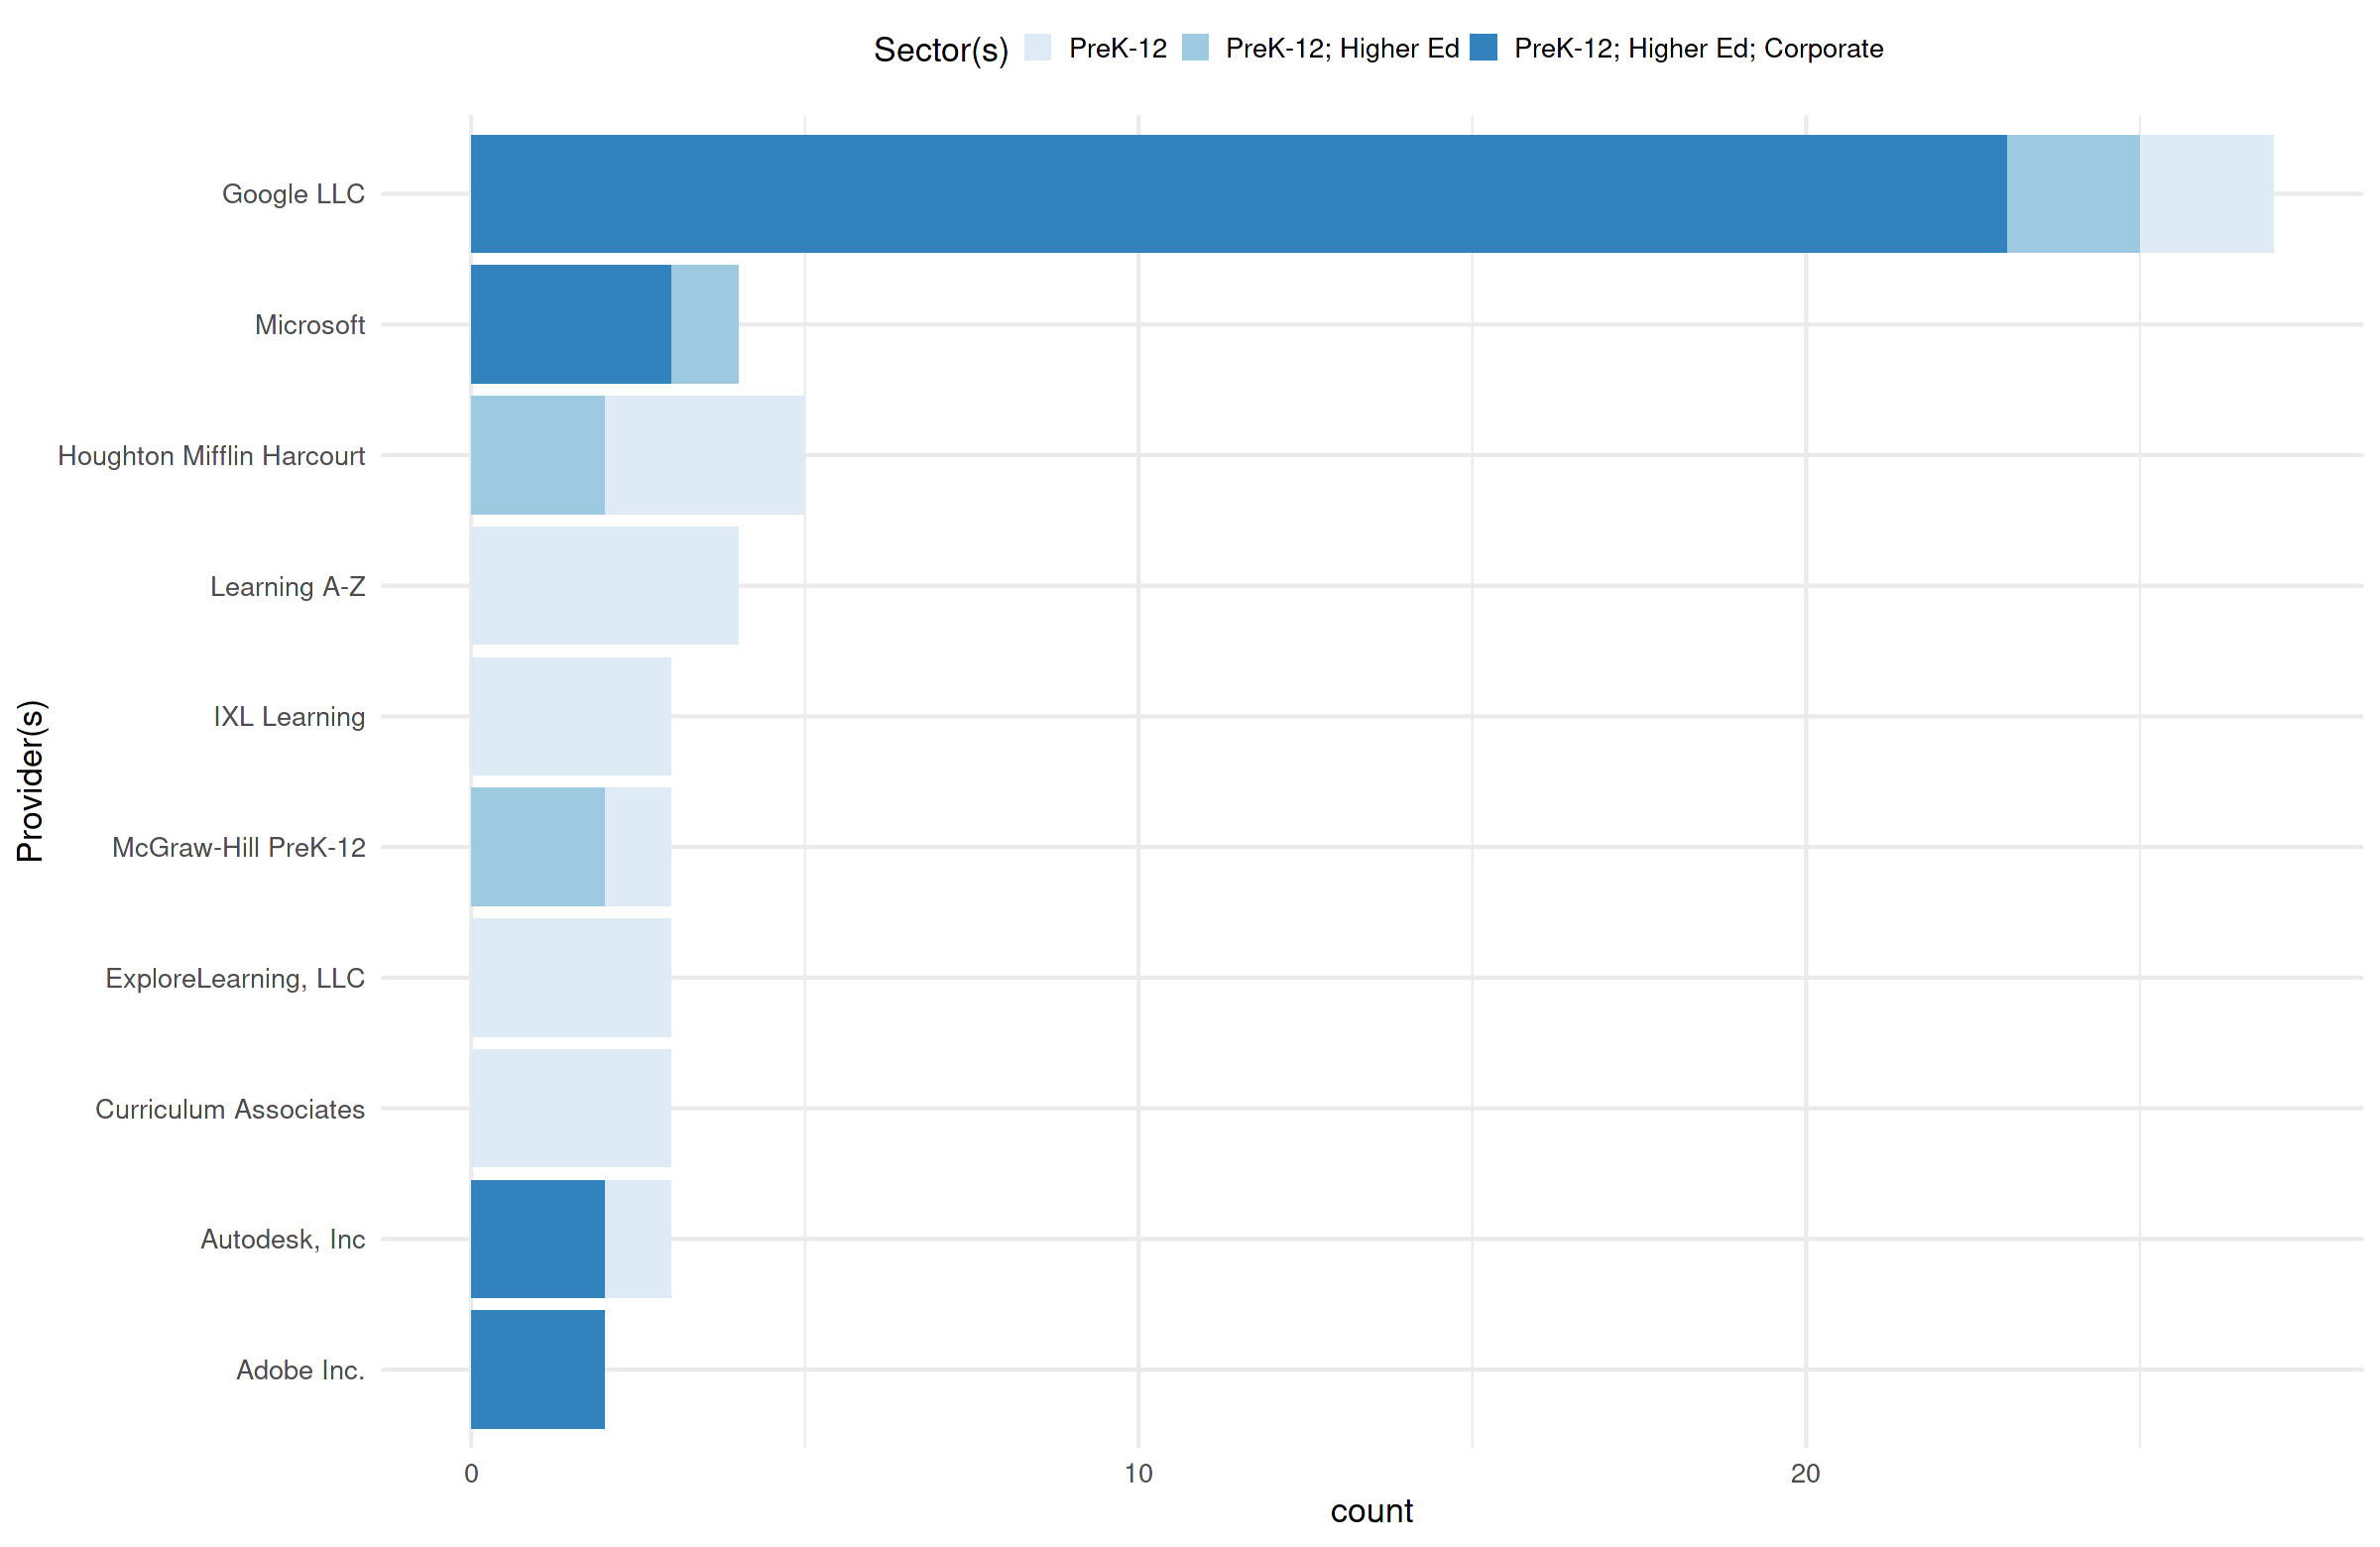

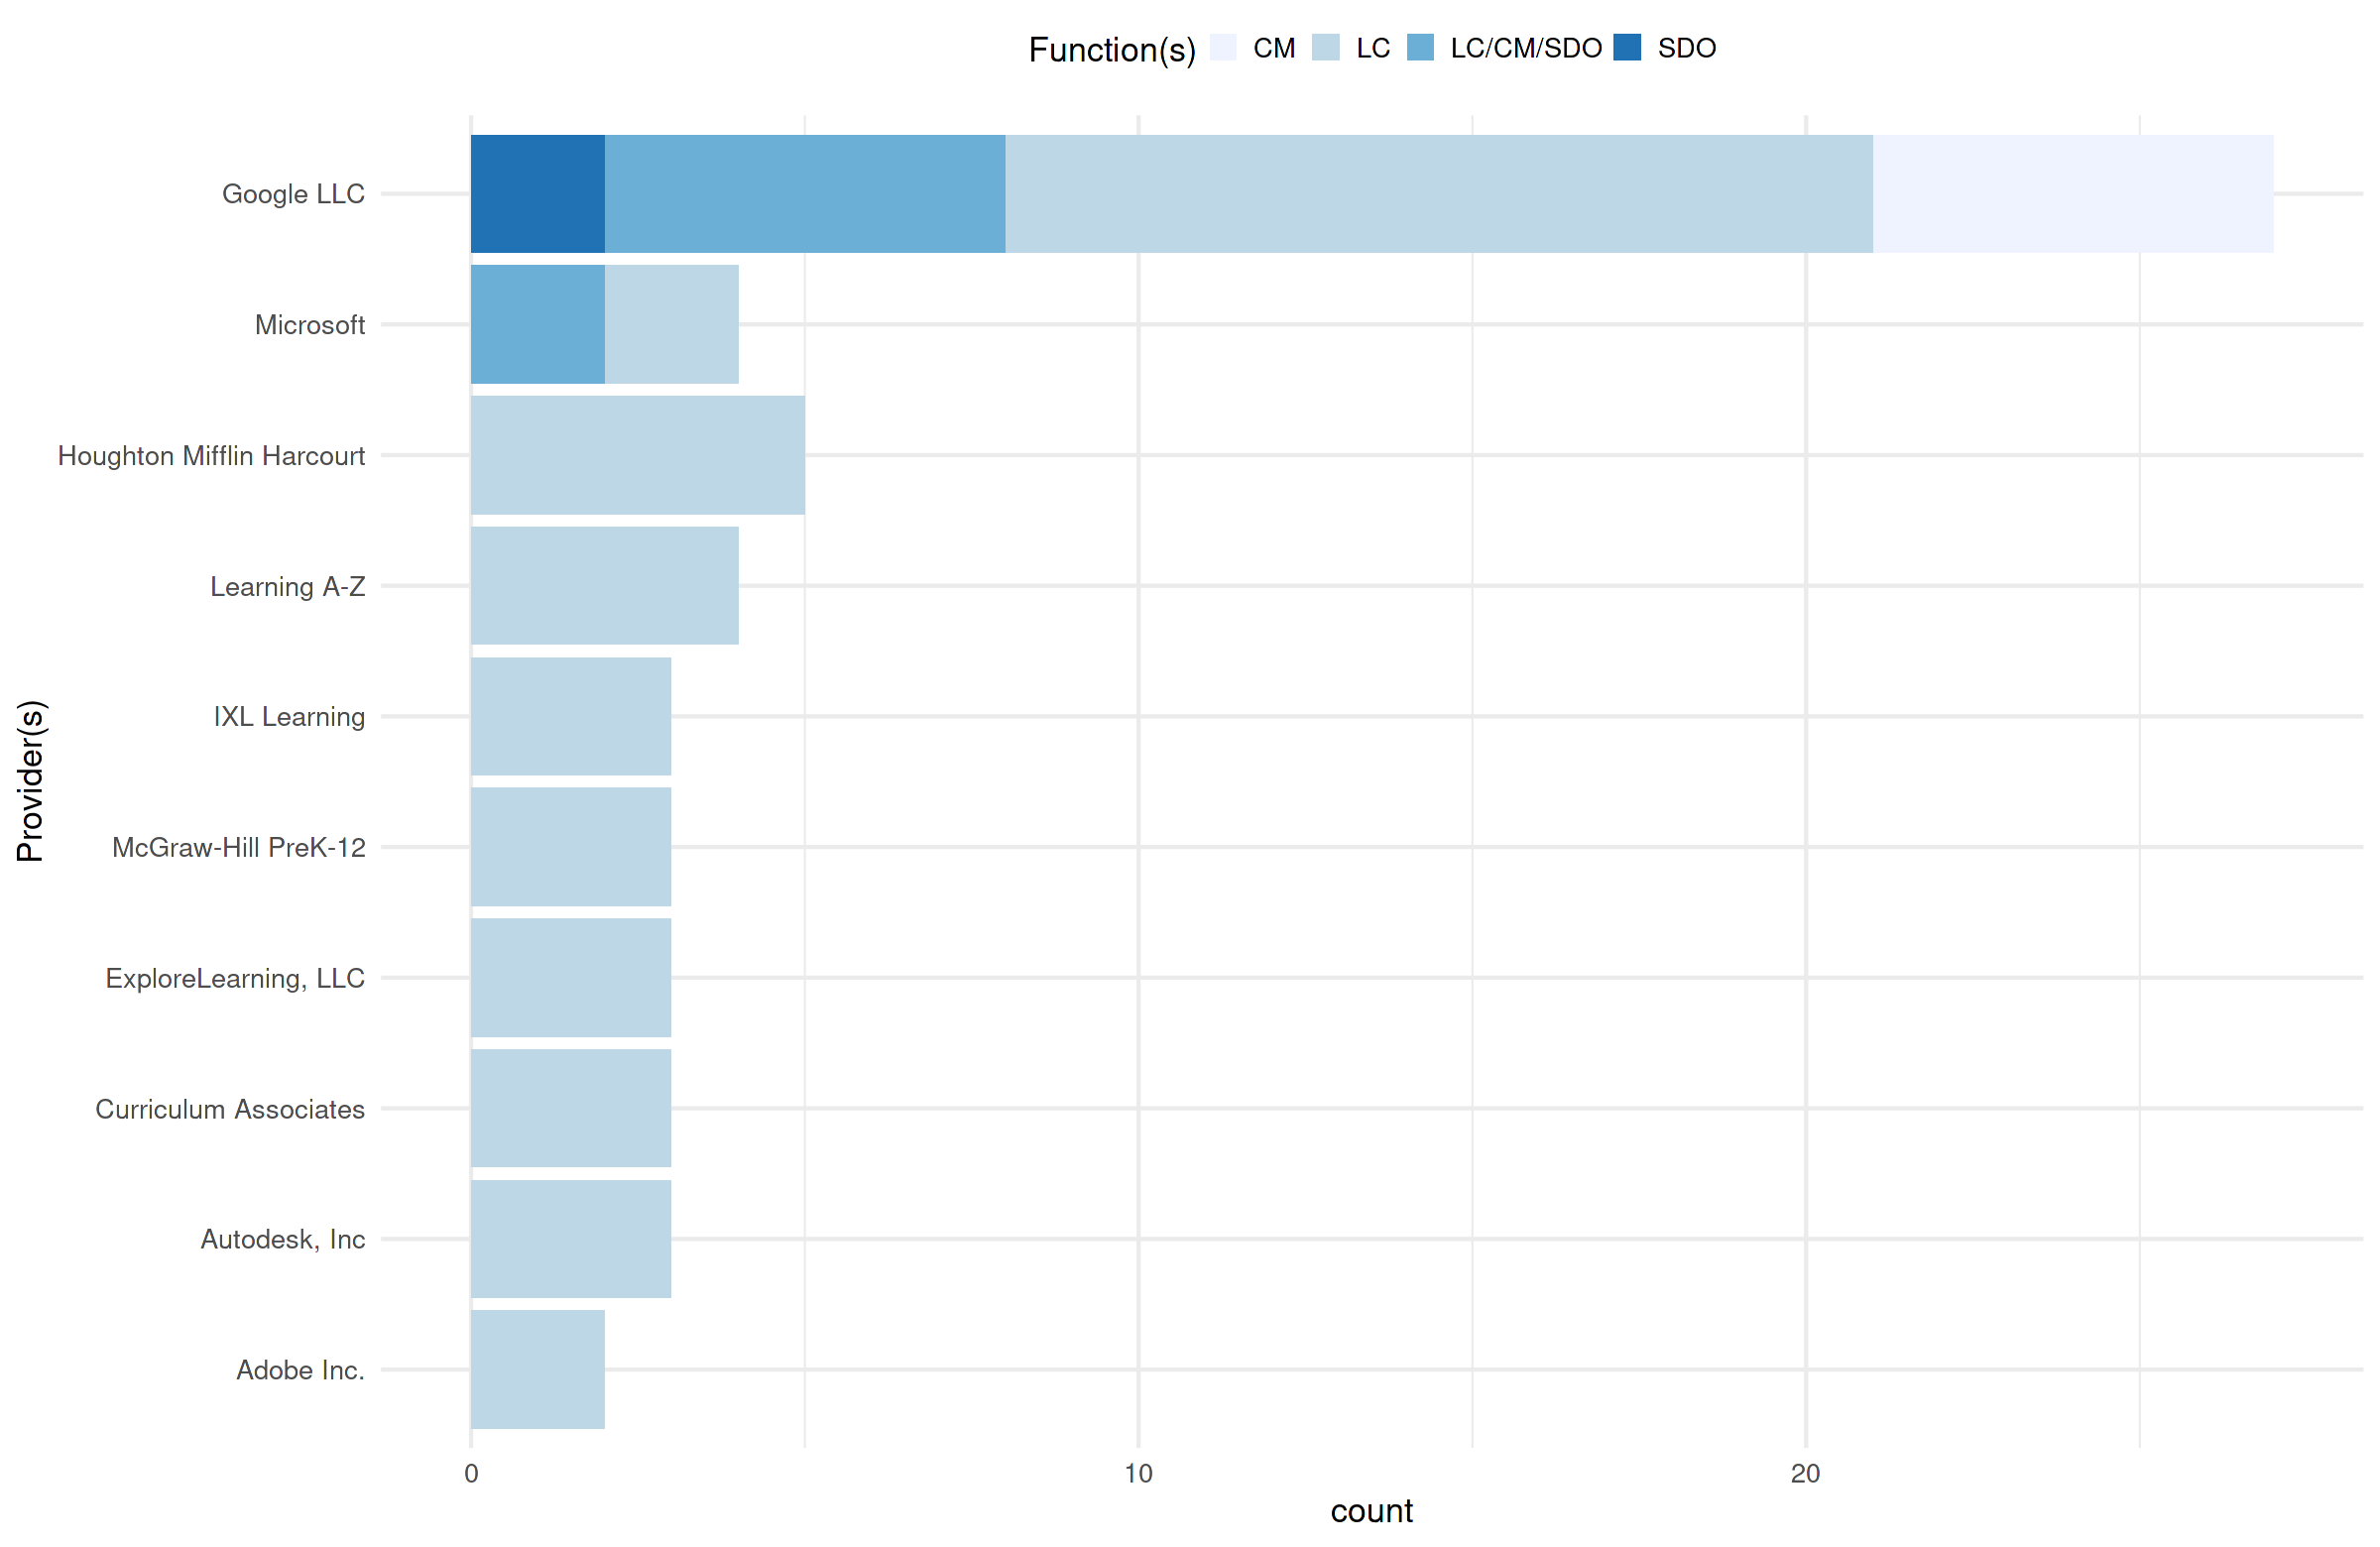

In [ ]:
#sectors * function
products %>% filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
  )%>% ggplot(aes(y=sector_s))+geom_bar(aes(fill=Functions))+
  theme_minimal(base_size=25)+
  theme(legend.position = "top")+
  ylab("Sector(s)")+
  scale_fill_brewer("Blues")

#provides * function
top10_name=products %>% filter(provider_company_name!="") %>% 
  group_by(provider_company_name) %>% 
  summarise(count=n()) %>% 
  arrange(desc(count)) %>% head(10) %>%  mutate(
    provider_company_name=fct_reorder(provider_company_name,count)
  )

products %>% filter(provider_company_name %in% top10_name$provider_company_name) %>% 
  filter(sector_s!="") %>% 
  mutate(provider_company_name=fct_relevel(
    provider_company_name,levels(top10_name$provider_company_name)
  )) %>% 
  ggplot(aes(y=provider_company_name))+
  geom_bar(aes(fill=sector_s))+
  theme_minimal(base_size=20)+
  theme(legend.position = "top")+
  guides(fill=guide_legend(title="Sector(s)"))+
  ylab("Provider(s)")+
  scale_fill_brewer("Blues")

#provides * sectors
products %>% filter(provider_company_name %in% top10_name$provider_company_name) %>% 
  filter(sector_s!="") %>% 
  mutate(provider_company_name=fct_relevel(
    provider_company_name,levels(top10_name$provider_company_name)
  )) %>%
  filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
  )%>%
  ggplot(aes(y=provider_company_name))+
  geom_bar(aes(fill=Functions))+
  theme_minimal(base_size=20)+
  theme(legend.position = "top")+
  guides(fill=guide_legend(title="Function(s)"))+
  ylab("Provider(s)")+
  scale_fill_brewer("Blues")

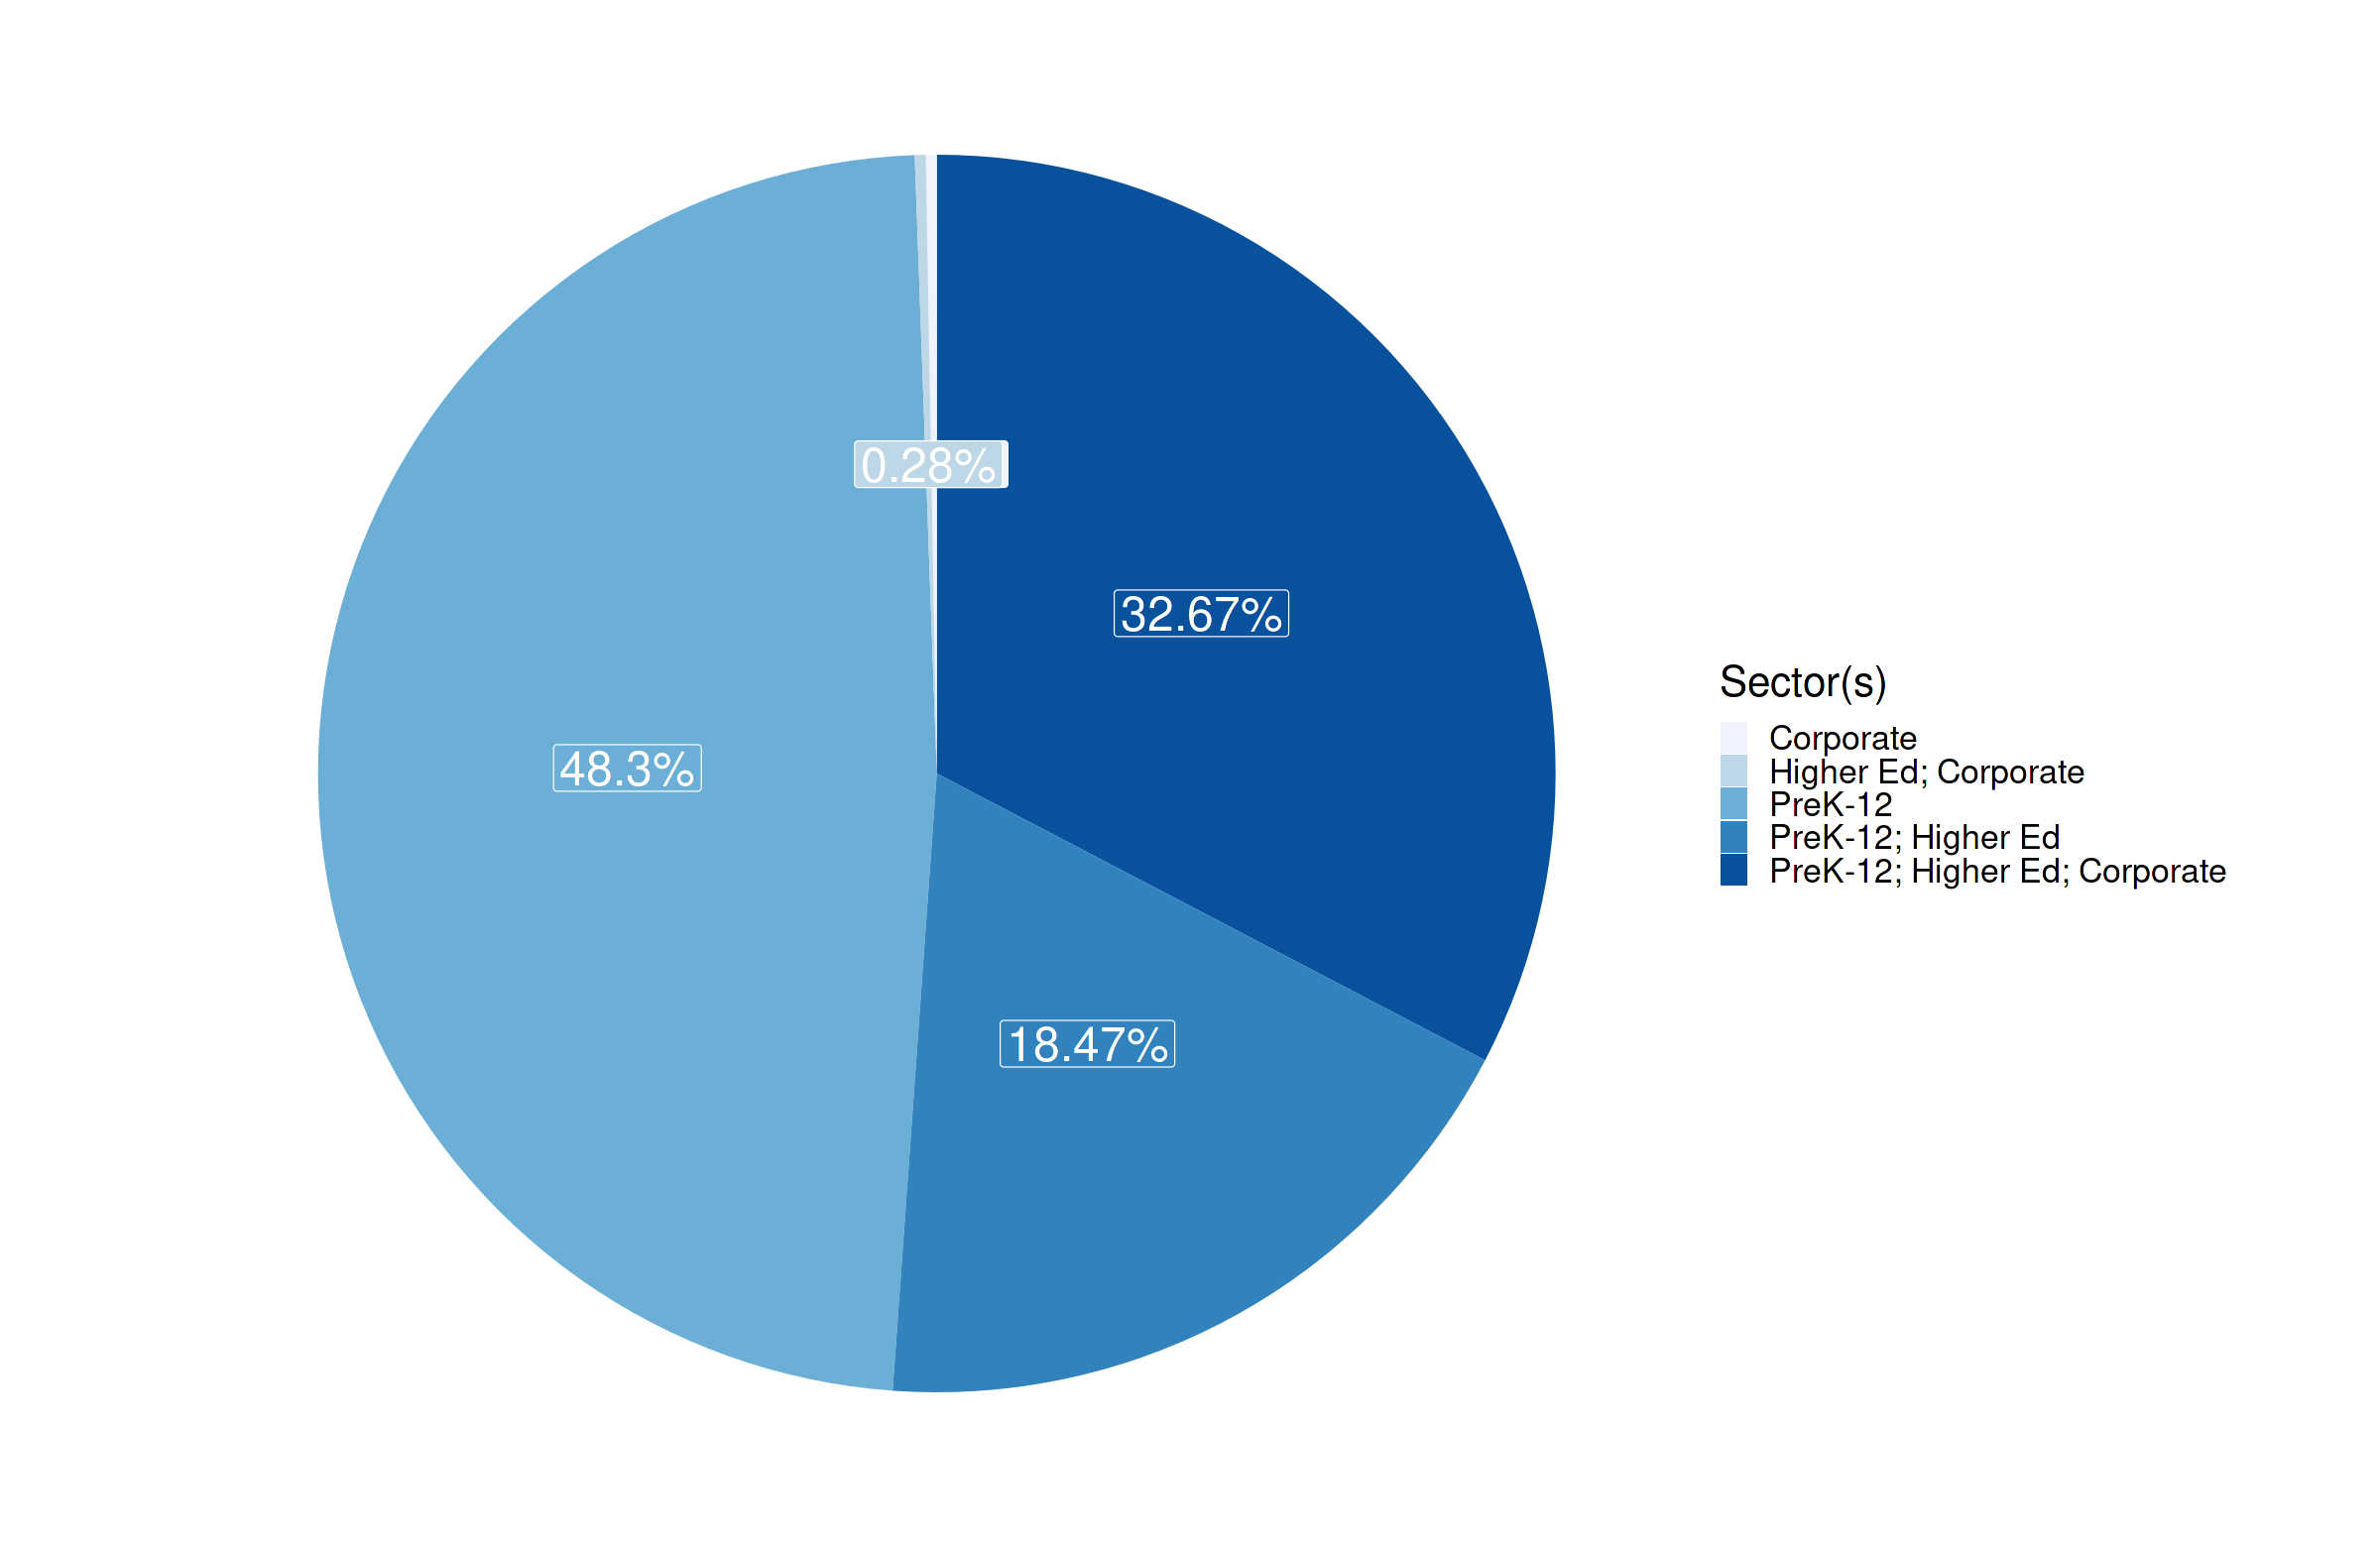

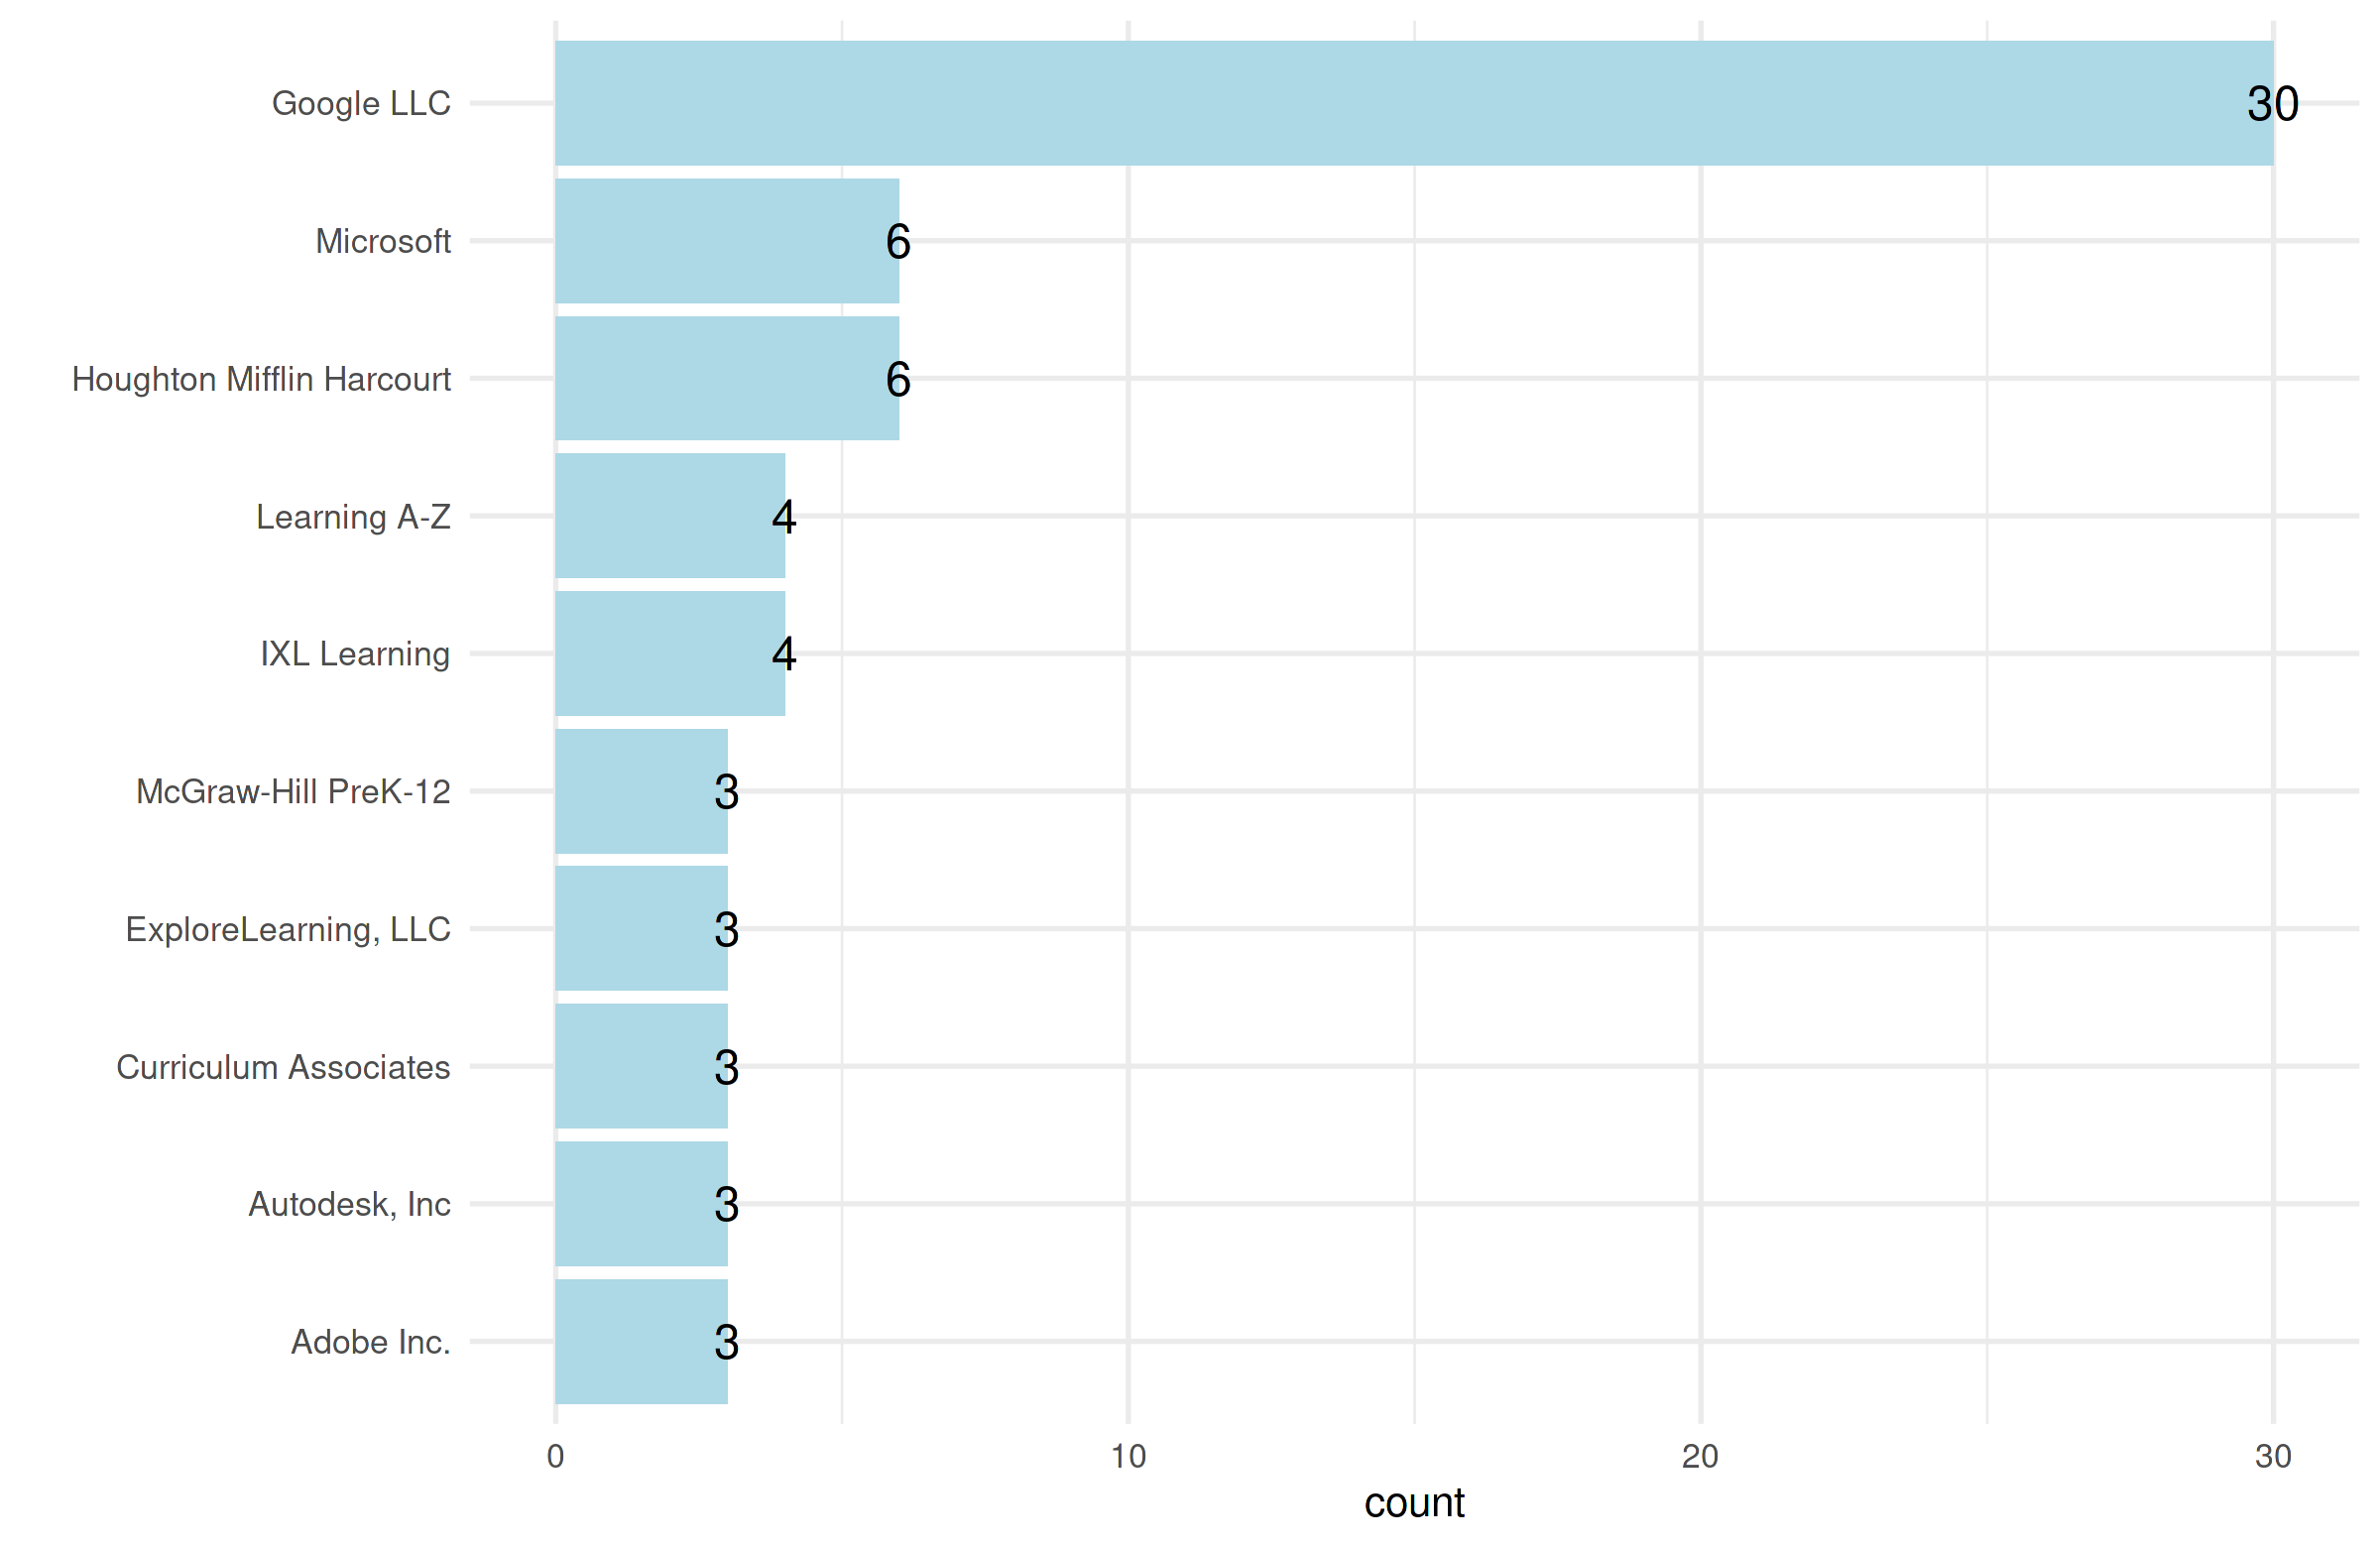

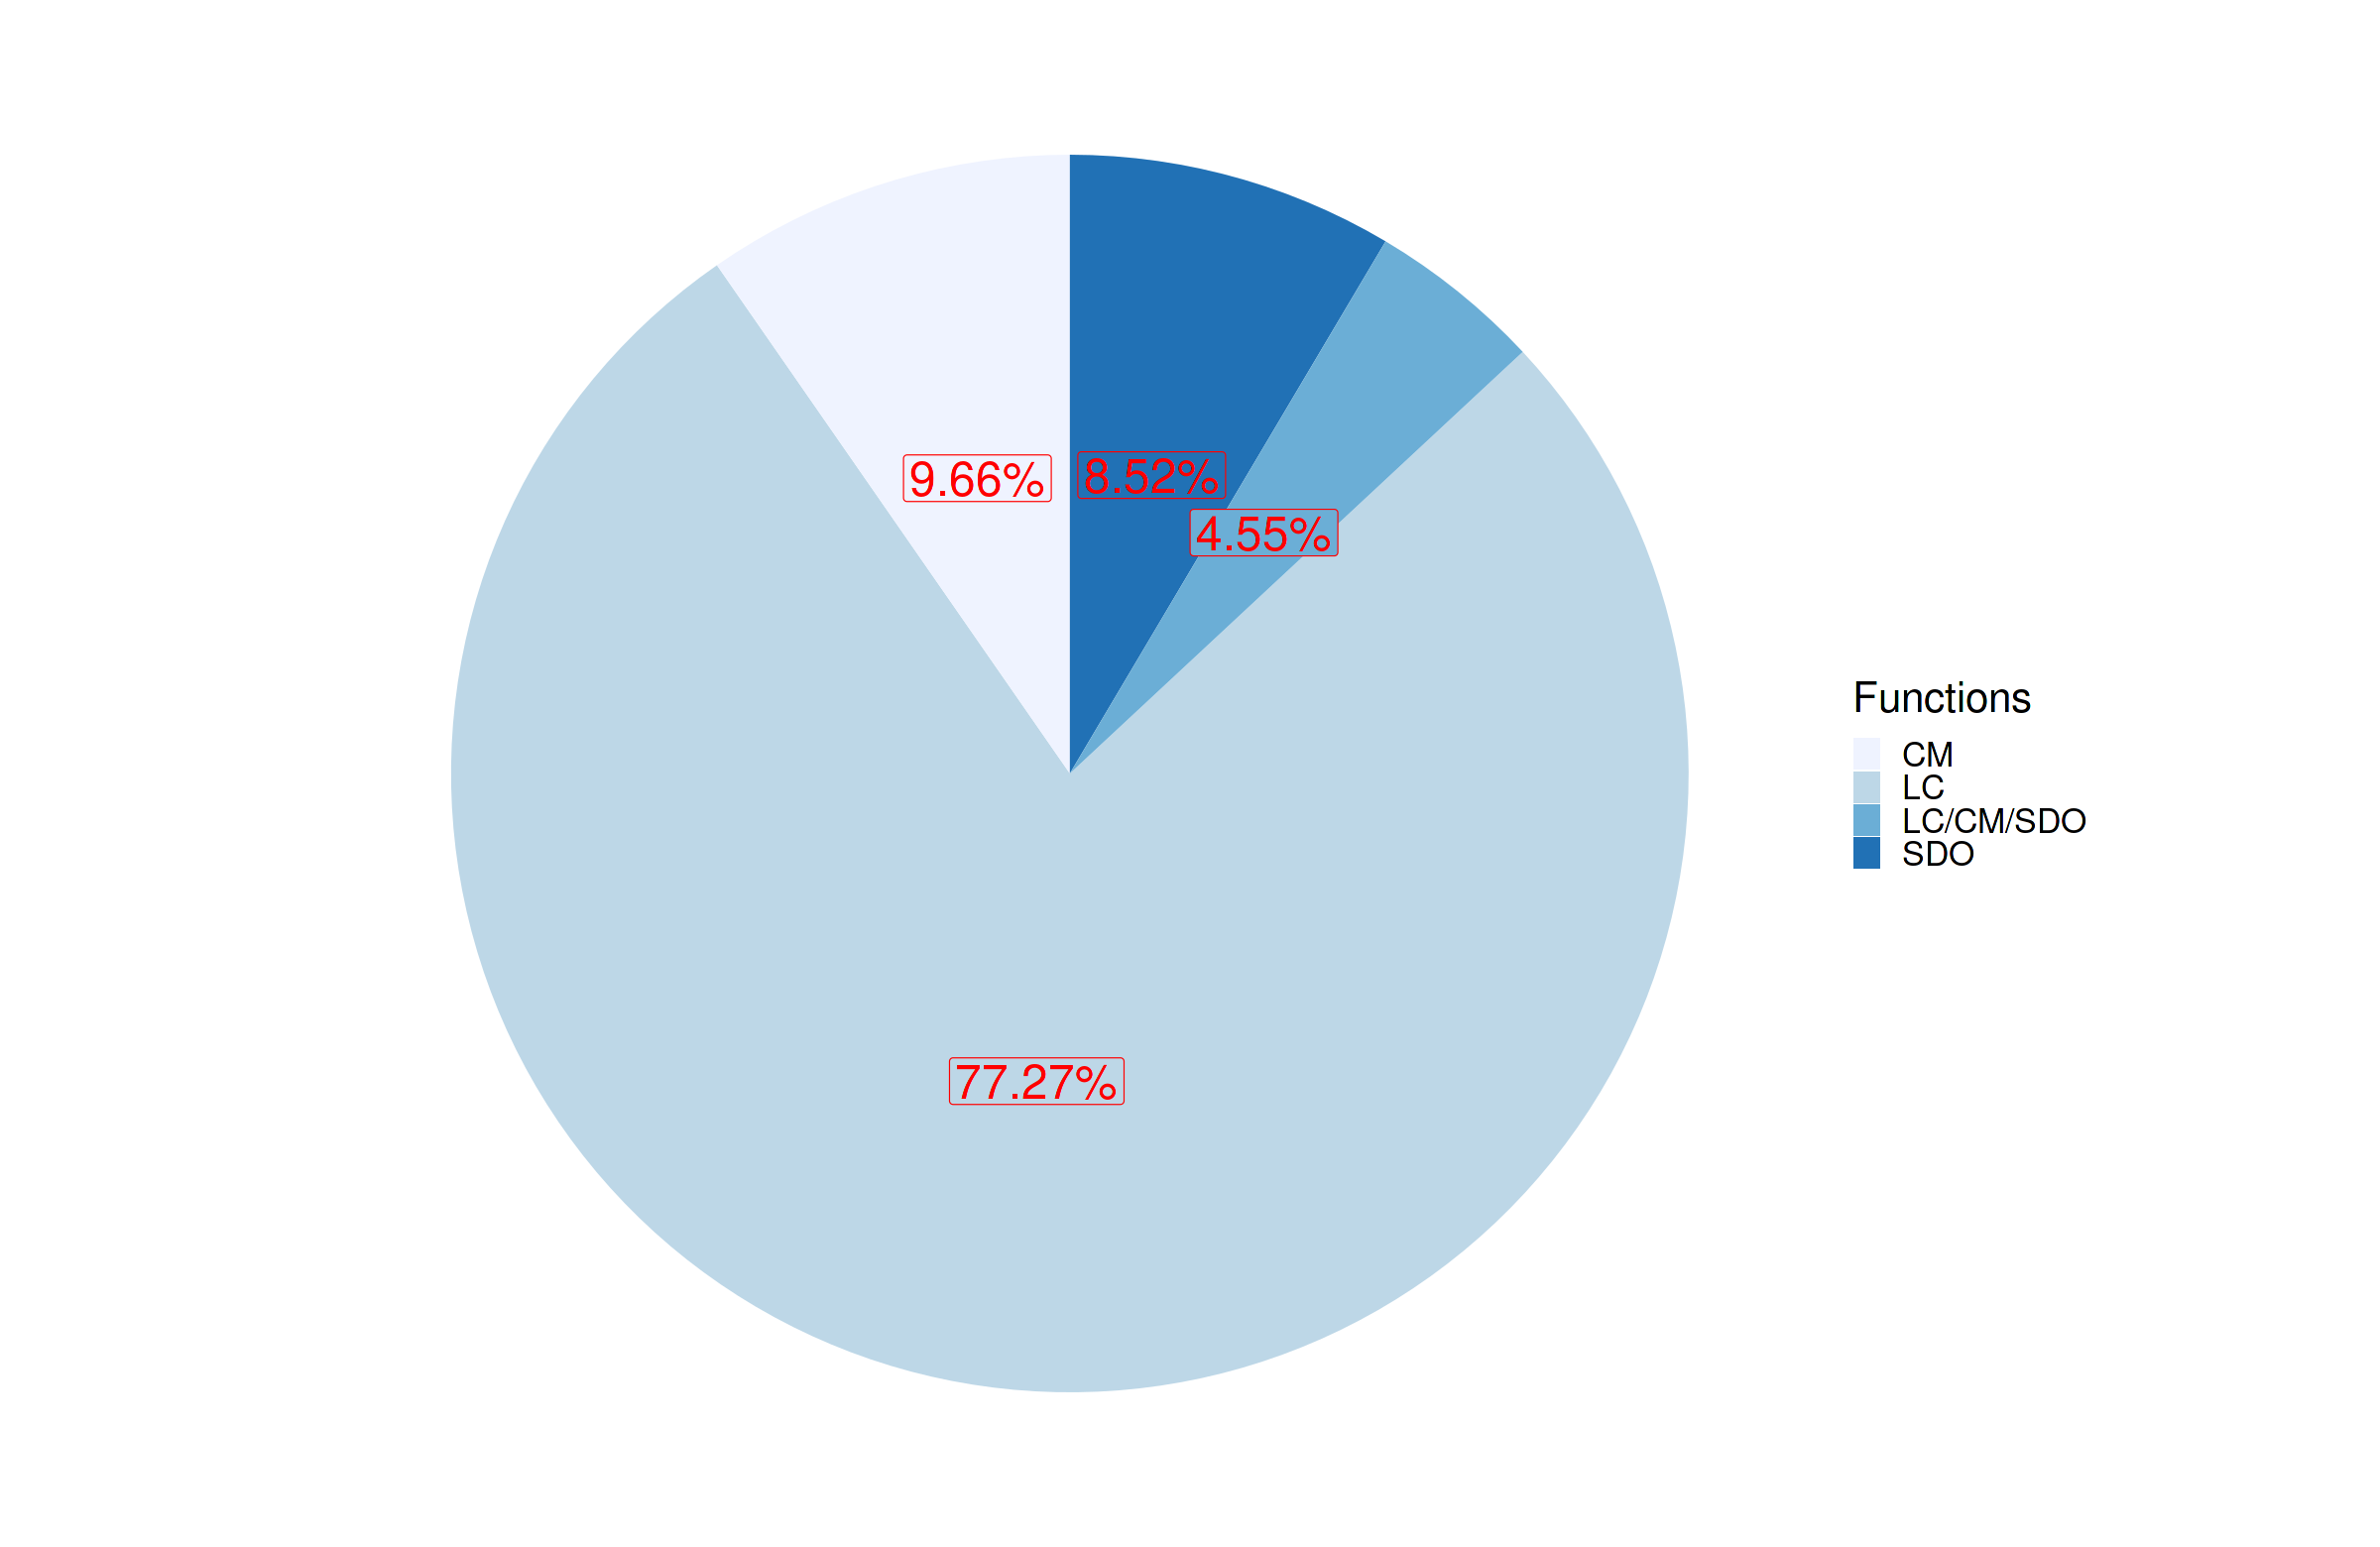

In [ ]:
#visualization of sectors of 327 products
products %>% filter(sector_s!="") %>% 
  group_by(sector_s) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>% 
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=sector_s))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size = 25)+
  geom_label(
    aes(label=perc),
    color='white',
    size=10,
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="Sector(s)"))+
  scale_fill_brewer("Blues")

#Provides of those online products
products %>% filter(provider_company_name!="") %>% 
  group_by(provider_company_name) %>% 
  summarise(count=n()) %>% 
  arrange(desc(count)) %>% head(10) %>% 
  mutate(provider_company_name=fct_reorder(provider_company_name,count)) %>% 
  ggplot(aes(x=provider_company_name,y=count))+
  geom_bar(stat="identity",fill='lightblue')+
  coord_flip()+
  xlab("")+
  geom_text(aes(label=count), vjust=0.5, color="black",
            position = position_dodge(0.9), size=10)+
  theme_minimal(base_size=25)


#function of those online products
products %>% filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
           ) %>% 
  group_by(Functions) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>%
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=Functions))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size = 25)+
  geom_label(
    aes(label=perc),
    color='red',
    size=10,
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="Functions"))+
  scale_fill_brewer("Blues")


### Product Information

There're 327 top popular online products in those district. Most of them are provied by Google LLC, and the next one is Microsoft.

The most prevalent sector(s) of those products is the Prek-12(48.3%), and in contrast, those products with Corporate sector(s) are not so popular in students.

Besides, the functions of those products mainly consist of 4 parts: CM, LC, LC/CM/SDO and SDO. Them LC is the most frequent function of those products.

## Engagement

Engagement data across the year is split by district. We combine all of them and join the products and districts data for a more in-depth exploration.

In [ ]:
#Recoding
districts$minority = as.numeric(recode(districts$pct_black_hispanic, `0-20` = 1, `20-40` = 2, `40-60` = 3, `60-80` = 4, `80-100` = 5))
districts$frl = as.numeric(recode(districts$pct_free_reduced, `0-20` = 1, `20-40` = 2, `40-60` = 3, `60-80` = 4, `80-100` = 5))
districts$expenditure = as.numeric(recode(districts$pp_total_raw, `4000-6000` = 1, `6000-8000` = 2, `8000-10000` = 3, `10000-12000` = 4, `12000-14000` = 5, `14000-16000` = 6, `16000-18000` = 7, `18000-20000` = 8, `20000-22000` = 9, `22000-24000` = 10, `32000-34000` = 11))
districts[1:10,]

district_id state          locale pct_black_hispanic pct_free_reduced
1  8815        Illinois       Suburb 0-20               0-20            
2  2685        NA             NA     NA                 NA              
3  4921        Utah           Suburb 0-20               20-40           
4  3188        NA             NA     NA                 NA              
5  2238        NA             NA     NA                 NA              
6  5987        Wisconsin      Suburb 0-20               0-20            
7  3710        Utah           Suburb 0-20               40-60           
8  7177        North Carolina Suburb 20-40              20-40           
9  9812        Utah           Suburb 0-20               20-40           
10 6584        North Carolina Rural  40-60              60-80           
   county_connections_ratio pp_total_raw minority frl expenditure
1  [0.18, 1[                14000-16000   1        1  6          
2  NA                       10000-12000  NA       NA  4          
3  [0.18, 1[                6000-8000     1        2  2          
4  NA                       10000-12000  NA       NA  4          
5  NA                       10000-12000  NA       NA  4          
6  [0.18, 1[                10000-12000   1        1  4          
7  [0.18, 1[                6000-8000     1        3  2          
8  [0.18, 1[                8000-10000    2        2  3          
9  [0.18, 1[                6000-8000     1        2  2          
10 [0.18, 1[                8000-10000    3        4  3

In [ ]:
#Engagement 
all_files <- list.files(here(input_path, "engagement_data"))

# reading engagement file and adding district id
read_files <- function(x) {
        read_csv(here(input_path, "engagement_data", x) ,show_col_types = FALSE) %>% 
                mutate(district_id = str_remove(x, ".csv"))
}

# loading all engagement data
engagement <- map_dfr(all_files, read_files)

# combining everything into digital learning (dl) dataframe
dl <- engagement %>% 
        left_join(products %>% select(lp_id, product_name, provider_company_name, sector_s, main_fun, sub_fun)) %>% 
        left_join(districts %>% mutate(district_id = as.character(district_id)))


Joining, by = "lp_id"

Joining, by = "district_id"



In [ ]:
#Imputing missing values with mean; ignoring the categorical variables
NA2mean <- function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))
dl <- replace(dl, TRUE, lapply(dl, NA2mean))

Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: retu

### Top 5 products having the highest daily engagement across the year in each of the primary categories

`summarise()` has grouped output by 'main_fun'. You can override using the `.groups` argument.



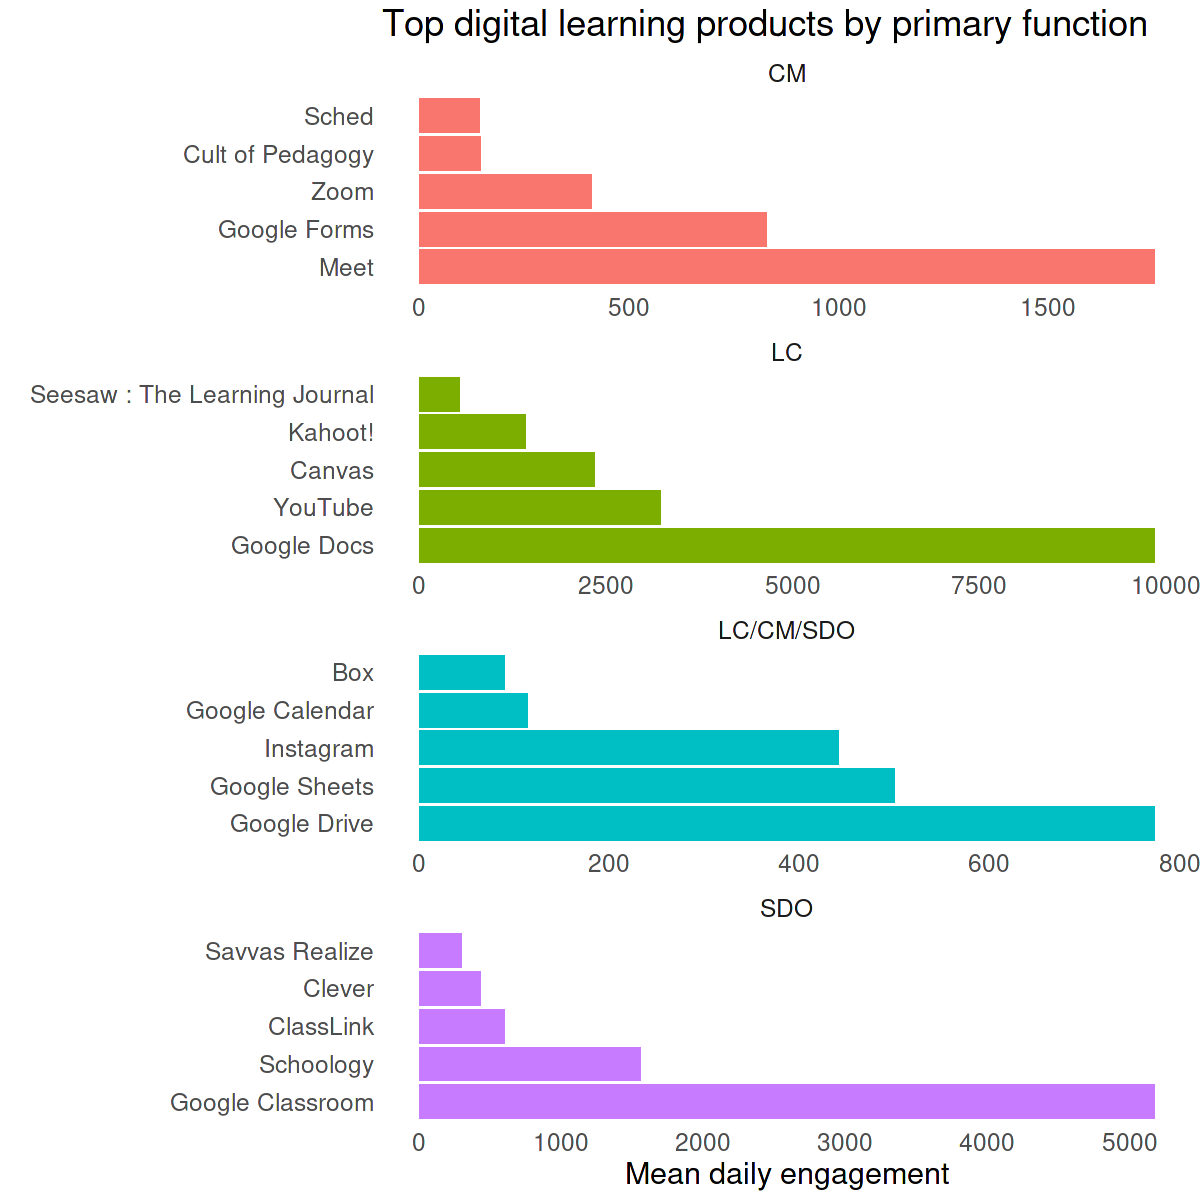

In [ ]:
top_dl <- dl %>% 
        group_by(main_fun, product_name) %>% 
        summarise(eng = mean(engagement_index, na.rm = TRUE)) %>% 
        arrange(main_fun, desc(eng)) %>% 
        slice_max(order_by = eng, n = 5)

options(repr.plot.width = 10, repr.plot.height = 10)
top_dl %>% 
        ungroup() %>% 
        mutate(product_name = factor(product_name),
               product_name = fct_inorder(product_name)) %>% 
        filter(!is.na(main_fun)) %>% 
        ggplot(aes(product_name, eng, fill = main_fun)) +
                geom_col() +
                facet_wrap(~main_fun, scales = "free", ncol = 1) +
                coord_flip() +
                ggtitle("Top digital learning products by primary function") +
                ylab("Mean daily engagement") +
                xlab("") +
                scale_colour_brewer(palette = "Paired")+
                theme(legend.position = "none",
                      text = element_text(size = 18),
                      panel.grid = element_blank())

## Engagement and Student Access Change

In [ ]:
engagement <- replace(engagement, TRUE, lapply(engagement, NA2mean))

Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”


In [ ]:
#Scale data for engagement index and access
engagement$engagement_index_scaled = scale(engagement$engagement_index)
engagement$pct_access_scaled = scale(engagement$pct_access)

tempDistrictsNoInfo = districts %>% filter(is.na(state)) %>% select(district_id)
engagement$no_district_info = ifelse(engagement$district_id %in% tempDistrictsNoInfo$district_id, 1, 0)

engAccessMonthly = engagement %>%
  group_by(
    month = factor(months(time, abbreviate=T), levels = month.abb)
    ) %>% 
  summarise(
    Engagement = mean(engagement_index_scaled, na.rm=T),
    Access = mean(pct_access_scaled, na.rm=T)
  ) %>% 
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month)

districtEngAccessMonthly = districts %>%
  filter(!is.na(state)) %>%
  left_join(
    engagement %>% filter(no_district_info == 0) %>%
      group_by(
        district_id,
        month = factor(months(time, abbreviate=T), levels = month.abb)
      ) %>%
      summarise(
        Engagement = mean(engagement_index_scaled, na.rm=T),
        Access = mean(pct_access_scaled, na.rm=T)
      ),
    by = "district_id"
  ) %>%
  filter(Access <10 & Engagement < 10) #simple outlier filter. could use cookdistance


`summarise()` has grouped output by 'district_id'. You can override using the `.groups` argument.



### Engagement and Student Access Change Over Time in 2020

#### Correlation test between engagement and student access

In [ ]:
df = na.omit(engagement)
corr <- cor.test(df$pct_access, df$engagement_index)
corr


	Pearson's product-moment correlation

data:  df$pct_access and df$engagement_index
t = 5333.8, df = 22324188, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7483629 0.7487277
sample estimates:
      cor 
0.7485453 


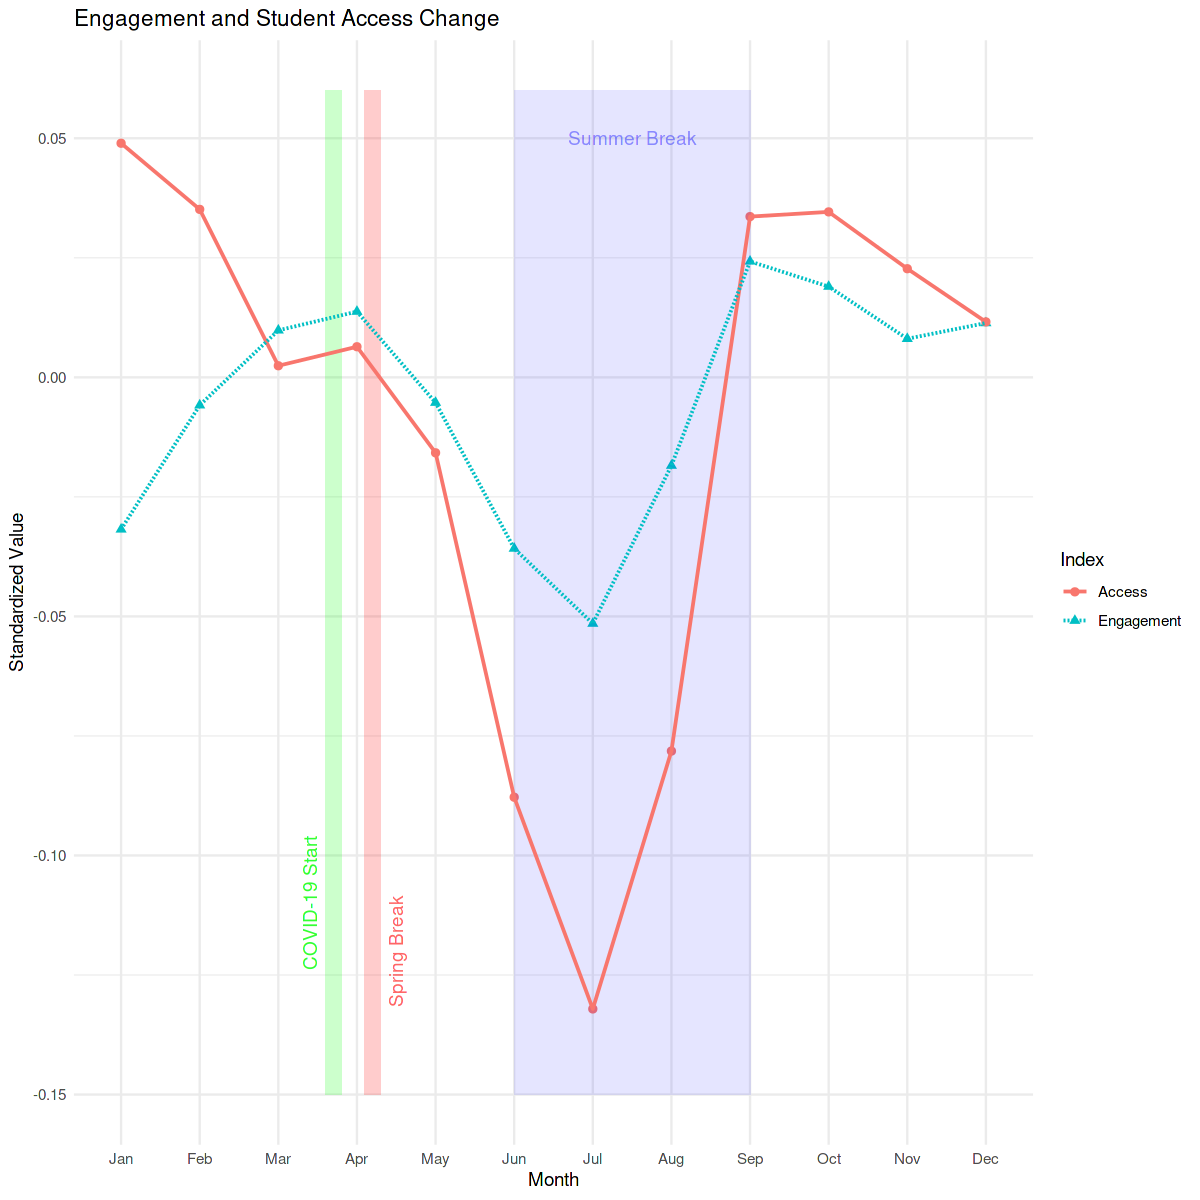

In [ ]:
engAccessMonthly %>% ggplot(aes(x=month, y=Value, color=Index, group=Index))+
  geom_point(aes(shape=Index), size=2)+
  annotate("rect", xmin=3.6,xmax=3.8,ymin=-0.15, ymax=0.06, fill="green", alpha=0.2)+
  annotate("text", x=3.4, y=-0.11, color="green", alpha=0.8, label="COVID-19 Start",  angle = 90)+
  annotate("rect", xmin=4.1,xmax=4.3,ymin=-0.15, ymax=0.06, fill="red", alpha=0.2)+
  annotate("text", x=4.5, y=-0.12, color="red", alpha=0.6, label="Spring Break",  angle = 90)+
  annotate("rect", xmin=6.0,xmax=9.0,ymin=-0.15, ymax=0.06, fill="blue", alpha=0.1)+
  annotate("text", x=7.5, y=0.05, color="blue", alpha=0.4, label="Summer Break")+
  geom_line(aes(linetype=Index), size=0.8)+
  labs(
    title = "Engagement and Student Access Change",
    x = "Month", y = "Standardized Value"
  )
 

In [ ]:
#engage <- replace(engagement, TRUE, lapply(engagement, NA2mean))
engage <- engagement

#Defining the week numbers for each date
weeklyEngAccess <- engage %>% 
  mutate(week = cut.Date(time, breaks = "1 week", labels = FALSE)) %>% 
  arrange(time)
#Weekly average data - Grouping by week
weeklyEngAccess <- weeklyEngAccess %>%
    group_by(week) %>%
    summarize(engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
weeklyEngAccess$date = lubridate::ymd("2020-01-01") + lubridate::weeks(weeklyEngAccess$week - 1)

In [ ]:
str(weeklyEngAccess)

tibble [53 × 4] (S3: tbl_df/tbl/data.frame)
 $ week            : int [1:53] 1 2 3 4 5 6 7 8 9 10 ...
 $ engagement_index: num [1:53] 88.5 121.7 123.9 115.8 124 ...
 $ pct_access      : num [1:53] 0.306 0.679 0.693 0.621 0.691 ...
 $ date            : Date[1:53], format: "2020-01-01" "2020-01-08" ...


### Average Engagement Index in 2020 Across All Districts

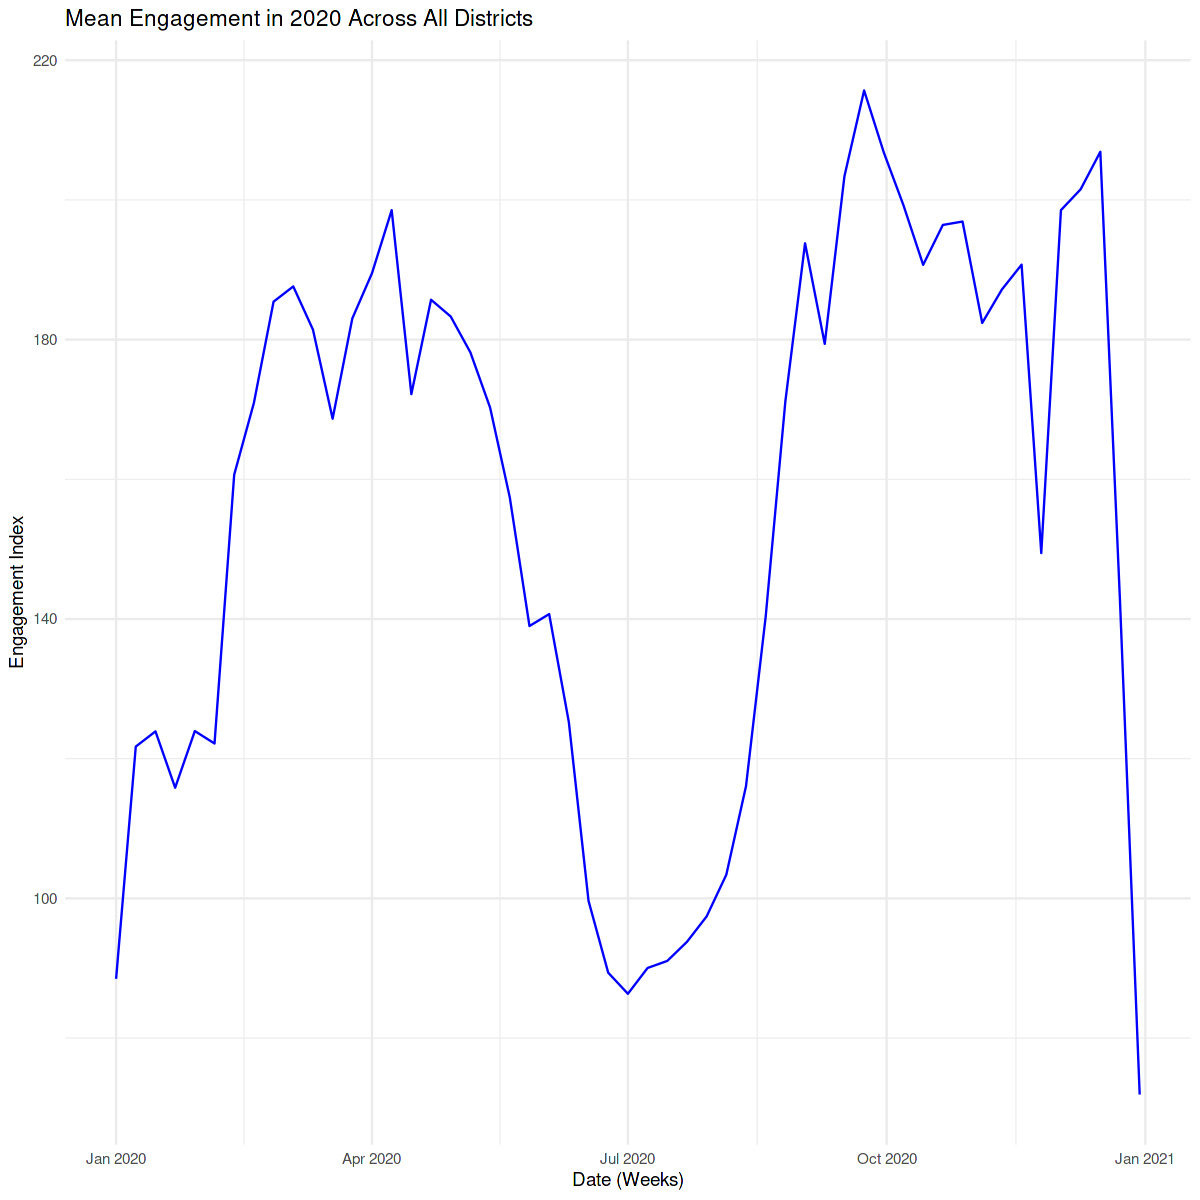

In [ ]:
ggplot(weeklyEngAccess, aes(x=date, y=engagement_index)) + geom_line(aes(group=1), colour = "blue") +
labs(title = "Mean Engagement in 2020 Across All Districts",
    x = "Date (Weeks)", y = "Engagement Index")

### Average Pct Access in 2020 Across All Districts

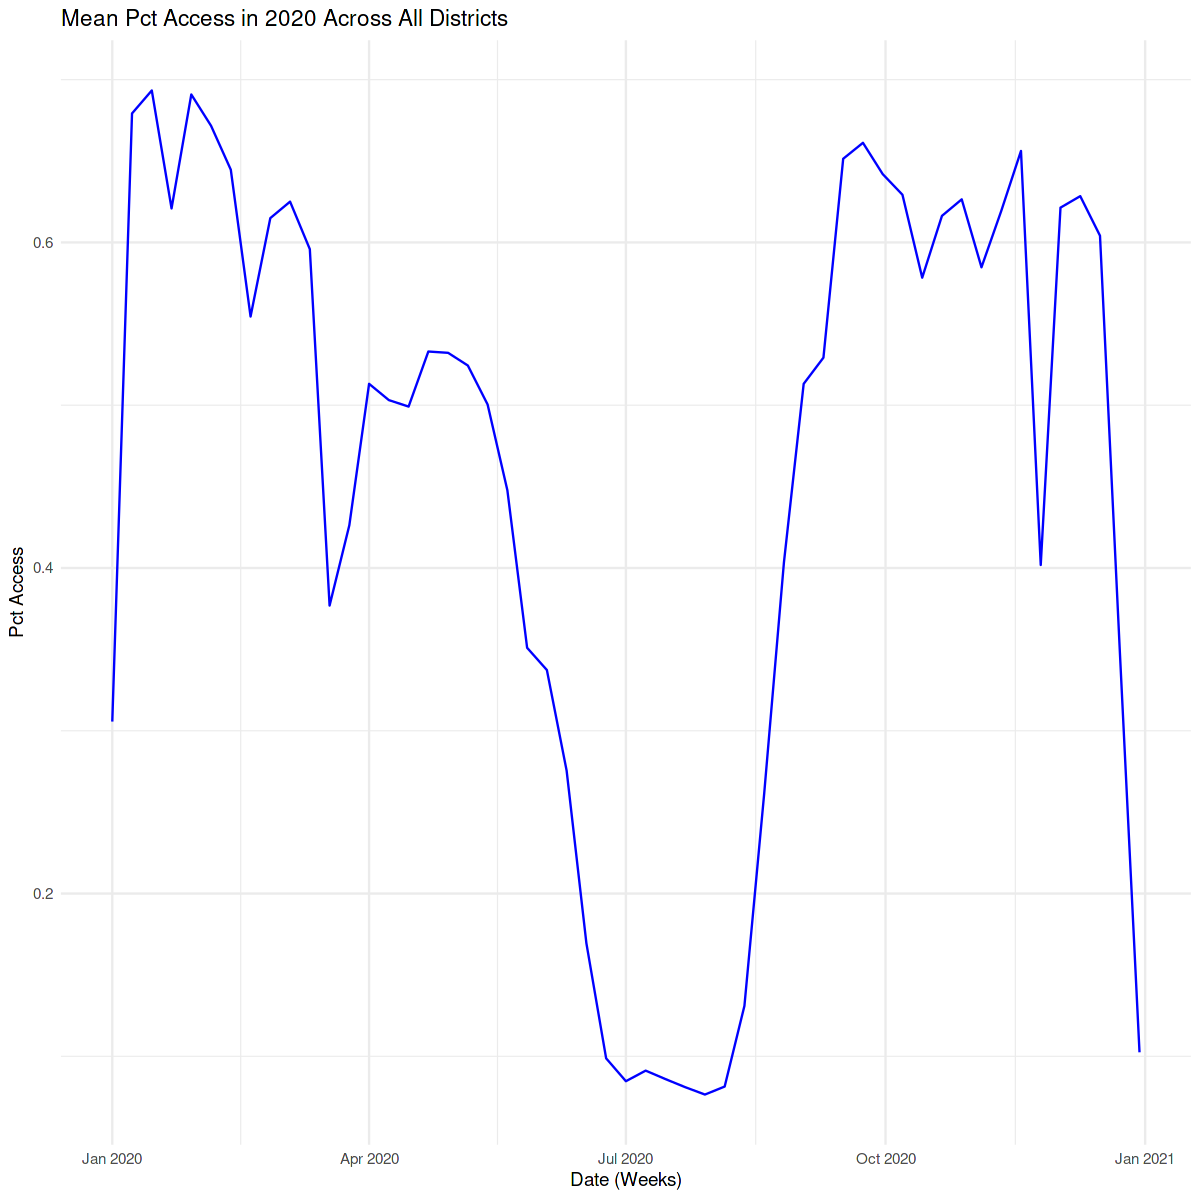

In [ ]:
ggplot(weeklyEngAccess, aes(x=date, y=pct_access)) + geom_line(aes(group=1), colour = "blue") +
labs(title = "Mean Pct Access in 2020 Across All Districts",
    x = "Date (Weeks)", y = "Pct Access")

#### Separating the timeline into early and mid pandemic

In [ ]:
earlyPandemic = subset(weeklyEngAccess, date >= '2020-04-01' & date <='2020-08-10')
midPandemic = subset(weeklyEngAccess, date >= '2020-08-10')

In [ ]:
earlymax3 = head(sort(earlyPandemic$engagement_index, decreasing=TRUE), 3)
midmax3 = head(sort(midPandemic$engagement_index, decreasing=TRUE), 3)

### Engagement change during early and mid pandemic

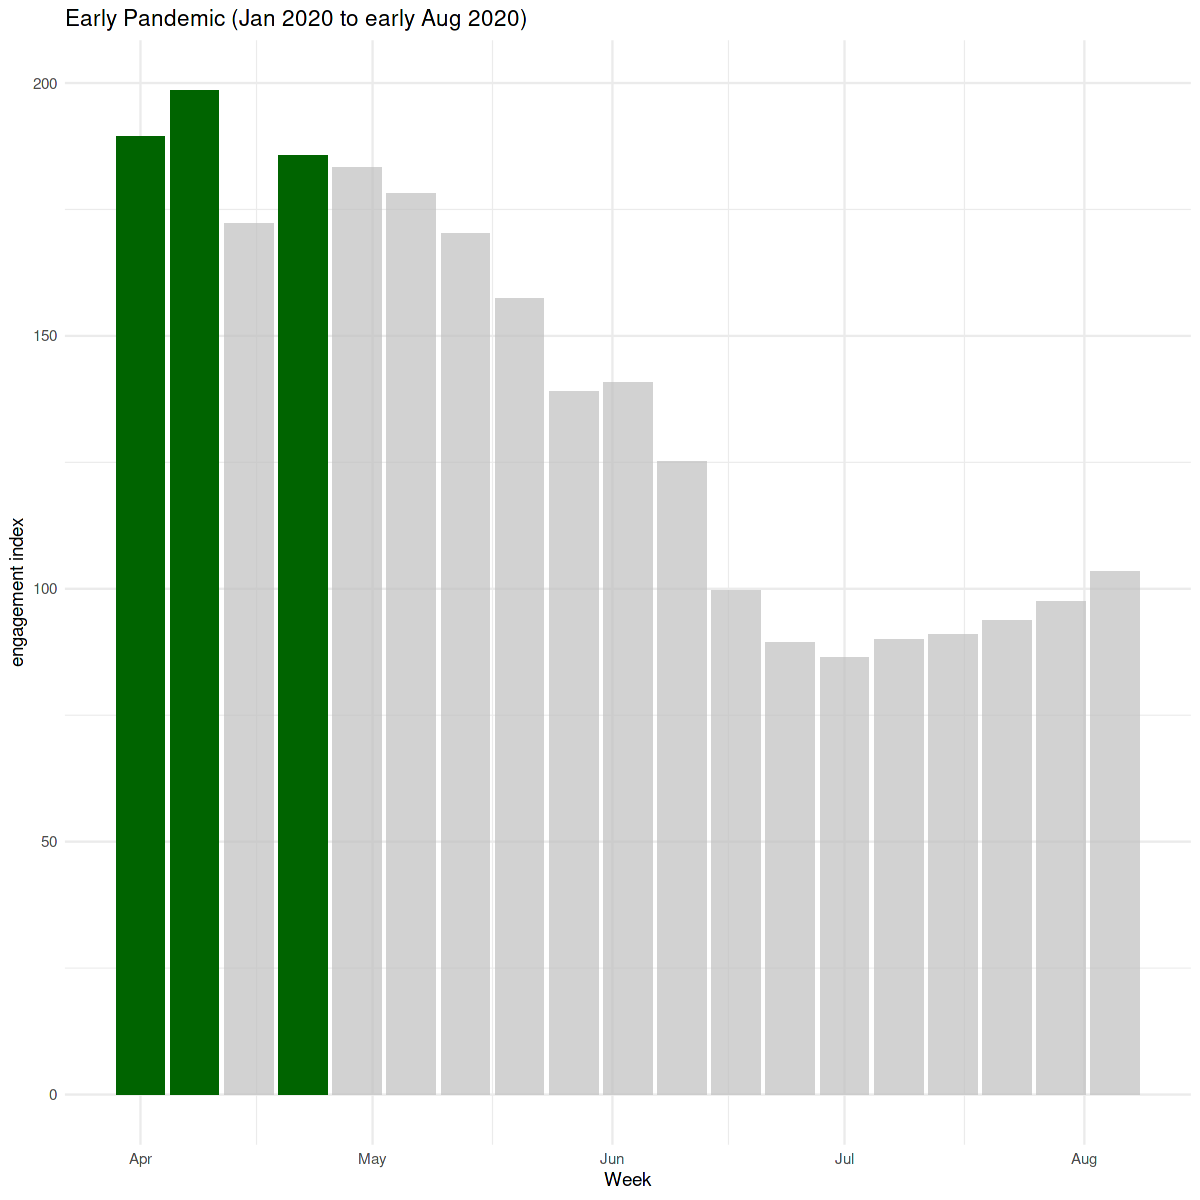

In [ ]:
library(gghighlight)
ggplot(earlyPandemic, aes(x = date, y = engagement_index)) + geom_bar(stat = "identity", fill="darkgreen") +
    labs(x = "Week", y = "engagement index", title = "Early Pandemic (Jan 2020 to early Aug 2020)") +
    gghighlight(engagement_index %in% earlymax3)

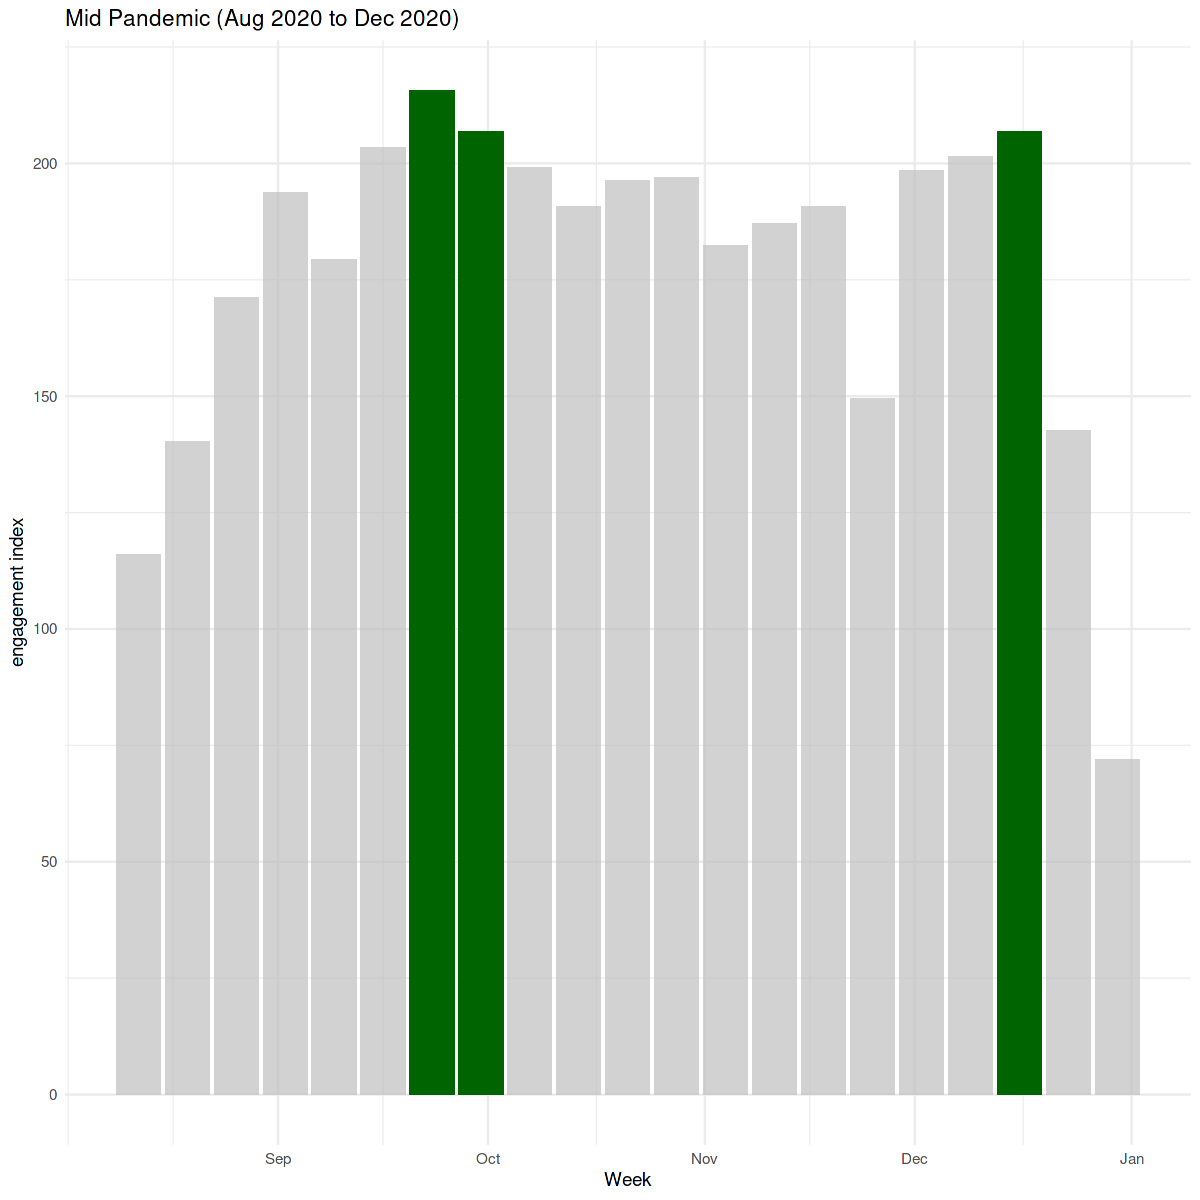

In [ ]:
ggplot(midPandemic, aes(x = date, y = engagement_index)) + geom_bar(stat = "identity", fill="darkgreen") +
    labs(x = "Week", y = "engagement index", title = "Mid Pandemic (Aug 2020 to Dec 2020)") +
    gghighlight(engagement_index %in% midmax3)

#### t-test to check how the engagement and access differ during early and mid pandemic

**Hypothesis test**

**Null Hypothesis:** No difference in means from early and mid pandemic

**Alternate Hypothesis:** The means differ

#### Engagement Index

In [ ]:
t.test(earlyPandemic$engagement_index, midPandemic$engagement_index)


	Welch Two Sample t-test

data:  earlyPandemic$engagement_index and midPandemic$engagement_index
t = -3.4119, df = 35.701, p-value = 0.001618
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -66.60534 -16.93357
sample estimates:
mean of x mean of y 
 136.3699  178.1394 


***We can observe from the statistical test that the engagement index means during the early-pandemic and mid-pandemic differ significantly***

#### Pct Access

In [ ]:
t.test(earlyPandemic$pct_access, midPandemic$pct_access)


	Welch Two Sample t-test

data:  earlyPandemic$pct_access and midPandemic$pct_access
t = -3.5841, df = 36.168, p-value = 0.0009905
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.32927449 -0.09131617
sample estimates:
mean of x mean of y 
0.3045290 0.5148243 


***We can observe from the statistical test that the pct access means during the early-pandemic and mid-pandemic differ significantly***

## Engagement and Access Change Across Districts

`summarise()` has grouped output by 'locale'. You can override using the `.groups` argument.



<ggproto object: Class FacetWrap, Facet, gg>
    compute_layout: function
    draw_back: function
    draw_front: function
    draw_labels: function
    draw_panels: function
    finish_data: function
    init_scales: function
    map_data: function
    params: list
    setup_data: function
    setup_params: function
    shrink: TRUE
    train_scales: function
    vars: function
    super:  <ggproto object: Class FacetWrap, Facet, gg>

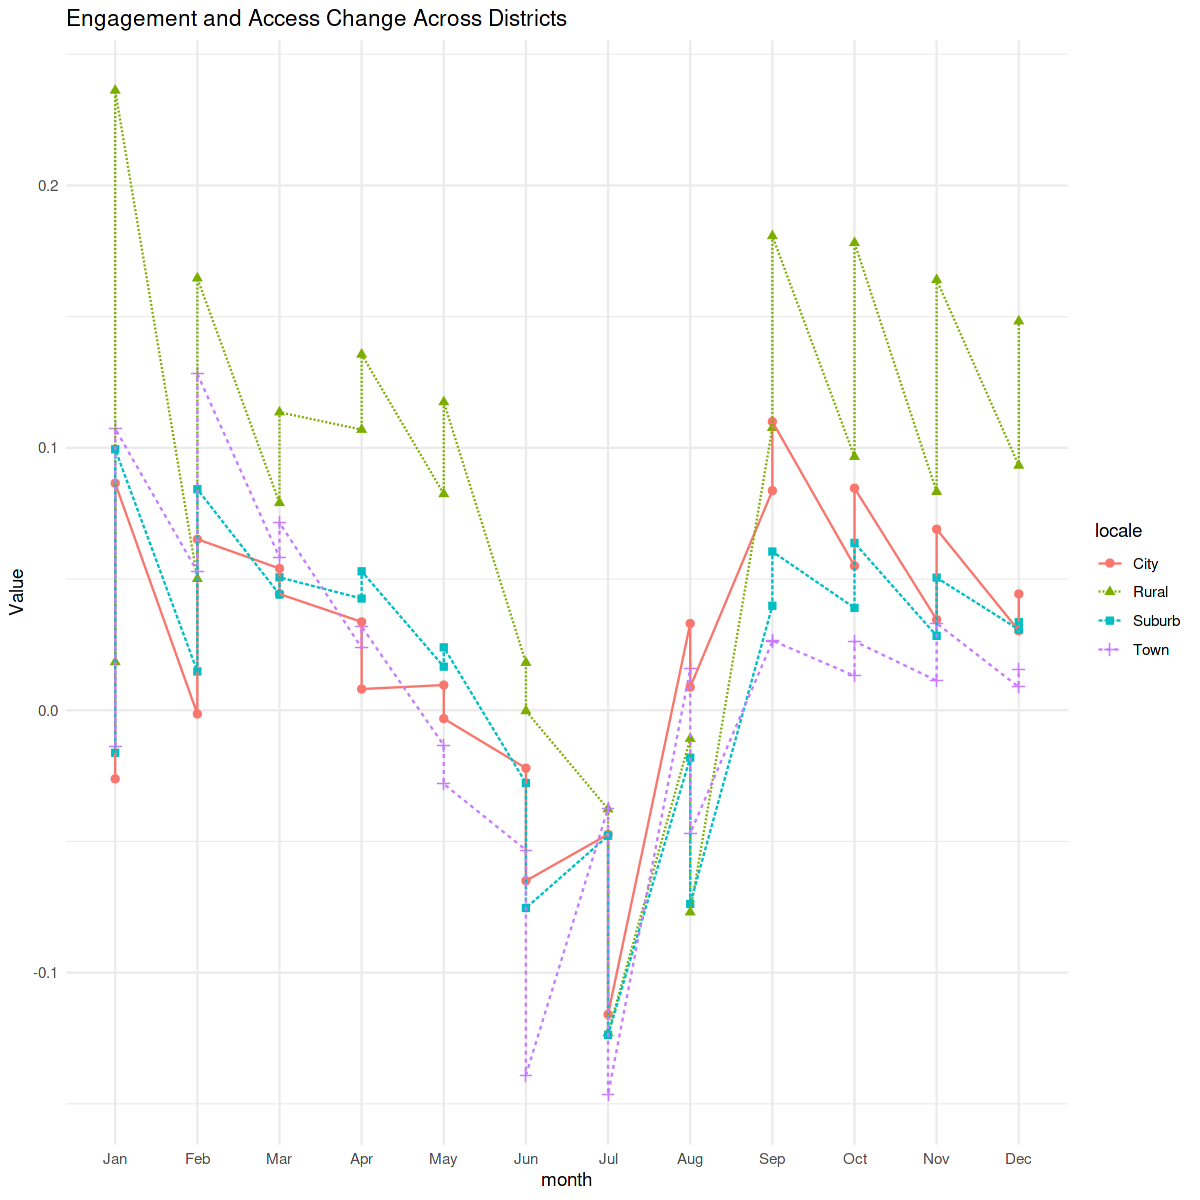

In [ ]:
districtEngAccessMonthly %>% 
  group_by(locale, month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=locale, group=locale))+
  geom_point(aes(shape=locale), size=2)+
  geom_line(aes(linetype=locale))+
labs(
    title = "Engagement and Access Change Across Districts",
  )
  facet_wrap(~Index, ncol=1)

## Engagement and Access Change by Demographics¶

### Engagement and Access Change by by Minority Level (Black/Hispanics)

`summarise()` has grouped output by 'MinorityLevel'. You can override using the `.groups` argument.



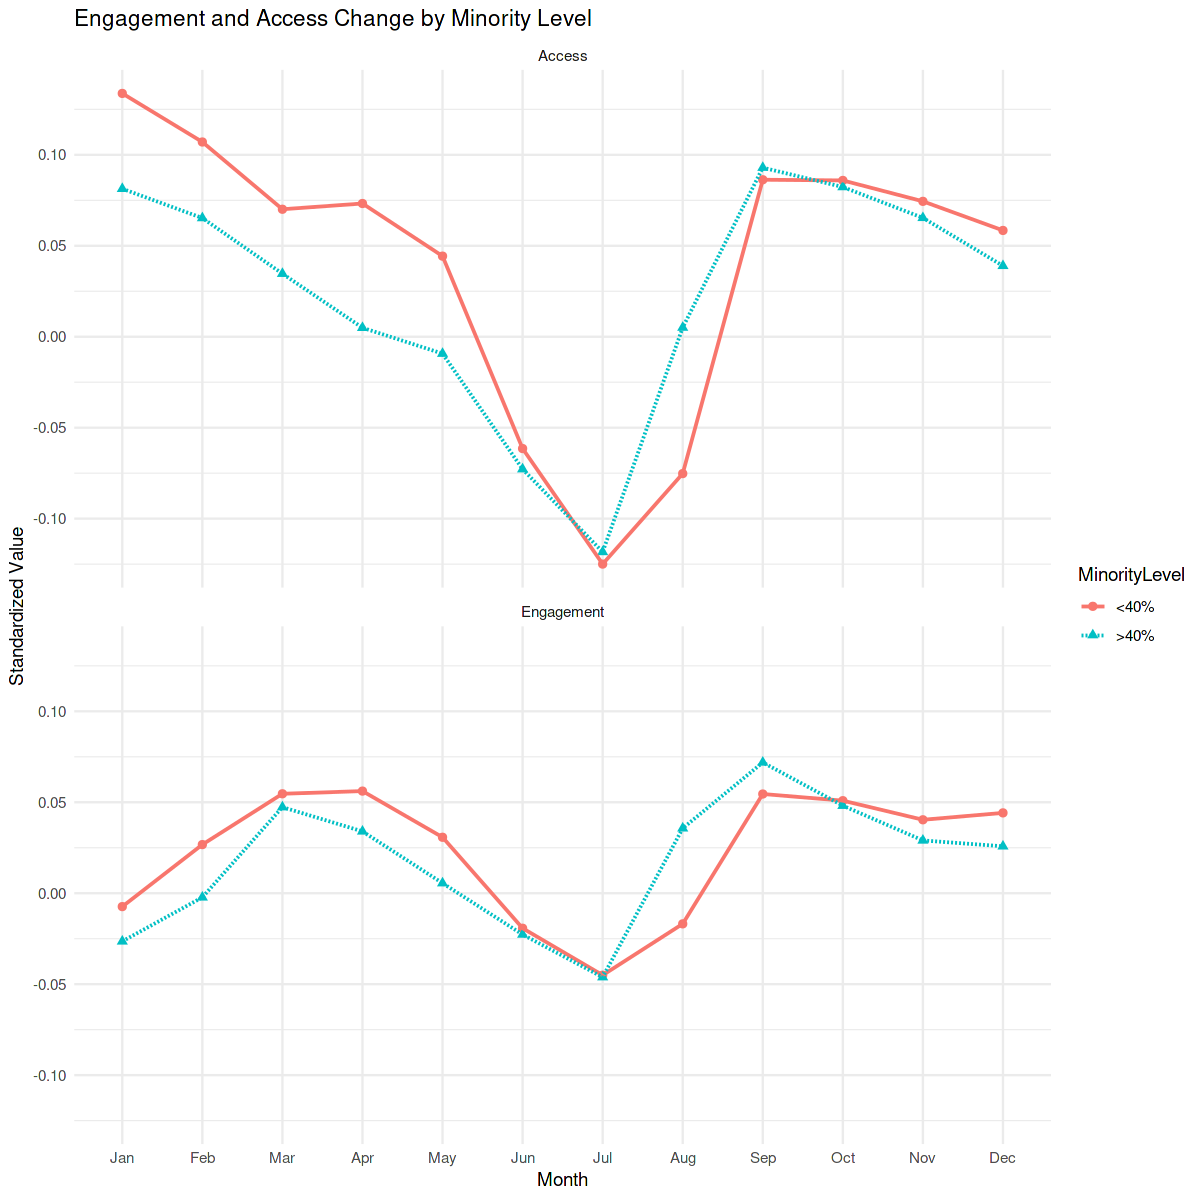

In [ ]:
districtEngAccessMonthly %>% 
  group_by(MinorityLevel = ifelse(minority>2, ">40%", "<40%"), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T),
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=MinorityLevel, group=MinorityLevel))+
  geom_point(aes(shape=MinorityLevel), size=2)+
  geom_line(aes(linetype=MinorityLevel), size=0.8)+
  labs(
    title = "Engagement and Access Change by Minority Level",
    y = "Standardized Value", x="Month"
  )+
  facet_wrap(~Index, ncol=1)

### Engagement and Access Change by Free/Reduced Lunch

`summarise()` has grouped output by 'Free_Reduced_Lunch'. You can override using the `.groups` argument.



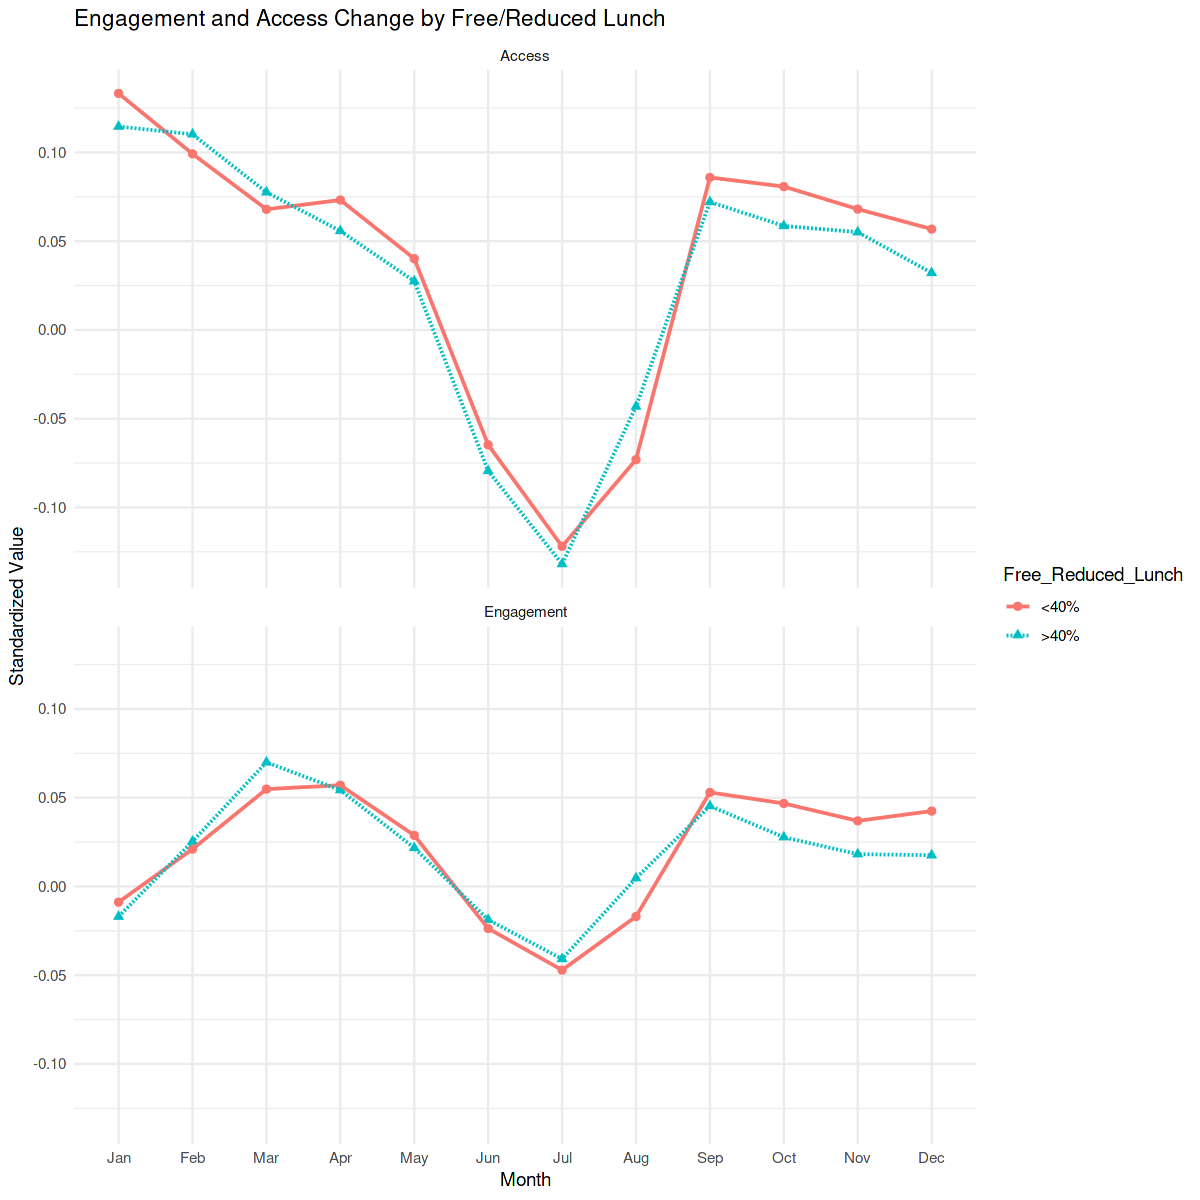

In [ ]:
districtEngAccessMonthly %>% 
  filter(!is.na(frl)) %>%
  group_by(Free_Reduced_Lunch = ifelse(frl>2, ">40%", "<40%"), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Free_Reduced_Lunch, group=Free_Reduced_Lunch))+
  geom_point(aes(shape=Free_Reduced_Lunch), size=2)+
  geom_line(aes(linetype=Free_Reduced_Lunch), size=0.8)+
  labs(
    title = "Engagement and Access Change by Free/Reduced Lunch",
    y = "Standardized Value", x="Month"
  )+
  facet_wrap(~Index, ncol=1)

# Engagement and Access Change by Internet Access (Connectivity/ Device Access)

The U.S. Census Bureau (2020) Household Pulse Survey (data collected between December 9th and December 21st) covers many aspects of education during the pandemic, including household connectivity and device availability. Below we will bump the Learn Platform Engagement data against the survey data, at the state level, to get a general idea of how device and internet access relates to engagement in digital learning. Specifically we capture Spearman r correlations for states in the Learn Platform dataset, ranked on mean engagement index and pct access, to the state rankings for each category in the survey.

In [ ]:
availability=read.csv("../input/device-internet-availability/DeviceInternetAvailable.csv")
cols <- c('state', 'total', 'Device_always', 'Device_usually', 'Device_sometimes',
     'Device_rarely', 'Device_never', 'Device_DNR','Internet_always', 'Internet_usually',
      'Internet_sometimes', 'Internet_rarely', 'Internet_never','Internet_DNR')
names(availability)=cols

In [ ]:
head(availability)

state                total   Device_always Device_usually Device_sometimes
1 Arizona              1117445  857024       139565          67043          
2 District Of Columbia   75115   62888        11485            101          
3 California           6773206 5373706       788188         221597          
4 Connectictut          687938  595561        58198          15986          
5 Florida              3186463 2082956       598379         121675          
6 Masssachusetts       1175895  926071       157779          68889          
  Device_rarely Device_never Device_DNR Internet_always Internet_usually
1 23156           2068        28589      777755          252318         
2     0              0          640       61442            7876         
3 25231         226534       137951     4685065         1378531         
4  2848              0        15345      519131          128230         
5 78143         183923       121387     2276327          535435         
6  1089          12672         9396      903299          162443         
  Internet_sometimes Internet_rarely Internet_never Internet_DNR
1  49985               4784            2068          30535      
2   2771               1228               0           1797      
3 176565             117011          222357         193677      
4  20656               1640               0          18281      
5 131873               6404           83491         152934      
6  67872               3337           11474          27469

In [ ]:
#Correcting Connecticut's and Massachusetts spelling
availability$state <- gsub("Connectictut", "Connecticut", availability$state)
availability$state <- gsub("Masssachusetts", "Massachusetts", availability$state)

Below is an image that defines the different categories of device/internet availability:
![image.png](attachment:3e8c66c8-bc42-4239-9603-e6691609fe4f.png)

In [ ]:
sapply(availability, function(x) sum(is.na(x))) #No missing values

state              total      Device_always     Device_usually 
                 0                  0                  0                  0 
  Device_sometimes      Device_rarely       Device_never         Device_DNR 
                 0                  0                  0                  0 
   Internet_always   Internet_usually Internet_sometimes    Internet_rarely 
                 0                  0                  0                  0 
    Internet_never       Internet_DNR 
                 0                  0

In [ ]:
engg <- map_dfr(all_files, read_files)
state_eng <- engg %>%
    left_join(districts)    
state_eng <- state_eng %>%
    group_by(state) %>%
    summarize(Count = n(), 
             engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
state_eng <- na.omit(state_eng)

Joining, by = "district_id"



In [ ]:
# 5 States with the fewest observations in the data
state_eng_lowest = head(state_eng[order(state_eng$Count),], 5)
state_eng_lowest

state                Count  engagement_index pct_access
1 North Dakota           1607 423.0026         3.3239826 
2 Arizona               28135 740.7881         2.0787848 
3 Minnesota             29694 160.8334         0.5077905 
4 New Hampshire         81736 328.0085         1.1691457 
5 District Of Columbia 147500 261.3977         1.1116998

The counts for North Dakota and Arizona are very low and the Engagement Index score is elevated; in combination, this suggests that the mean scores for these states may have been affected by inadequate data sampling. Hence, their data is not included in this analysis, and subsequent analysis involving state mean engagement measure scores will also not include North Dakota and Arizona.

With these states excluded, below are the correlations between the ranked percentage of responses in each state within categories and state mean scores on the engagement index and pct access variables.

In [ ]:
state_eng = subset(state_eng, state!="Arizona" & state!="North Dakota") #Removing the states
state_eng_avail <- state_eng %>%
    left_join(availability, by="state")
head(state_eng_avail)

state                Count   engagement_index pct_access total  
1 California           1308688 113.33066        0.3174664  6773206
2 Connecticut          2549351 257.45642        0.7184759   687938
3 District Of Columbia  147500 261.39766        1.1116998    75115
4 Florida               264735  64.08806        0.2187761  3186463
5 Illinois             2352410 200.54459        0.5840720  1938084
6 Indiana               651353 221.99098        0.7128983   992214
  Device_always Device_usually Device_sometimes Device_rarely Device_never
1 5373706       788188         221597           25231         226534      
2  595561        58198          15986            2848              0      
3   62888        11485            101               0              0      
4 2082956       598379         121675           78143         183923      
5 1574314       188997          79818               0           4267      
6  717351       188138          59556            6274           3505      
  Device_DNR Internet_always Internet_usually Internet_sometimes
1 137951     4685065         1378531          176565            
2  15345      519131          128230           20656            
3    640       61442            7876            2771            
4 121387     2276327          535435          131873            
5  90687     1447994          347185           30815            
6  17390      787337          113950           39506            
  Internet_rarely Internet_never Internet_DNR
1 117011          222357         193677      
2   1640               0          18281      
3   1228               0           1797      
4   6404           83491         152934      
5  14966            4267          92857      
6  30365             955          20101

### Correlation test (Spearman's r and Kendall's tau-b)

Checking the correlation between internet/device access and engagement_index and pct_access

In [ ]:
mean_eng = state_eng_avail$engagement_index
mean_pct = state_eng_avail$pct_access
state_eng_avail <- subset(state_eng_avail, select=-c(engagement_index, pct_access))

In [ ]:
spreng <- c(cor.test(state_eng_avail$Device_always, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_usually, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_sometimes, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_rarely, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_never, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_DNR, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_always, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_usually, mean_eng, method="spearman")$estimate,
            cor.test(state_eng_avail$Internet_sometimes, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_rarely, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_never, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_DNR, mean_eng, method="spearman",exact=FALSE)$estimate
            )
sprpct <- c(cor.test(state_eng_avail$Device_always, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_usually, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_sometimes, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_rarely, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_never, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_DNR, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_always, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_usually, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_sometimes, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_rarely, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_never, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_DNR, mean_pct, method="spearman",exact=FALSE)$estimate
            )
cats = c('Device_always', 'Device_usually', 'Device_sometimes', 'Device_rarely', 'Device_never',
         'Device_DNR', 'Internet_always', 'Internet_usually', 'Internet_sometimes', 'Internet_rarely', 'Internet_never',
        'Internet_DNR')
state_eng_avail_results <- data.frame(cats, spreng, sprpct)
names(state_eng_avail_results) <- c('Variable', 'Spearman r (engagement_index)',
                                    'Spearman r (pct_access)')
state_eng_avail_results

Variable           Spearman r (engagement_index) Spearman r (pct_access)
1  Device_always      -0.3948052                    -0.4246753             
2  Device_usually     -0.3935065                    -0.3337662             
3  Device_sometimes   -0.5844156                    -0.5584416             
4  Device_rarely      -0.5621035                    -0.5294231             
5  Device_never       -0.4841042                    -0.4387810             
6  Device_DNR         -0.2948052                    -0.2480519             
7  Internet_always    -0.3441558                    -0.3649351             
8  Internet_usually   -0.4675325                    -0.4662338             
9  Internet_sometimes -0.5779221                    -0.5675325             
10 Internet_rarely    -0.5648238                    -0.5615665             
11 Internet_never     -0.3400054                    -0.2513659             
12 Internet_DNR       -0.4558442                    -0.4662338

***These correlational results support the assumption that without an adequate device or Internet connectivity, there can be no engagement in digital learning.***

### Engagement and Access by Expenditure per Pupil

`summarise()` has grouped output by 'Expenditure'. You can override using the `.groups` argument.



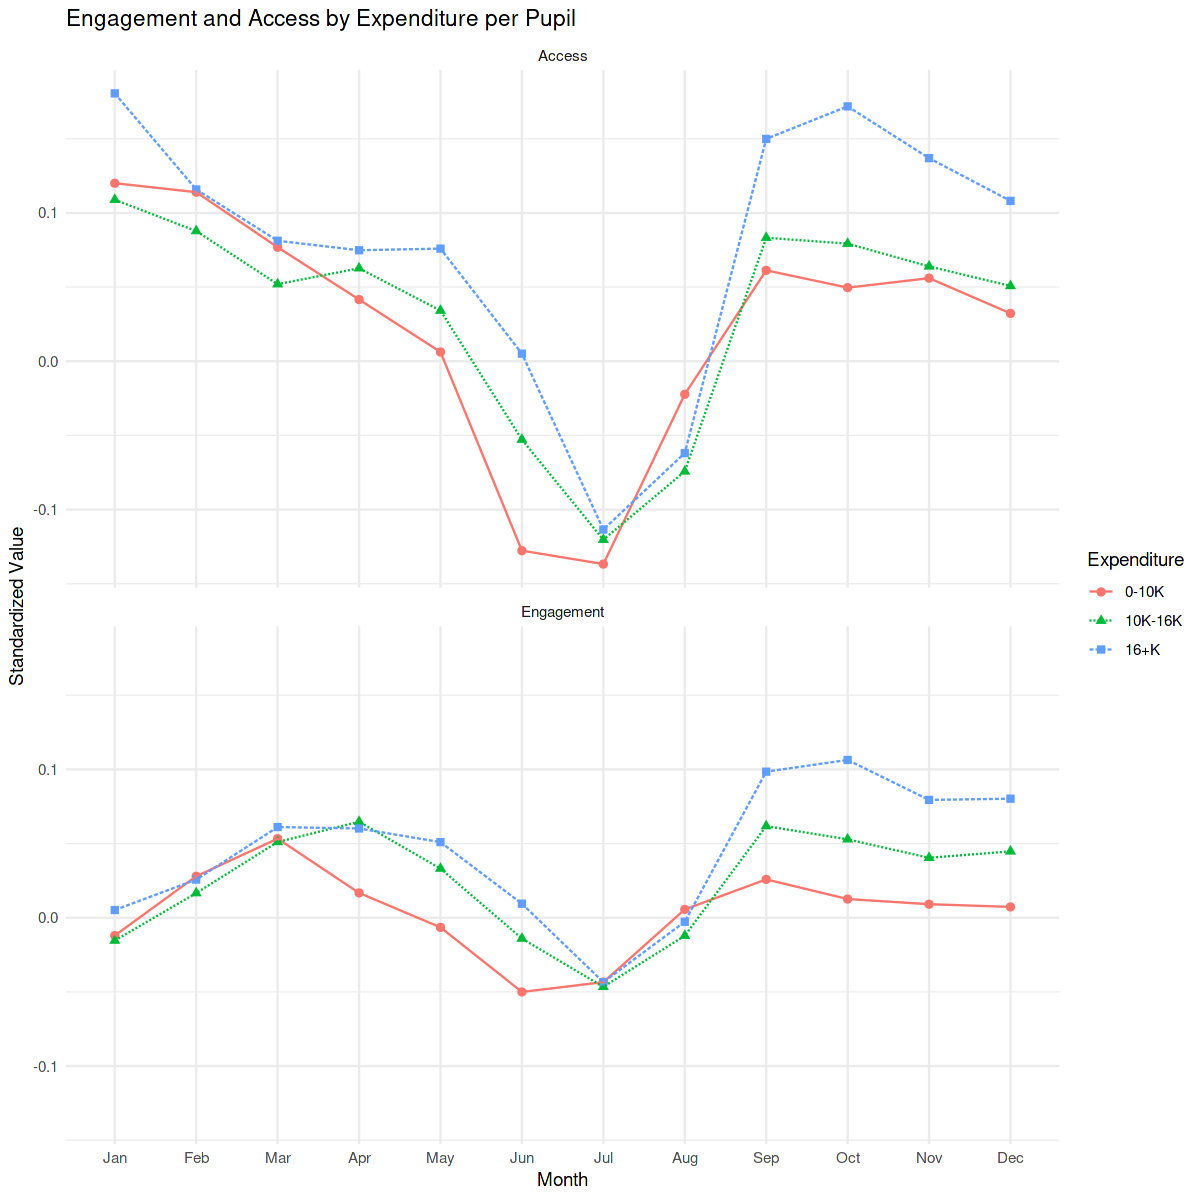

In [ ]:
expndLevelsSimple = c("1" = "0-10K", "2"="0-10K", "3" ="0-10K", "4" ="10K-16K",
              "5"="10K-16K", "6"="10K-16K", "7"="16+K", "8"="16+K",
              "9"="16+K", "10" ="16+K", "11"="16+K")

districtEngAccessMonthly %>%
  filter(!is.na(expenditure)) %>%
  group_by(Expenditure = recode_factor(expenditure, !!!expndLevelsSimple), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Expenditure, group=Expenditure))+
  geom_point(aes(shape=Expenditure), size=2)+
  geom_line(aes(linetype=Expenditure))+
  labs(
    title = "Engagement and Access by Expenditure per Pupil",
    x = "Month", y="Standardized Value"
  )+
  facet_wrap(~Index, ncol=1)

## Engagement and Access Change Across Products

### Engagement and Access by Product Category

`summarise()` has grouped output by 'lp_id'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'main_fun'. You can override using the `.groups` argument.



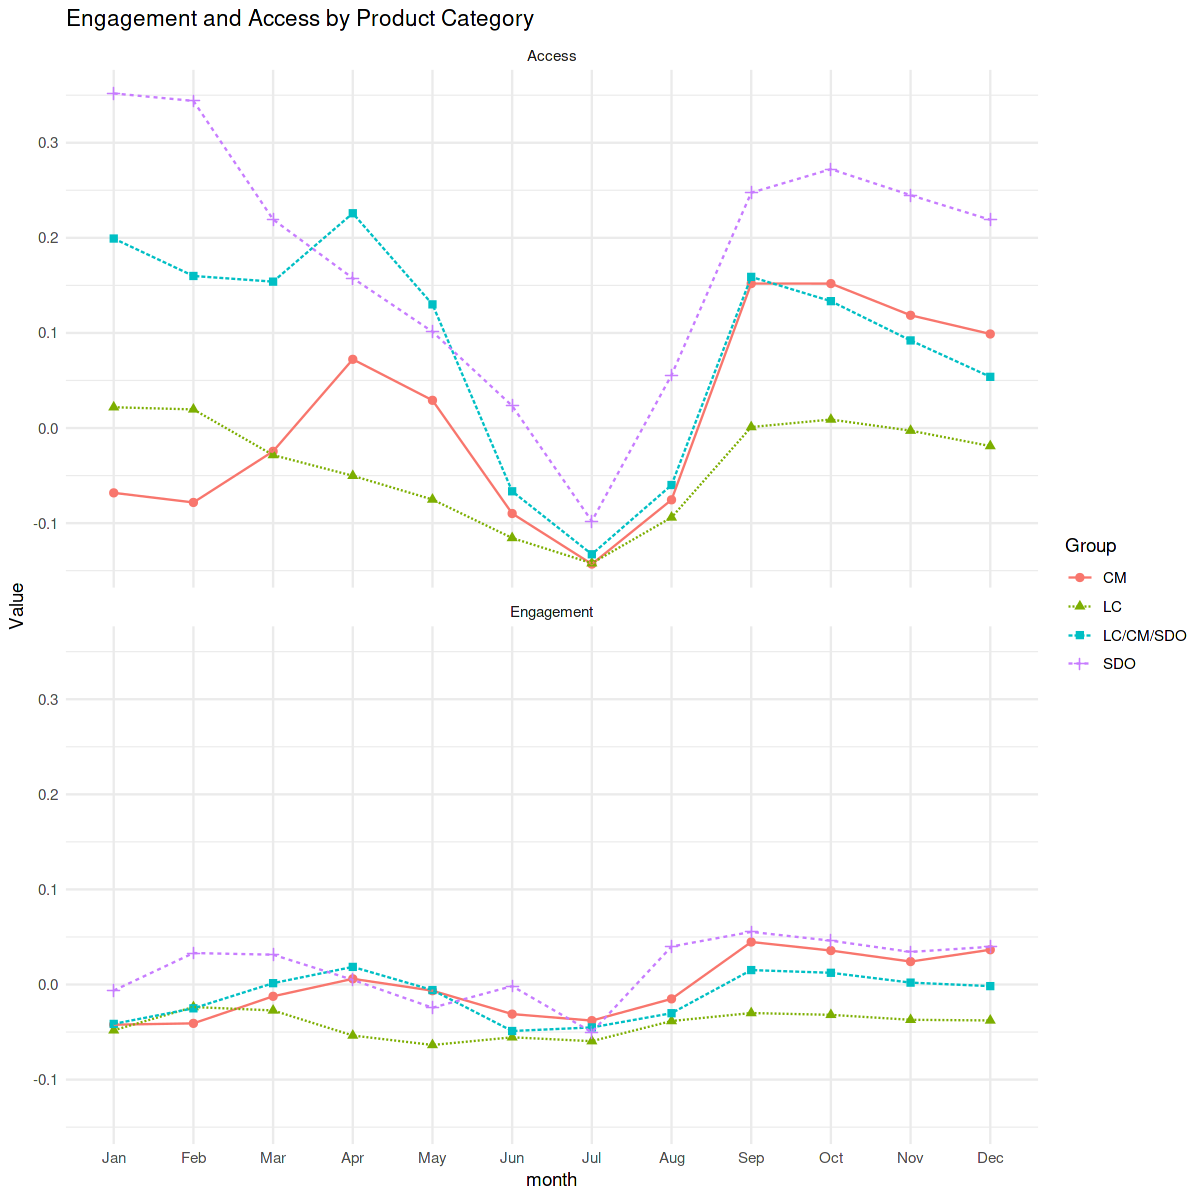

In [ ]:
productEngAccessMonthly = products %>%
  left_join(
    engagement %>% filter(!is.na(lp_id)) %>%
      group_by(
        lp_id,
        month = factor(months(time, abbreviate=T), levels = month.abb)
      ) %>%
      summarise(
        eng = mean(engagement_index_scaled, na.rm=T),
        access = mean(pct_access_scaled, na.rm=T),
        size = n()
      ),
    by = "lp_id"
  ) %>%
  filter(eng < 5 & access < 5)

productEngAccessMonthly %>% 
  filter(!is.na(main_fun)) %>%
  group_by(main_fun, month) %>%
  summarise(
    Engagement = mean(eng, na.rm=T),
    Access = mean(access, na.rm=T),
    size = mean(size, na.rm =T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  mutate(Group = main_fun) %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Group, group=Group))+
  geom_point(aes(shape=Group), size=2)+
  geom_line(aes(linetype=Group))+
  theme(legend.position = "right")+
  labs(
    title="Engagement and Access by Product Category"
  )+
  facet_wrap(~Index, ncol=1, nrow = 2)

# Most popular tools

In [ ]:
head(dl)
ep_dl <- dl %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name) %>% dplyr::summarise(cnt_id=n(), .groups="drop") %>% 
  arrange(desc(cnt_id)) %>% filter(!is.na(product_name)) 
ep_top20 <- ep_dl %>% select(provider_company_name, product_name, lp_id) %>% head(20)

time       lp_id pct_access engagement_index district_id product_name  
1 2020-01-01 93690 0.00       167.6063         1000        Calculator.com
2 2020-01-01 17941 0.03         0.9000         1000        Kids A-Z      
3 2020-01-01 65358 0.03         1.2000         1000        Prezi         
4 2020-01-01 98265 0.57        37.7900         1000        Quizlet       
5 2020-01-01 59257 0.00       167.6063         1000        Issuu         
6 2020-01-01 90153 0.06         3.9000         1000        Netflix       
  provider_company_name sector_s                      main_fun
1 Calculator.com        PreK-12; Higher Ed; Corporate LC      
2 Lazel Inc.            PreK-12                       LC      
3 Prezi Inc.            PreK-12; Higher Ed; Corporate LC      
4 Quizlet               PreK-12                       LC      
5 Issuu                 PreK-12; Higher Ed; Corporate LC      
6 Netflix               PreK-12; Higher Ed; Corporate LC      
  sub_fun                                           state       locale
1 Sites, Resources & Reference                      Connecticut Suburb
2 Digital Learning Platforms                        Connecticut Suburb
3 Content Creation & Curation                       Connecticut Suburb
4 Study Tools                                       Connecticut Suburb
5 Content Creation & Curation                       Connecticut Suburb
6 Sites, Resources & Reference - Streaming Services Connecticut Suburb
  pct_black_hispanic pct_free_reduced county_connections_ratio pp_total_raw
1 60-80              20-40            [0.18, 1[                10000-12000 
2 60-80              20-40            [0.18, 1[                10000-12000 
3 60-80              20-40            [0.18, 1[                10000-12000 
4 60-80              20-40            [0.18, 1[                10000-12000 
5 60-80              20-40            [0.18, 1[                10000-12000 
6 60-80              20-40            [0.18, 1[                10000-12000 
  minority frl expenditure
1 4        2   4          
2 4        2   4          
3 4        2   4          
4 4        2   4          
5 4        2   4          
6 4        2   4

In [ ]:
head(ep_dl)

lp_id provider_company_name product_name     cnt_id
1 95731 Google LLC            Google Docs      78295 
2 99916 Google LLC            Google Drive     77304 
3 28504 Google LLC            Google Sheets    75814 
4 33185 Google LLC            Google Forms     73778 
5 72758 Google LLC            Google Calendar  72800 
6 32213 Google LLC            Google Classroom 72321

In [ ]:
head(ep_top20)

provider_company_name product_name     lp_id
1 Google LLC            Google Docs      95731
2 Google LLC            Google Drive     99916
3 Google LLC            Google Sheets    28504
4 Google LLC            Google Forms     33185
5 Google LLC            Google Calendar  72758
6 Google LLC            Google Classroom 32213

### Top 20 Product¶

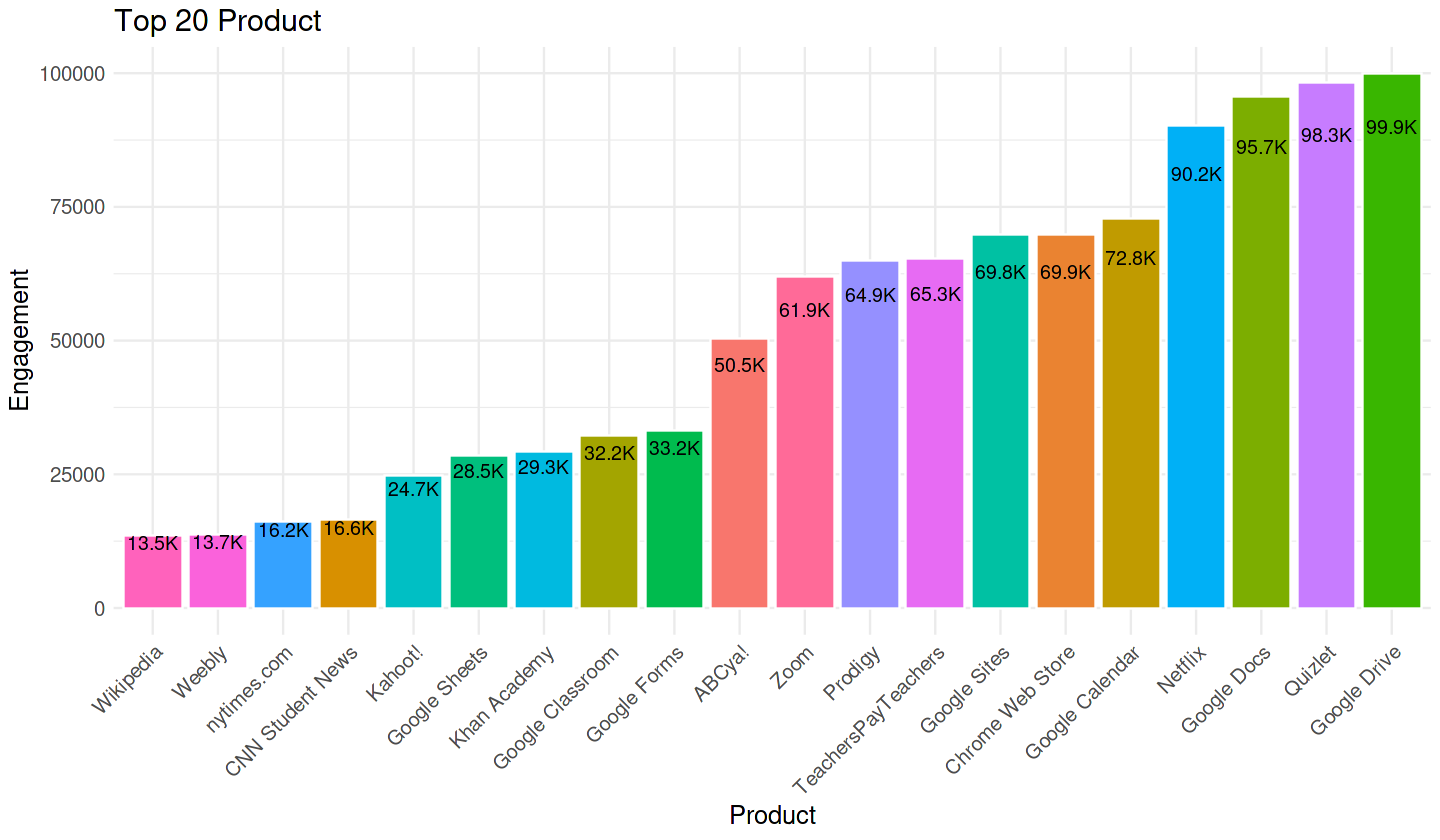

In [ ]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(12, 7)
ggplot(data=ep_top20, aes(x=reorder(product_name, lp_id), y=lp_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(lp_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=4) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Top 20 Product") +
  xlab("Product") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Google Top 20 Product

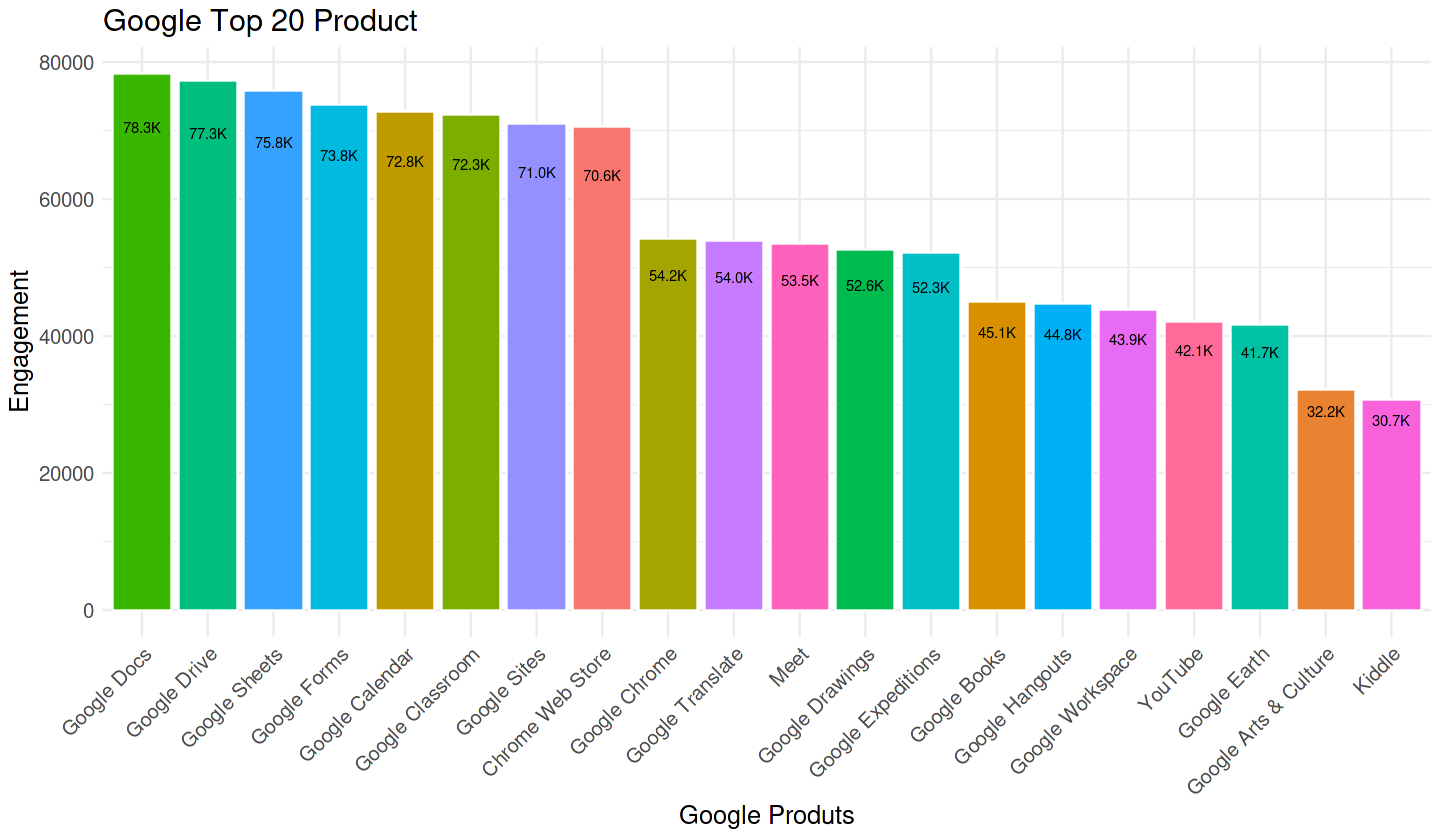

In [ ]:
google_product <- ep_dl %>% filter(provider_company_name==c("Google LLC")) %>% 
    select(lp_id, provider_company_name, product_name, cnt_id) %>% arrange(-cnt_id) %>% head(20)
ggplot(data=google_product, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Google Top 20 Product") +
  xlab("Google Produts") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Non Google Top 20 Product

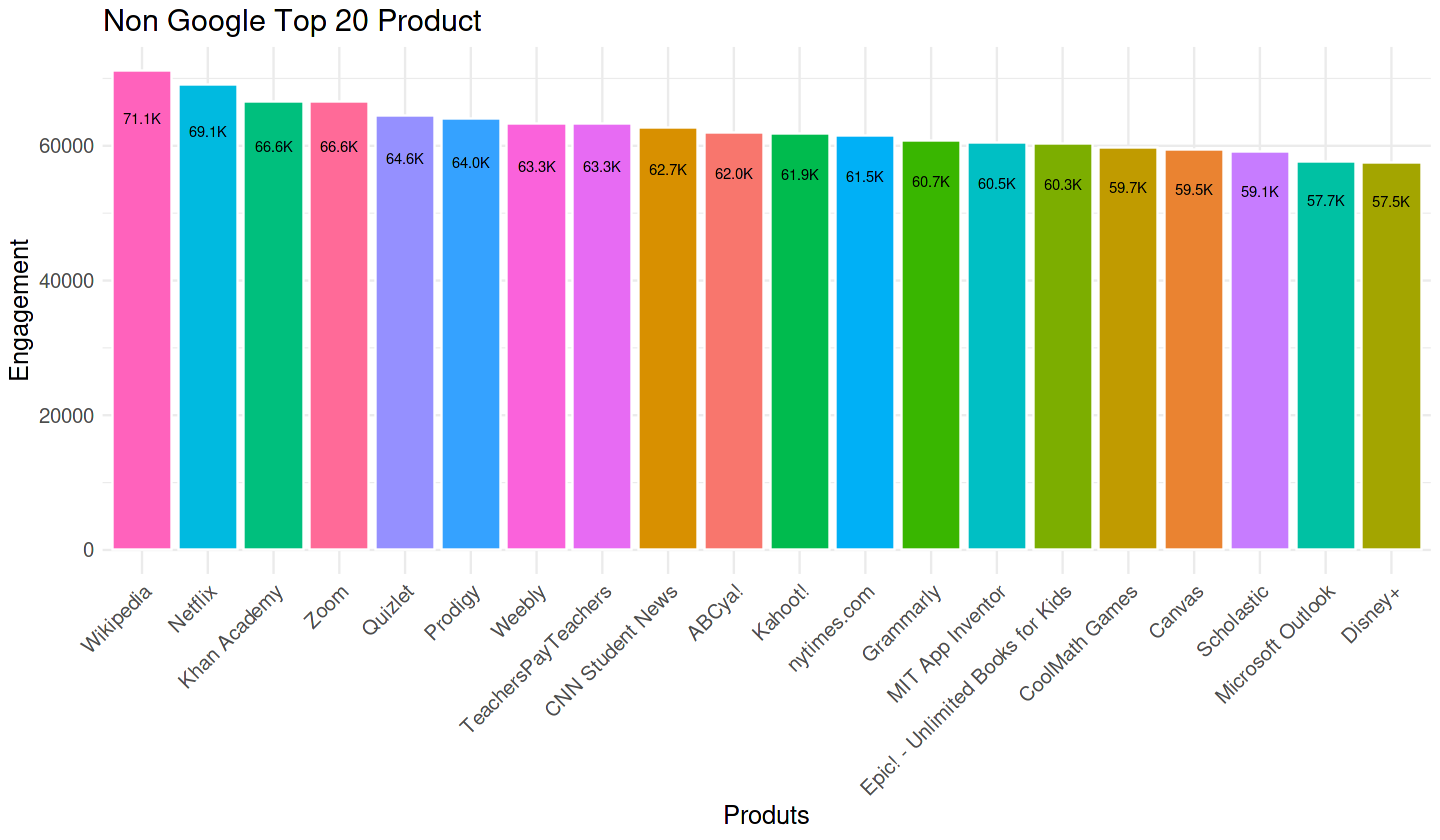

In [ ]:
non_google_t20 <- ep_dl %>% filter(provider_company_name != "Google LLC") %>% 
  select(lp_id, provider_company_name, product_name, cnt_id) %>% 
  arrange(desc(cnt_id)) %>% head(20)

ggplot(data=non_google_t20, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Non Google Top 20 Product") +
  xlab("Produts") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Top 20 Digital Learning Platform

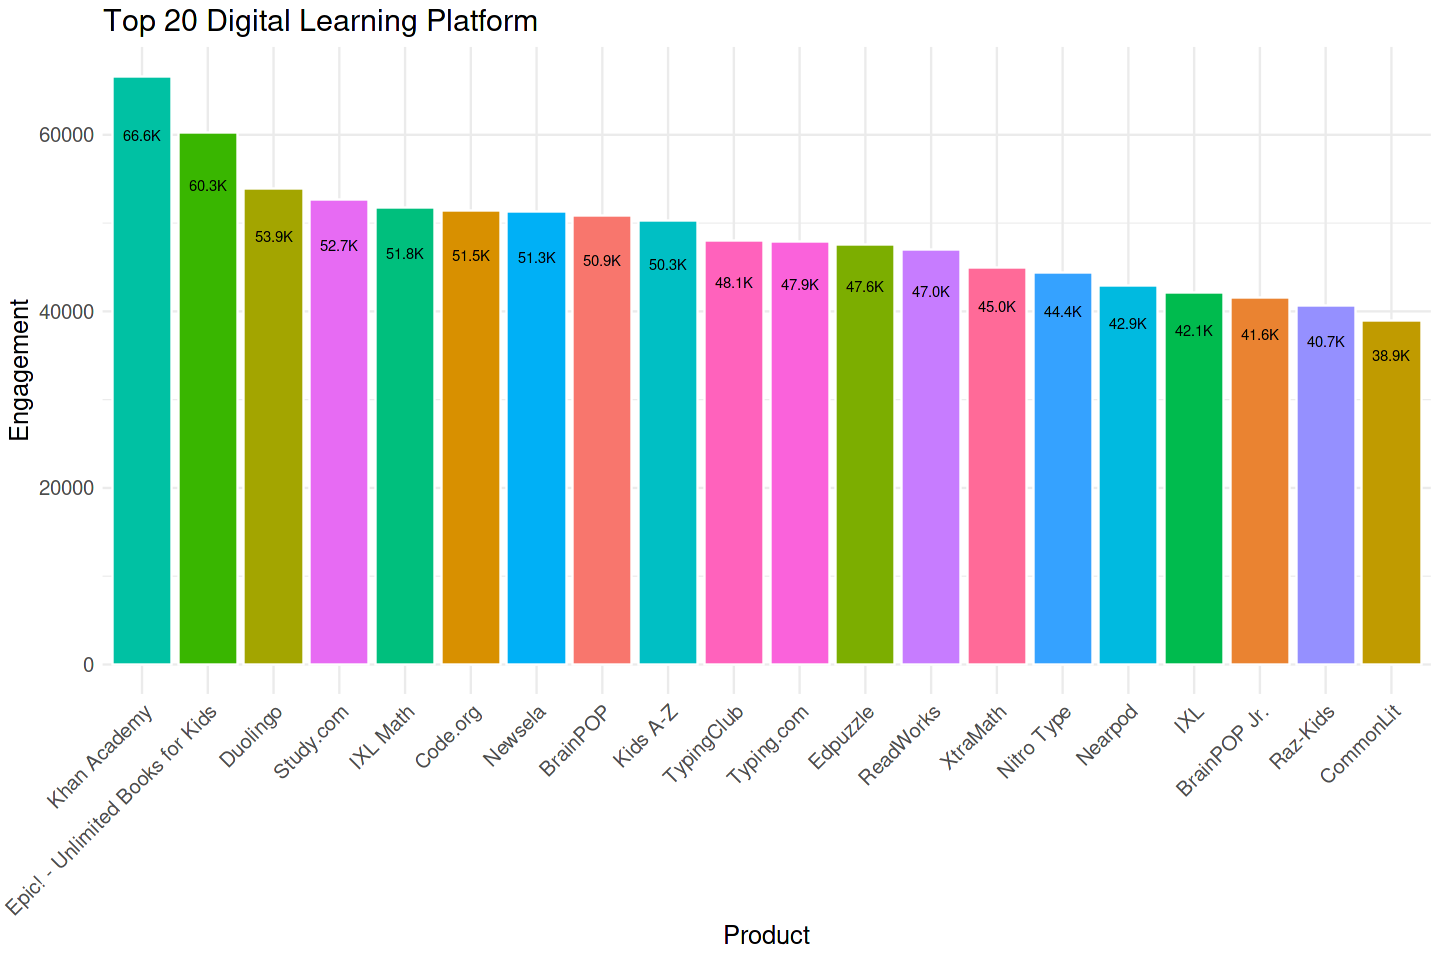

In [ ]:
fig(12, 8)
dlp_data <- dl %>% filter(sub_fun=="Digital Learning Platforms") %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name, sub_fun) %>% 
  dplyr::summarise(cnt_id=n(), m_pa=mean(pct_access, na.rm=T), m_ei=mean(engagement_index, na.rm=T),.groups="drop") %>% 
  arrange(desc(cnt_id)) 
ep_byproduct_t20 <- dlp_data %>% select(product_name, provider_company_name, cnt_id, m_pa, m_ei) %>% 
    arrange(-cnt_id) %>% head(20)
ggplot(data=ep_byproduct_t20, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Top 20 Digital Learning Platform") +
  xlab("Product") +
  ylab("Engagement") +  
  theme(legend.position = "none", text = element_text(size=15))

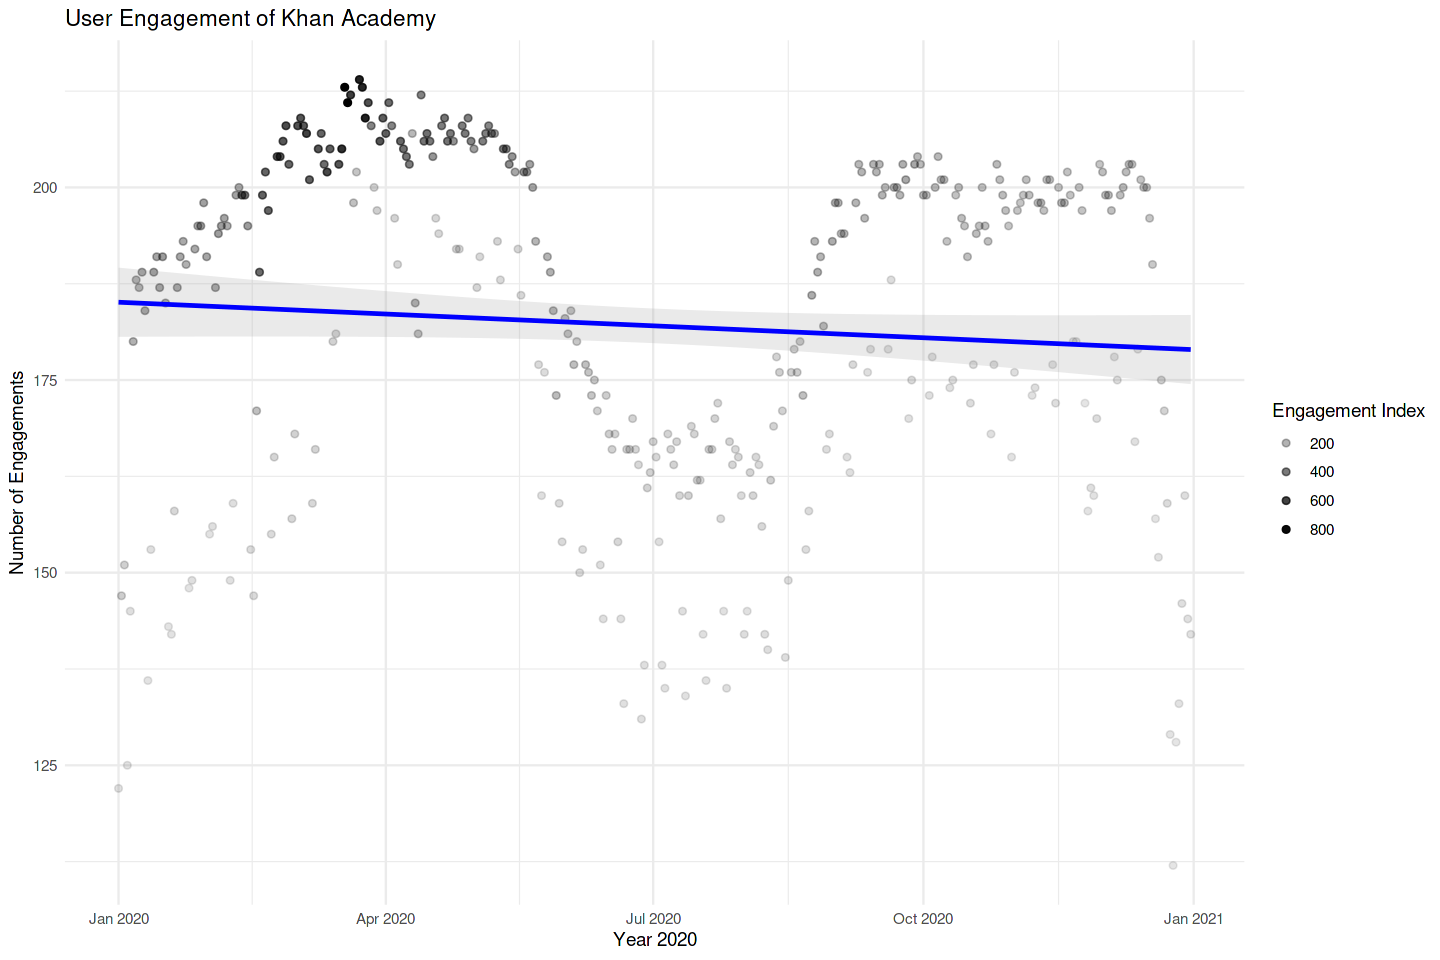

In [ ]:
fig(12, 8)
x <- subset(products, lp_id==29322) 
lp_idt1 <- dl %>% filter(lp_id==29322) %>% 
  dplyr::group_by(time) %>% dplyr::summarise(cnt_lp=n(), me_pa=mean(pct_access, na.rm=T), me_ei=mean(engagement_index, na.rm=T))
ggplot(data=lp_idt1, aes(x=time, y=cnt_lp, alpha=me_ei)) +
  geom_point() +
  geom_smooth(formula = y ~ x, method="lm", color="blue", alpha=0.2) +
  labs(title=paste("User Engagement of", x$product_name)) +
  xlab("Year 2020") +
  ylab("Number of Engagements") +
  guides(alpha=guide_legend("Engagement Index"))

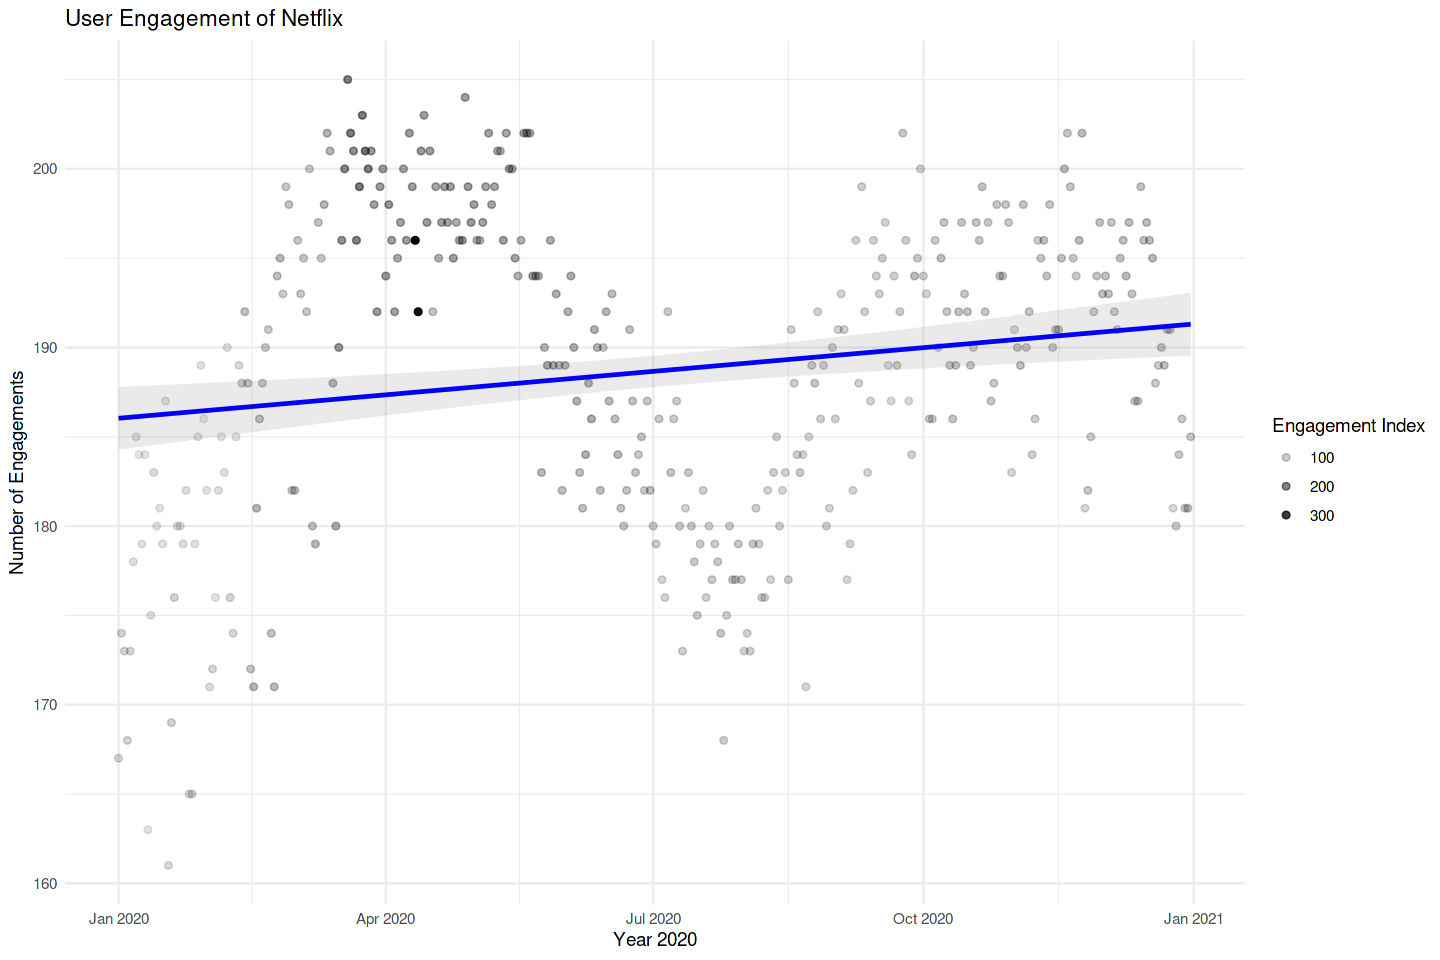

In [ ]:
x <- subset(products, lp_id==90153) 
lp_idt1 <- dl %>% filter(lp_id==90153) %>% 
  dplyr::group_by(time) %>% dplyr::summarise(cnt_lp=n(), me_pa=mean(pct_access, na.rm=T), me_ei=mean(engagement_index, na.rm=T))
ggplot(data=lp_idt1, aes(x=time, y=cnt_lp, alpha=me_ei)) +
  geom_point() +
  geom_smooth(formula = y ~ x, method="lm", color="blue", alpha=0.2) +
  labs(title=paste("User Engagement of", x$product_name)) +
  xlab("Year 2020") +
  ylab("Number of Engagements") +
  guides(alpha=guide_legend("Engagement Index"))

## Mean daily page-load events in top 10/20 Tools by per student, time, location, financial and social features

### Mean daily page-load events in top 20 tools, per 1 student

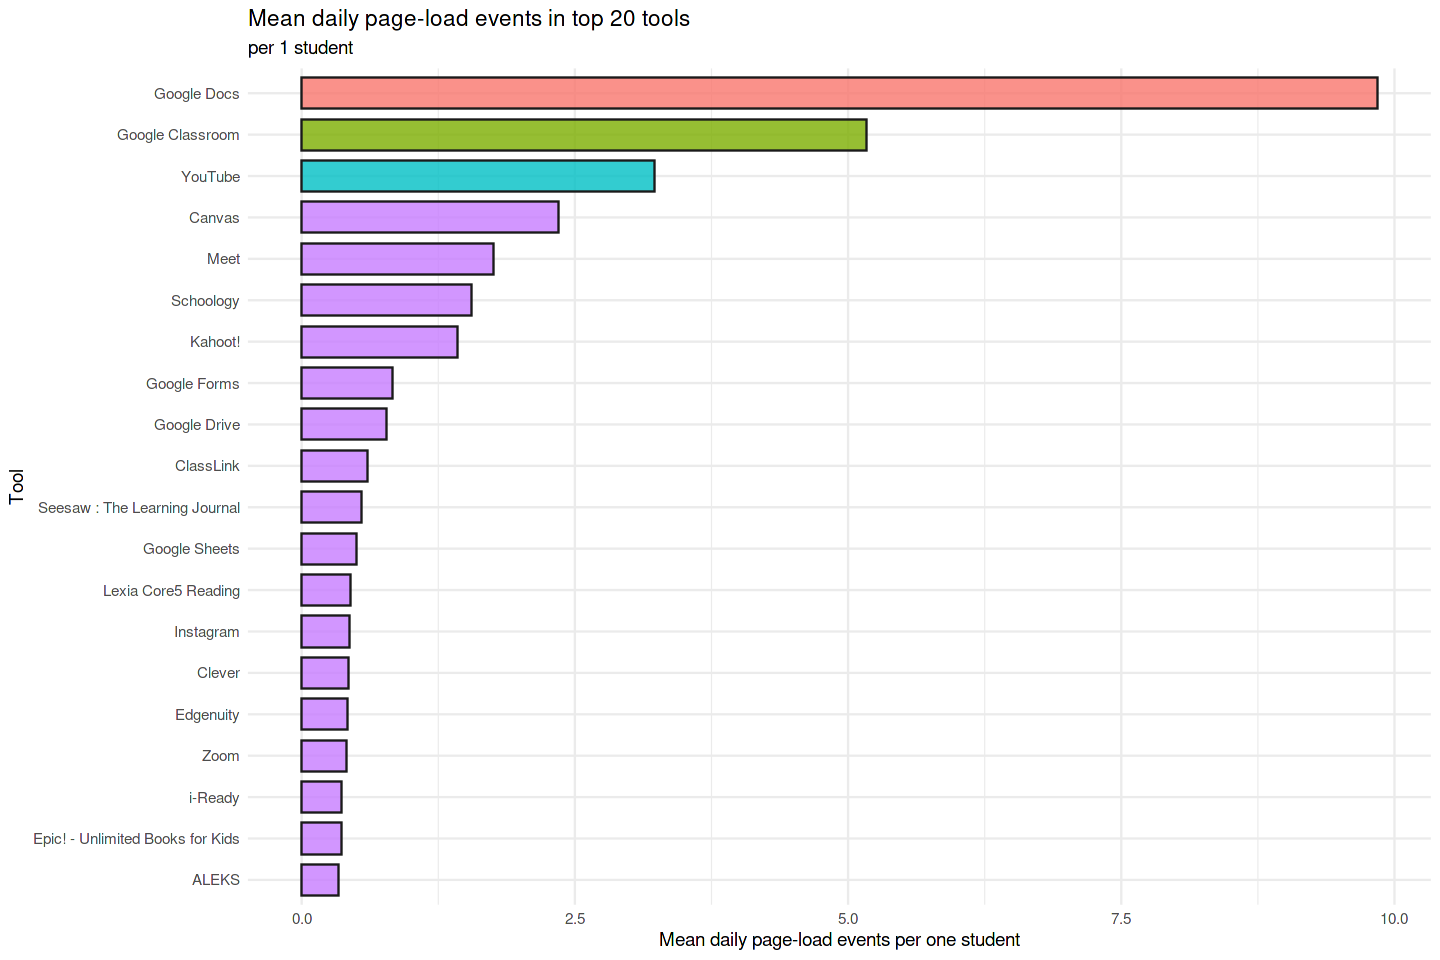

In [ ]:
'%ni%' <- Negate('%in%')

dl %>%
  group_by(product_name) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000) %>%
  arrange(desc(mean)) %>%
  slice(1:20) %>%
  mutate(fill = case_when(product_name == "Google Docs" ~ "1",
                          product_name == "Google Classroom" ~ "2",
                          product_name == "YouTube" ~ "3",
                          product_name %ni% c("Google Docs", "Google Classroom", "YouTube") ~ "4")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = fill))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  scale_colour_brewer(palette = "Paired")+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 20 tools", subtitle = "per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by tools and time, per 1 student

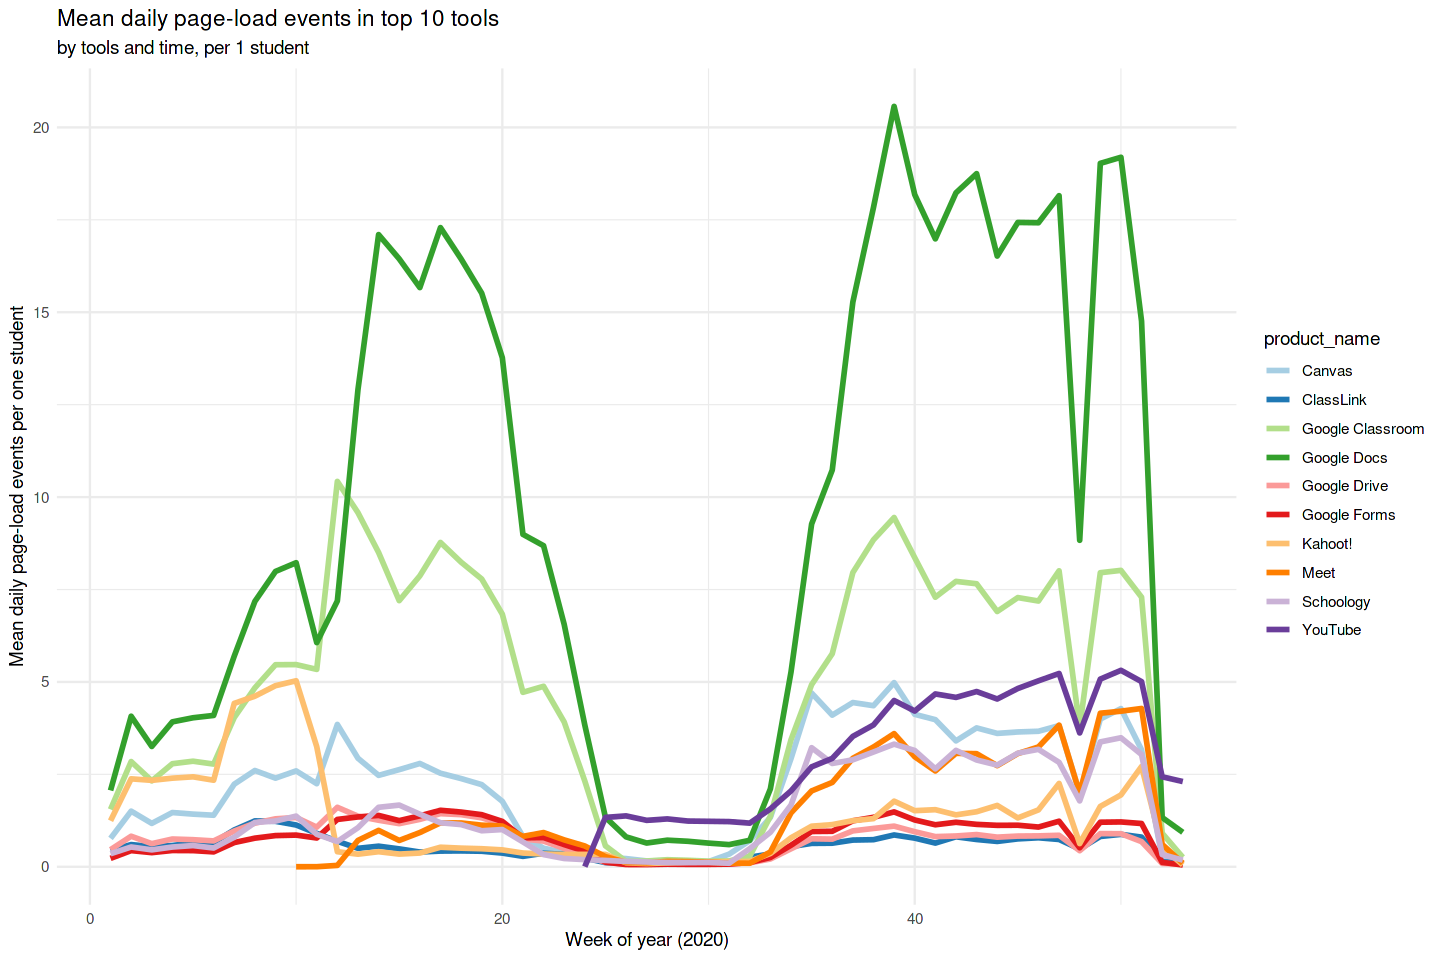

In [ ]:
dl %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Schoology", "Meet", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name,  time = week(as.Date(time))) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
ggplot(., aes(time, mean, colour = product_name))+
  geom_line(size = 1.2, alpha = 1)+
  scale_colour_brewer(palette = "Paired")+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by tools and time, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Week of year (2020)")+
  theme(legend.position = "right", legend.direction = "vertical")

### Mean daily page-load events in top 10 tools by locale and tools, per 1 student

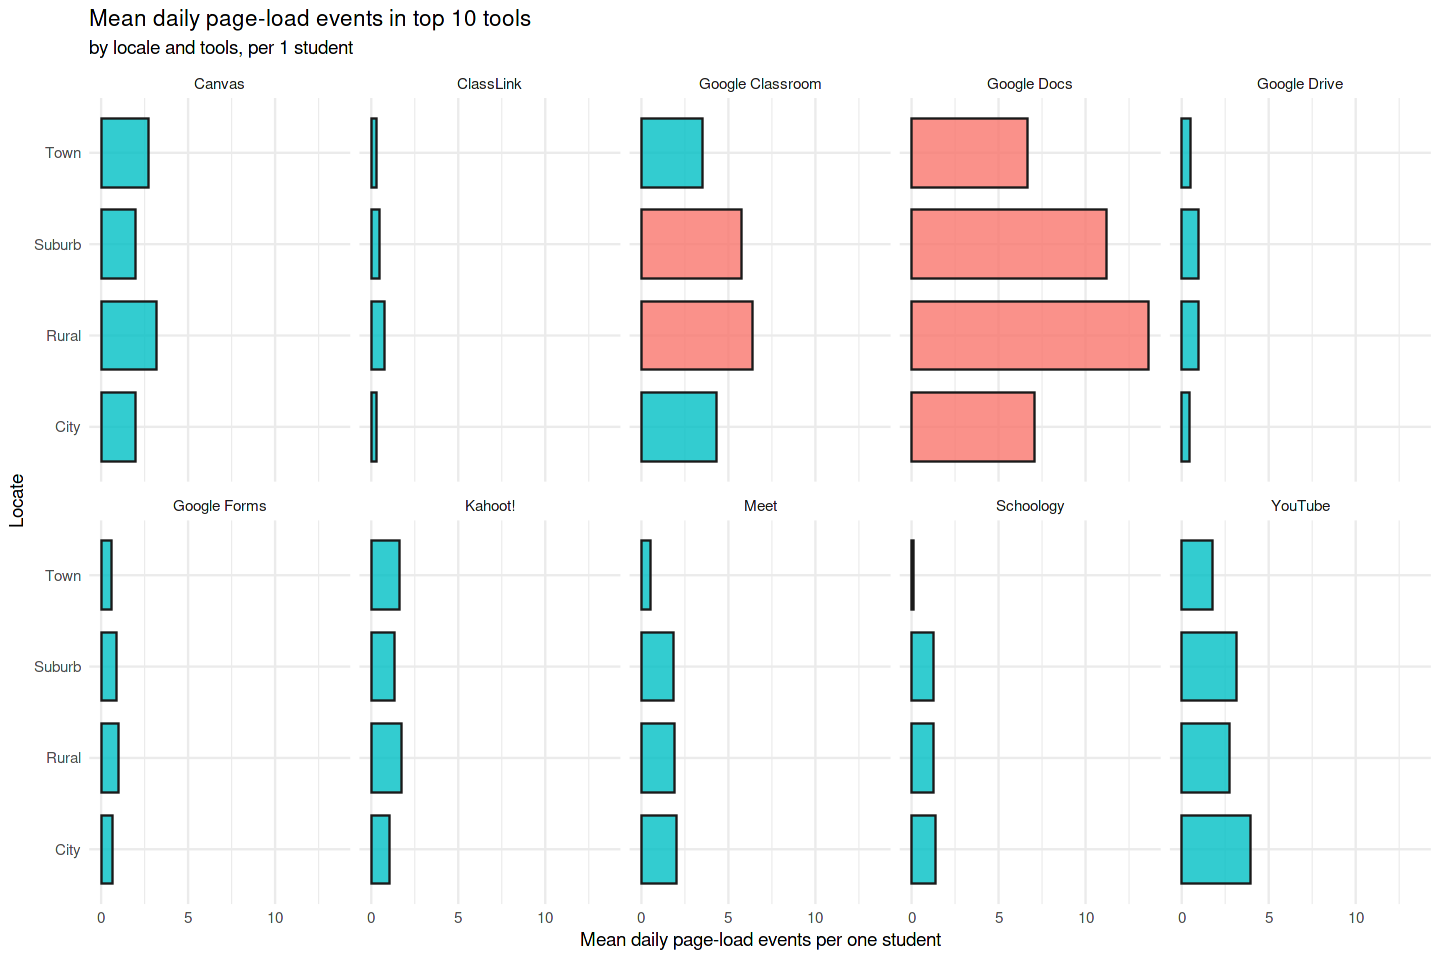

In [ ]:
dl %>%
  filter(locale != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, locale) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(locale) %>%
ggplot(., aes(locale, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by locale and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Locate")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by share of black/hispanic students and tools, per 1 student

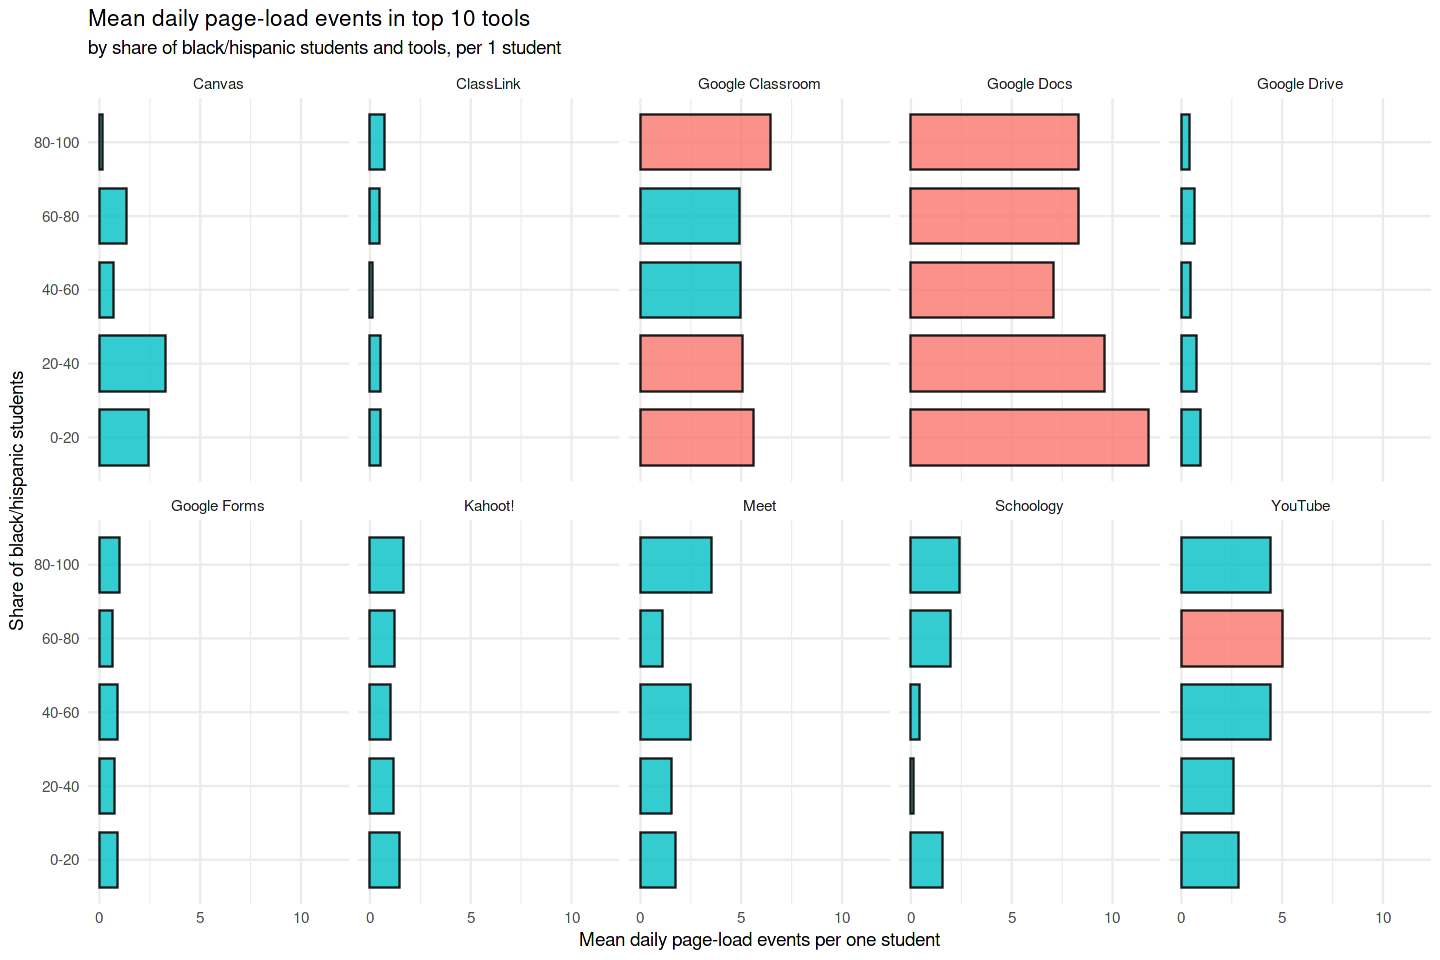

In [ ]:
dl %>%
  filter(pct_black_hispanic != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, pct_black_hispanic) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(pct_black_hispanic) %>%
ggplot(., aes(pct_black_hispanic, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by share of black/hispanic students and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Share of black/hispanic students")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by share of students eligible for free or reduced-price lunch and tools, per 1 student

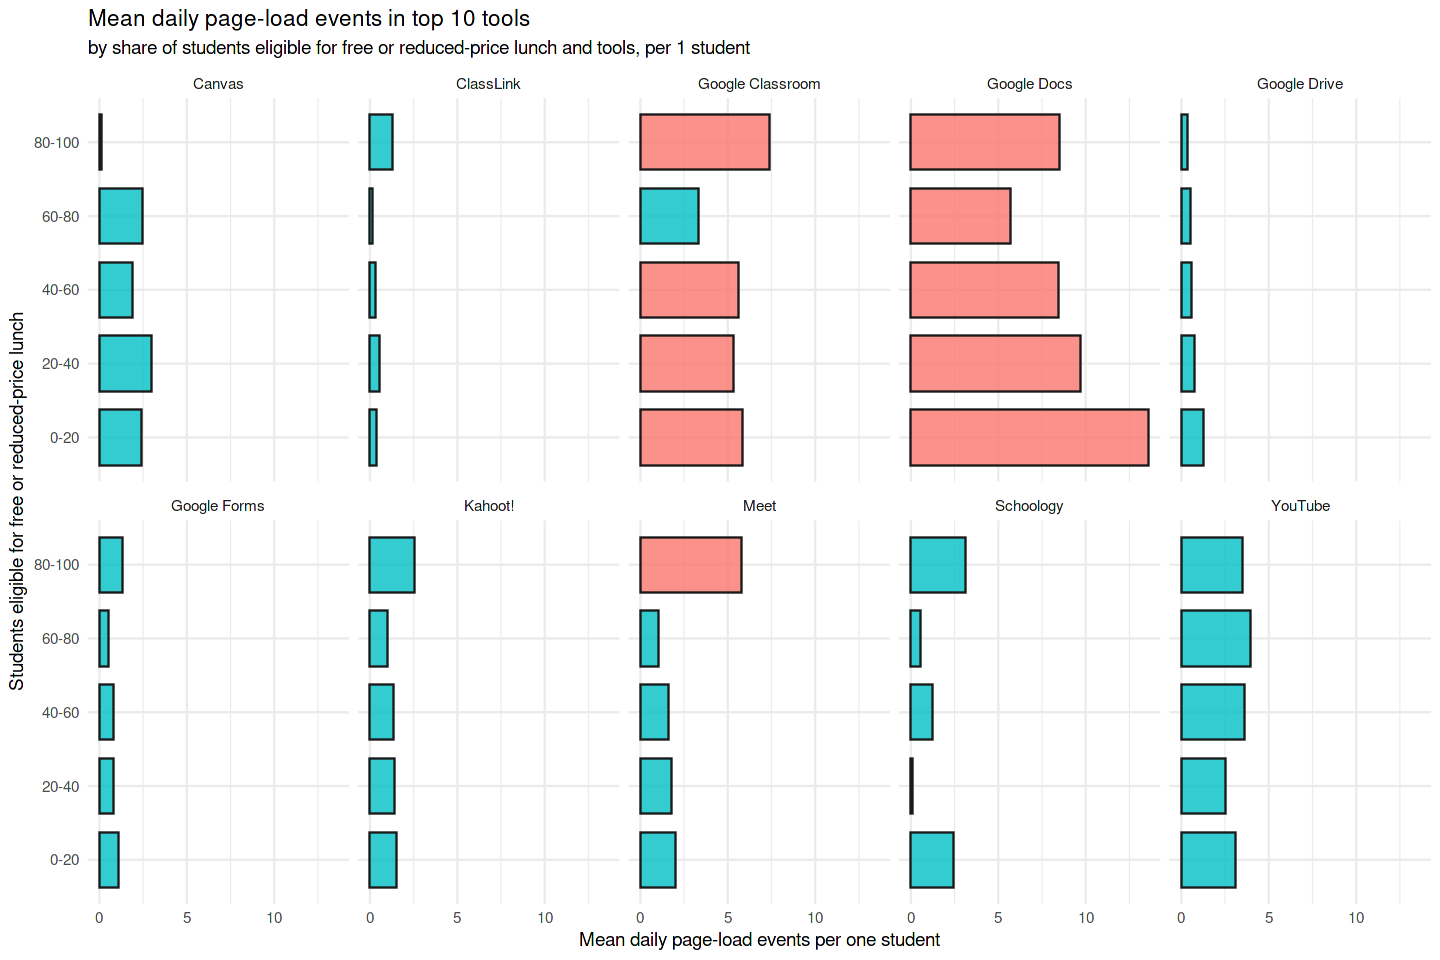

In [ ]:
dl %>%
  filter(pct_free_reduced != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, pct_free_reduced) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(pct_free_reduced) %>%
ggplot(., aes(pct_free_reduced, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by share of students eligible for free or reduced-price lunch and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Students eligible for free or reduced-price lunch")+
  theme(legend.position = "none")


## States Map Data Distribution

A map of USA color coded for the school districts present in the data

Joining, by = "state"



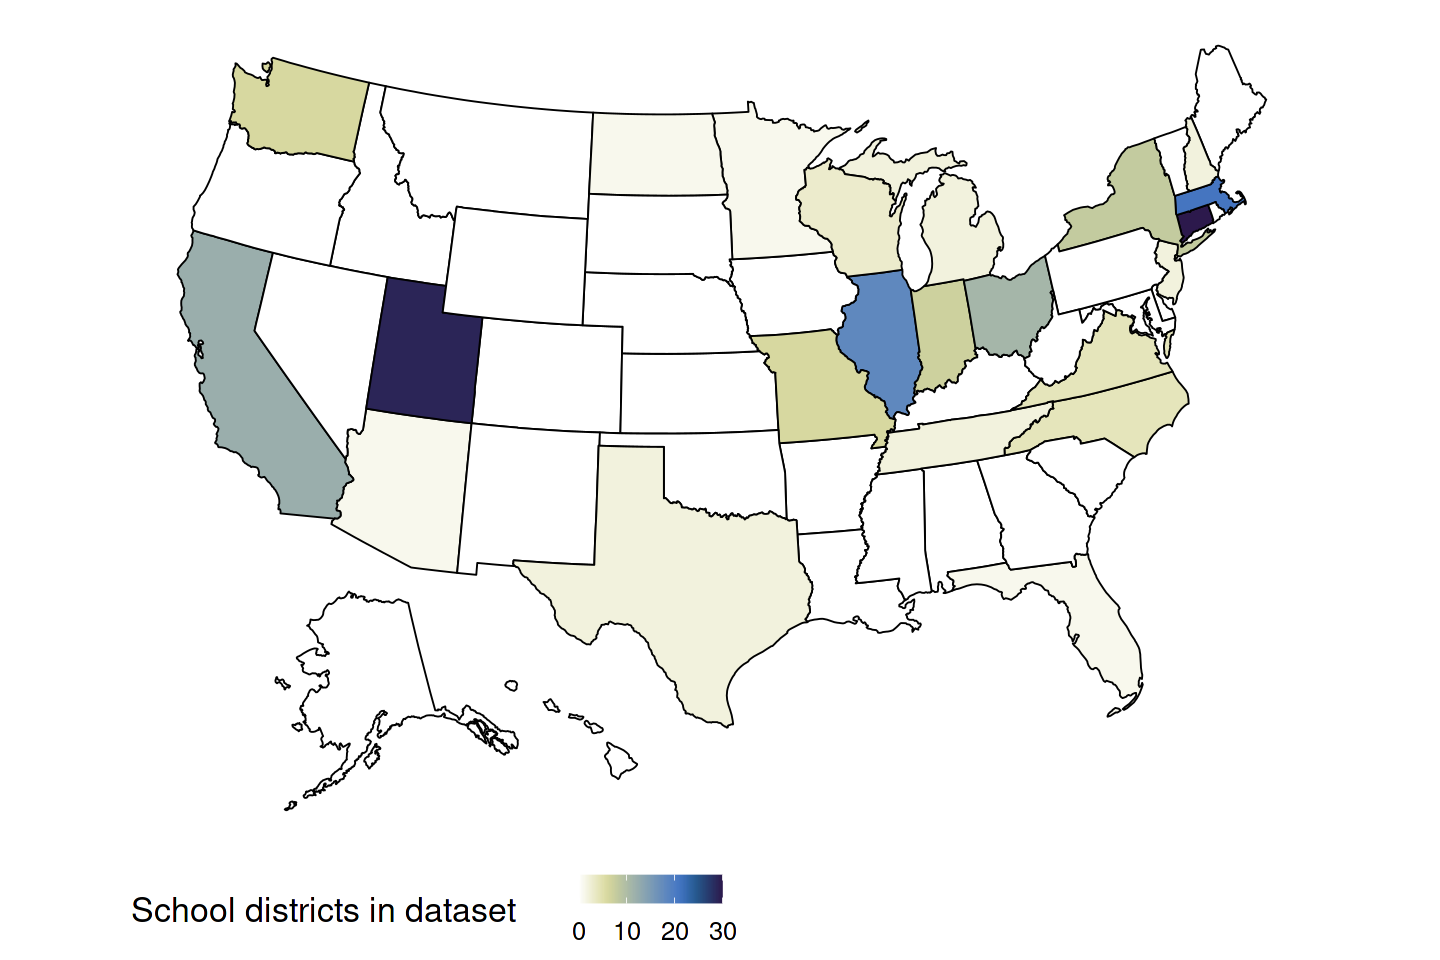

In [ ]:
# making a map
state_df <- districts %>% 
                group_by(state) %>% 
                tally() %>% 
                right_join(statepop %>% rename(state = full)) %>% 
                replace_na(list(n = 0))

plot_usmap(data = state_df, values = "n") + 
        scale_fill_scico(name = "School districts in dataset", 
                         palette = "davos", direction = -1) +
        theme(legend.position = "bottom",
              legend.text = element_text('Lato', size = 15),
              legend.title =  element_text('Lato', size = 20))

In [ ]:
dep_data <- dl %>% filter(!is.na(lp_id) & !is.na(product_name))
dep_product <- dep_data %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name, district_id) %>% 
  dplyr::summarise(cnt_id=n(), nm_pa=mean(pct_access, na.rm=T), nm_ei=mean(engagement_index, na.rm=T), .groups="drop") %>% 
  arrange(desc(cnt_id)) %>% filter(!is.na(product_name))
dep_product <- dep_product %>% filter(!is.na(nm_pa) & !is.na(nm_ei))

nwea_data <- dep_product %>% dplyr::group_by(district_id) %>% dplyr::summarise(cnt_id=sum(cnt_id, na.rm=T), m_pa=mean(nm_pa, na.rm=T), m_ei=mean(nm_ei, na.rm=T))
d_ep <- dep_product %>% left_join(districts, by="district_id")

sd_ep <- d_ep %>% dplyr::group_by(state) %>% 
  dplyr::summarise(s_id=sum(cnt_id), m_pa=mean(nm_pa, na.rm=T), m_ei=mean(nm_ei, na.rm=T), ) %>% 
  filter(state!="NA") %>% 
  arrange(desc(s_id))


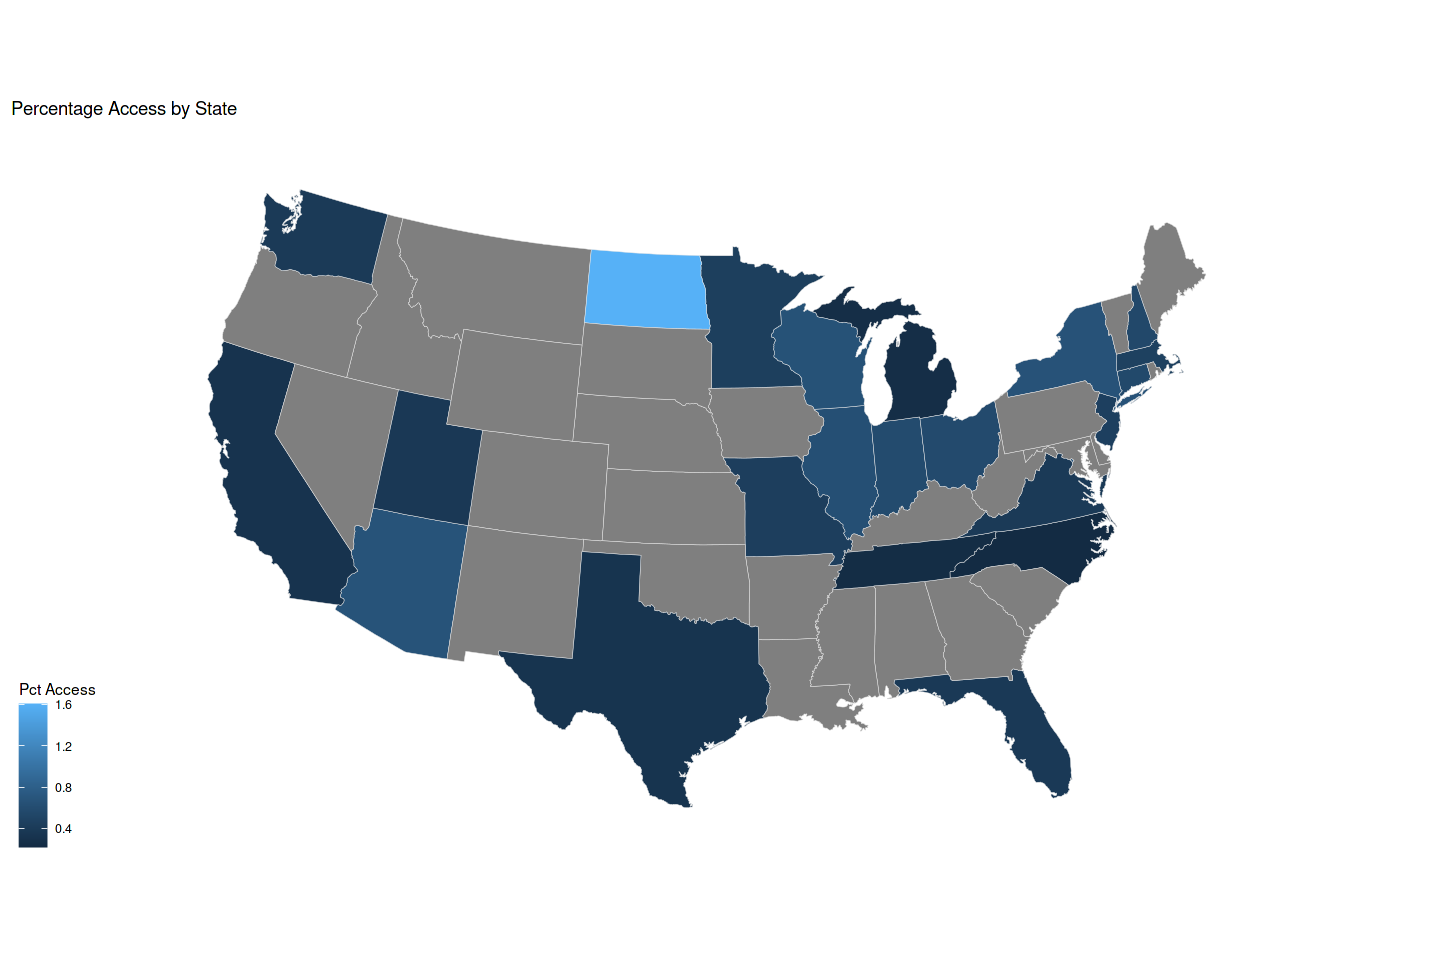

In [ ]:
library(ggthemes)
states_map <- map_data("state")
sd_ep <- sd_ep %>% mutate(region = tolower(state))
sd_ep_map <- left_join(states_map, sd_ep, by="region")
p0 <- ggplot(data = sd_ep_map,
             mapping = aes(x = long, y = lat,
                           group = group, fill = m_pa))
p1 <- p0 + geom_polygon(color = "gray90", size = 0.1) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) 
p1 + labs(title = "Percentage Access by State") + theme_map() + labs(fill = "Pct Access")

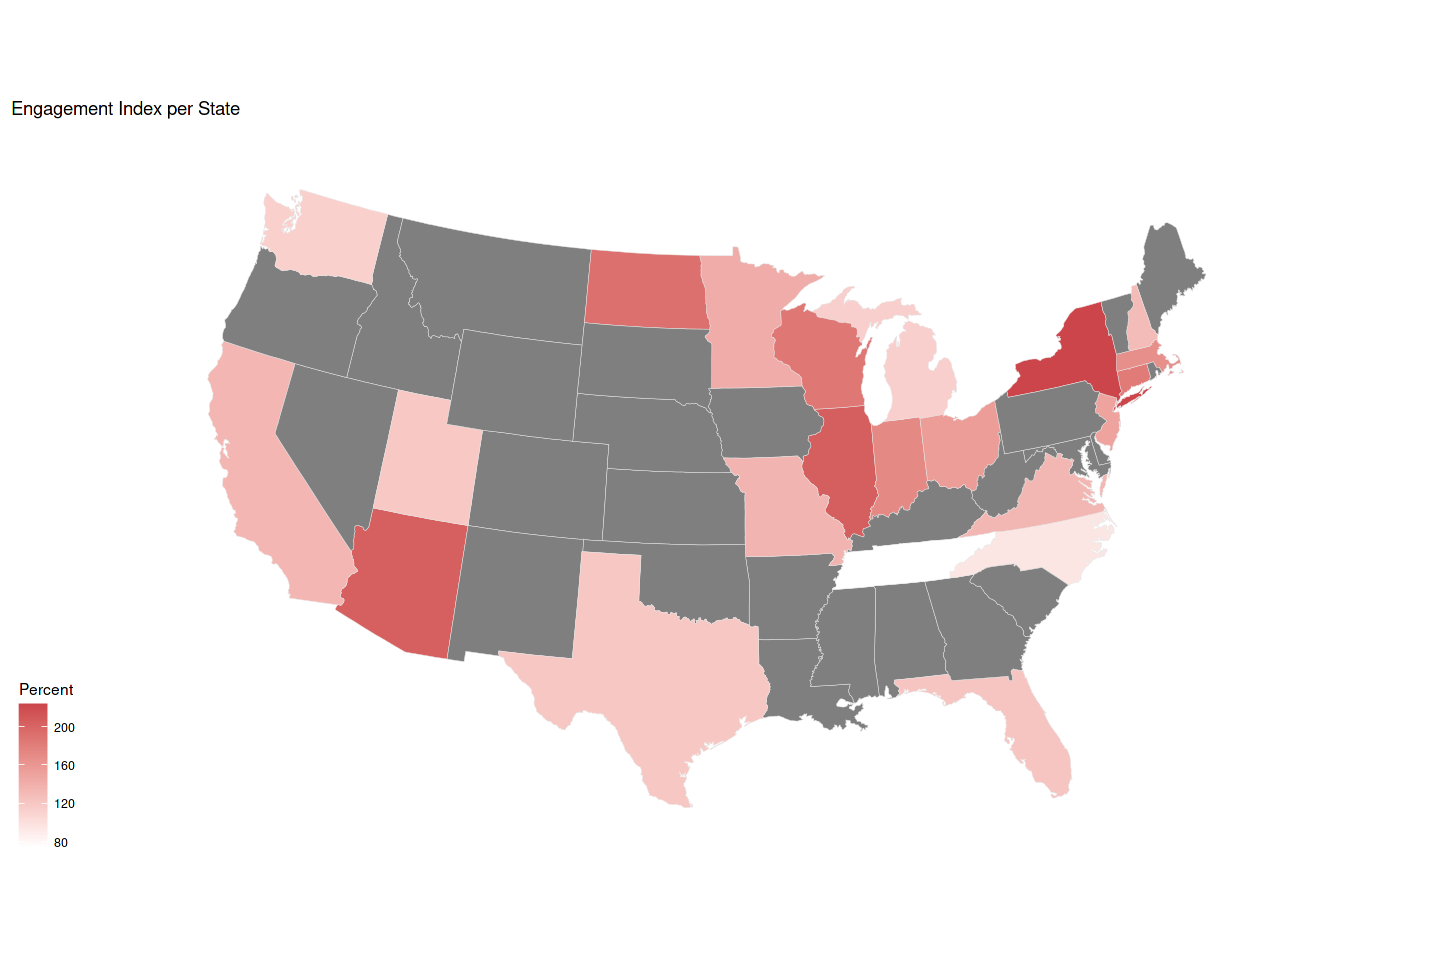

In [ ]:
p0 <- ggplot(data = sd_ep_map,
             mapping = aes(x = long, y = lat,
                           group = group, fill = m_ei))
p1 <- p0 + geom_polygon(color = "gray90", size = 0.1) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) 
# p1 + labs(title = "Pct Access") + theme_map() + labs(fill = "Percent")
p2 <- p1 + scale_fill_gradient(low = "white", high = "#CB454A") +
        labs(title = "Engagement Index per State") 
p2 + theme_map() + labs(fill = "Percent")

### Mean daily page-load events in top 10 tools by every state, per 1 student

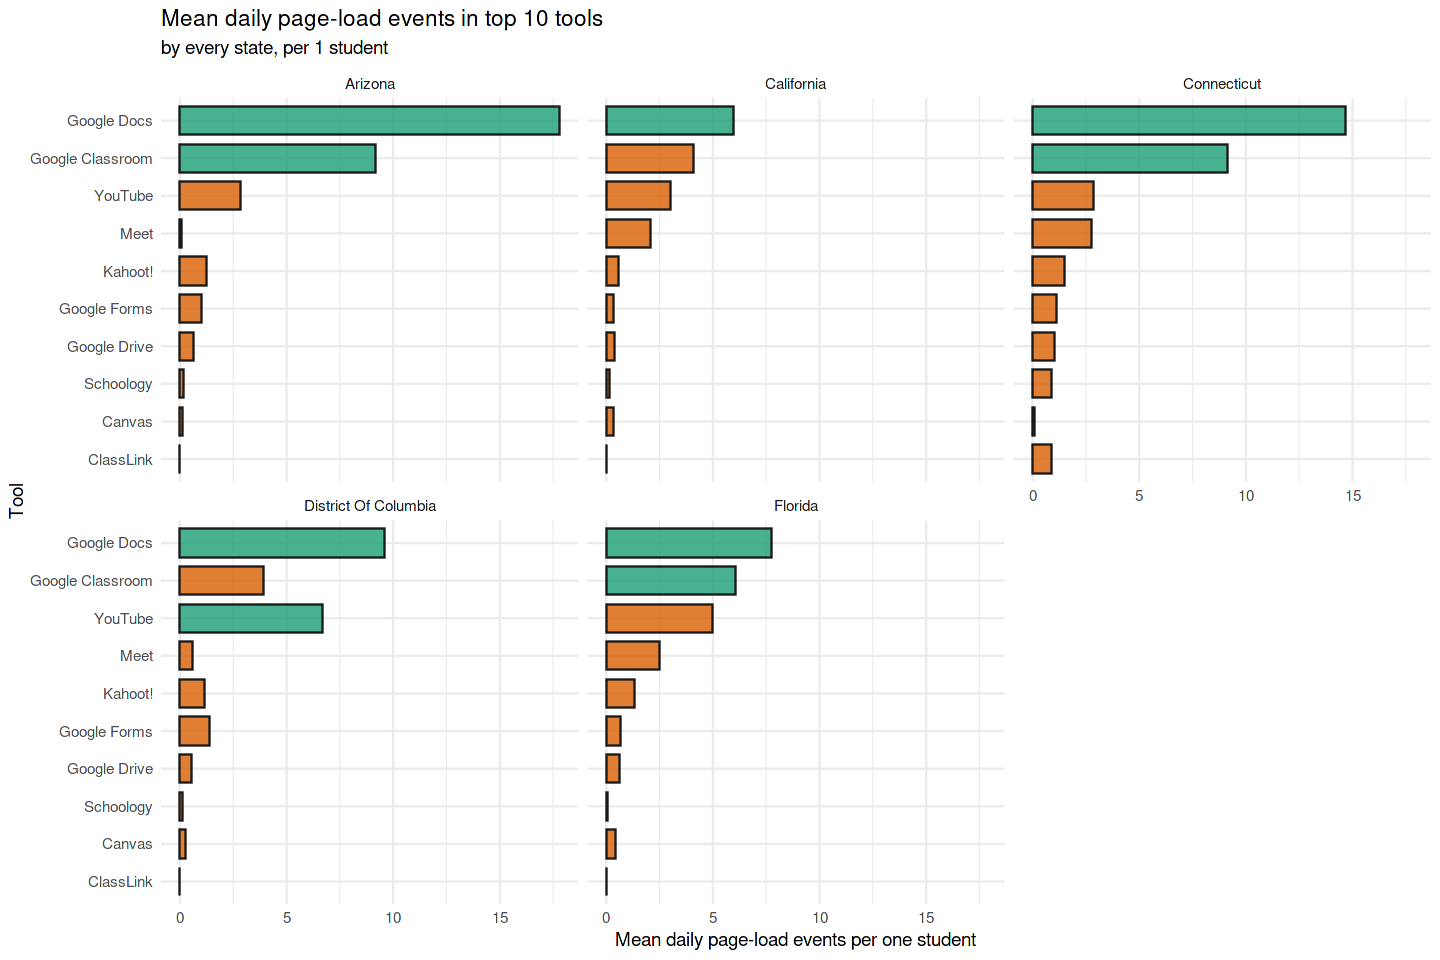

In [ ]:
dl %>%
  filter(state %in% c("Arizona", "California", "Connecticut", "District Of Columbia", "Florida")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

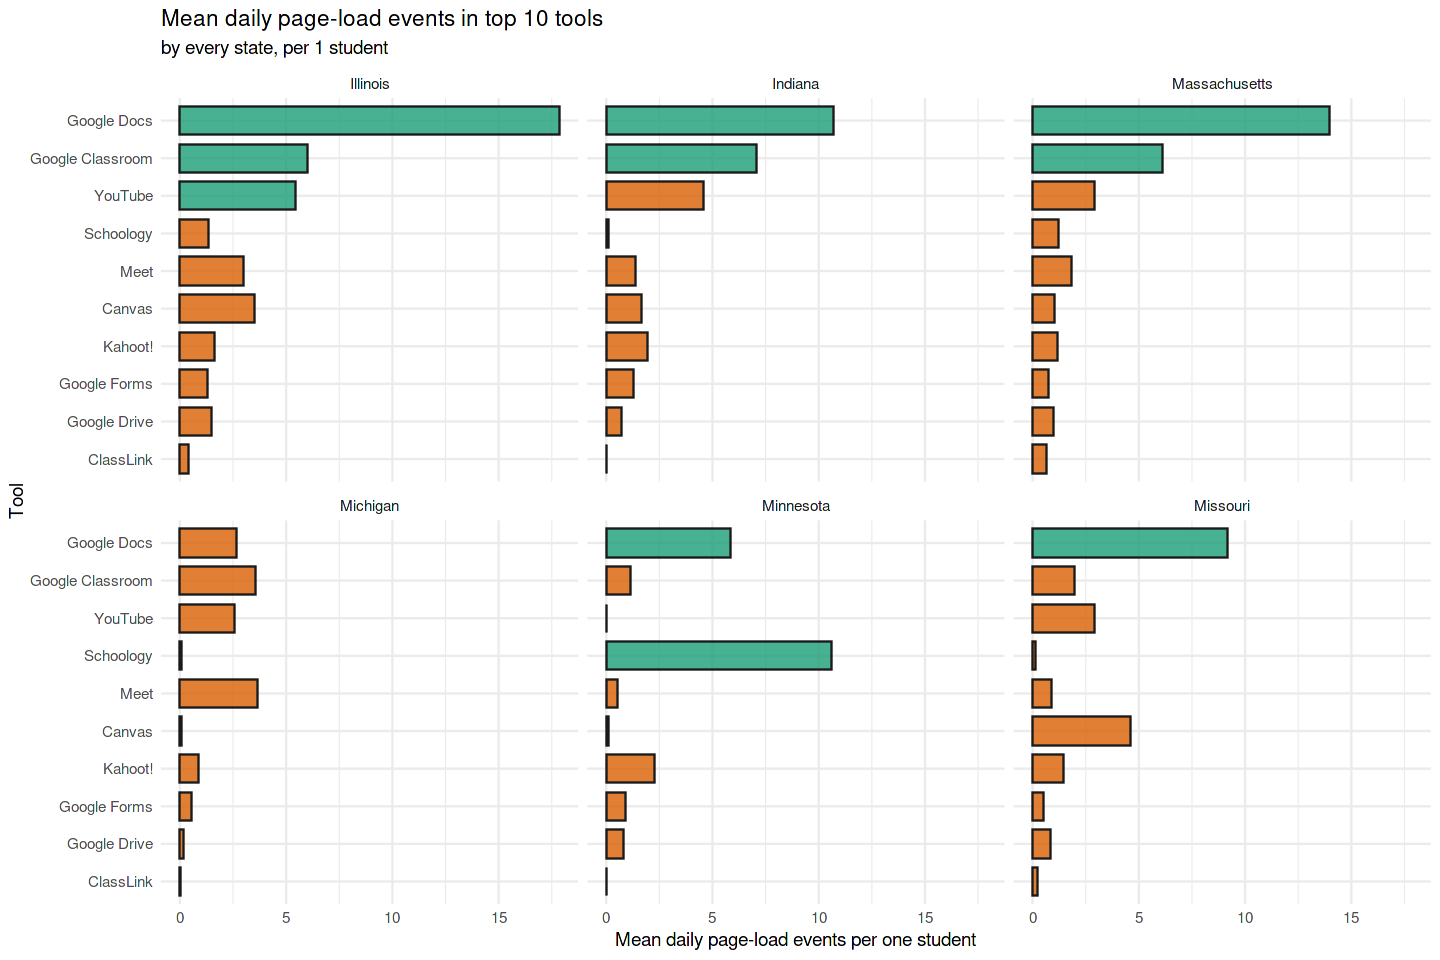

In [ ]:
dl %>%
  filter(state %in% c("Illinois", "Indiana", "Massachusetts", "Michigan", "Minnesota", "Missouri")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

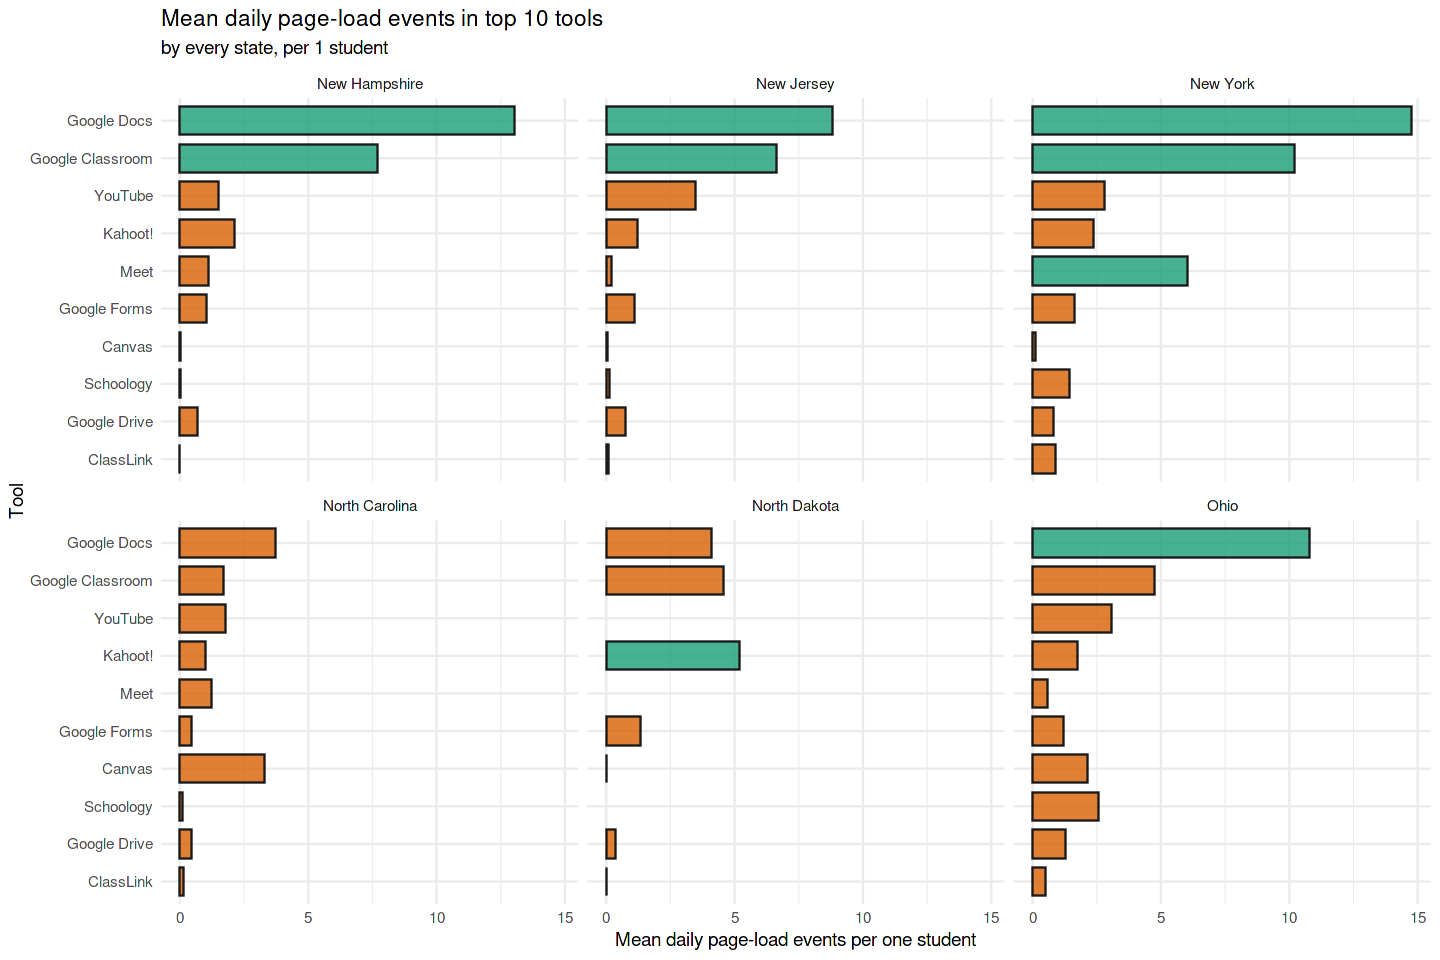

In [ ]:
dl %>%
  filter(state %in% c("New Hampshire", "New Jersey", "New York", "North Carolina", "North Dakota", "Ohio")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

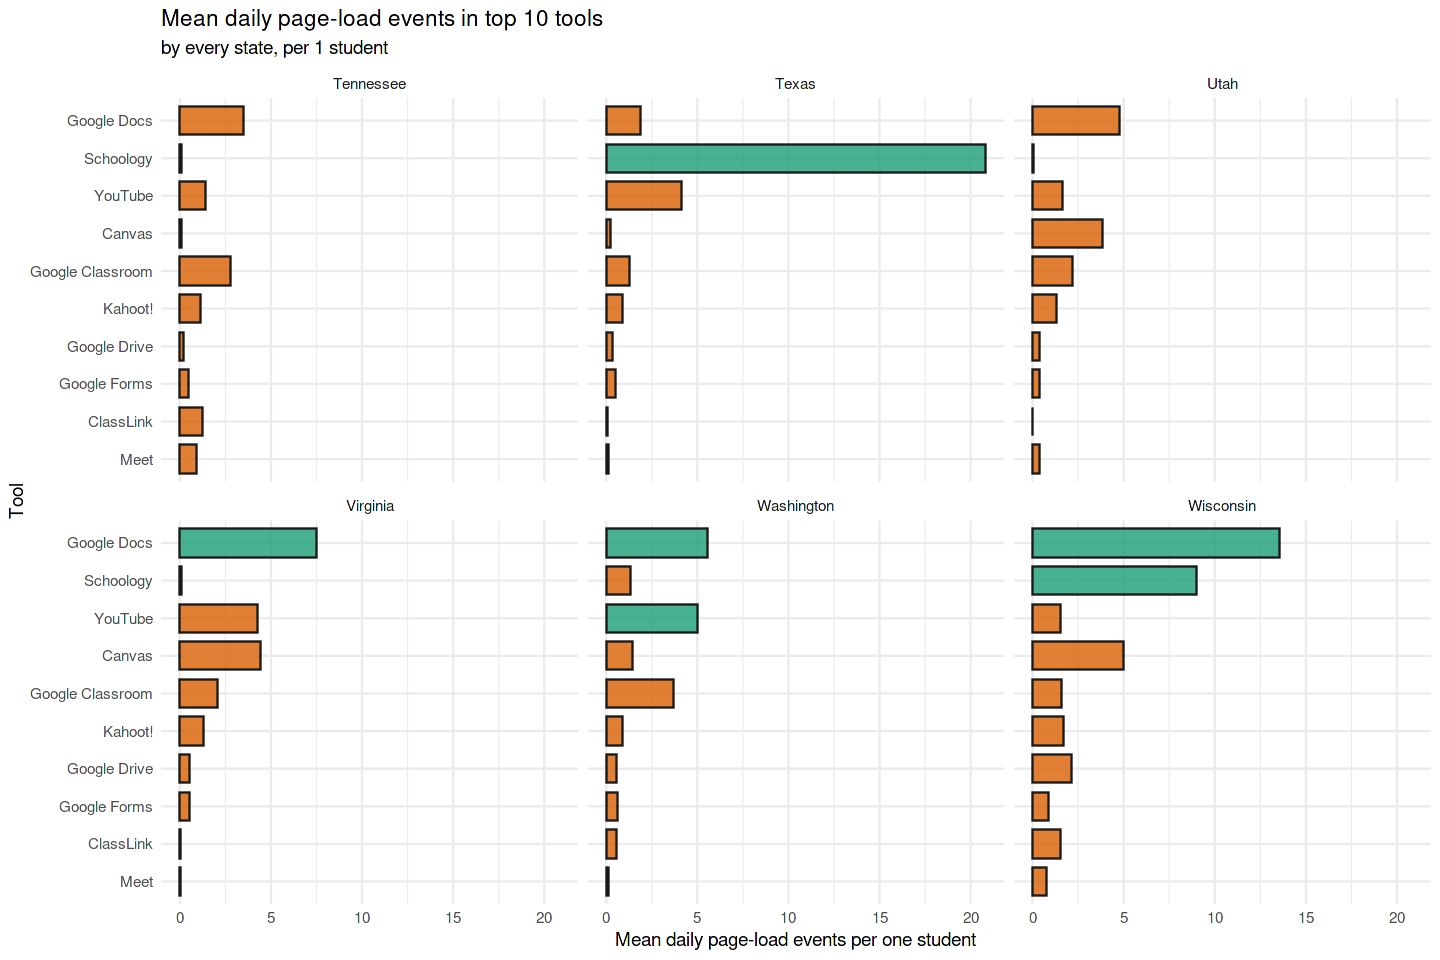

In [ ]:
dl %>%
  filter(state %in% c("Tennessee", "Texas", "Utah", "Virginia", "Washington", "Wisconsin")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

# Correlation analysis with Covid-19 cases in 2020

In [ ]:
head(dl,3)

time       lp_id pct_access engagement_index district_id product_name  
1 2020-01-01 93690 0.00       167.6063         1000        Calculator.com
2 2020-01-01 17941 0.03         0.9000         1000        Kids A-Z      
3 2020-01-01 65358 0.03         1.2000         1000        Prezi         
  provider_company_name sector_s                      main_fun
1 Calculator.com        PreK-12; Higher Ed; Corporate LC      
2 Lazel Inc.            PreK-12                       LC      
3 Prezi Inc.            PreK-12; Higher Ed; Corporate LC      
  sub_fun                      state       locale pct_black_hispanic
1 Sites, Resources & Reference Connecticut Suburb 60-80             
2 Digital Learning Platforms   Connecticut Suburb 60-80             
3 Content Creation & Curation  Connecticut Suburb 60-80             
  pct_free_reduced county_connections_ratio pp_total_raw minority frl
1 20-40            [0.18, 1[                10000-12000  4        2  
2 20-40            [0.18, 1[                10000-12000  4        2  
3 20-40            [0.18, 1[                10000-12000  4        2  
  expenditure
1 4          
2 4          
3 4

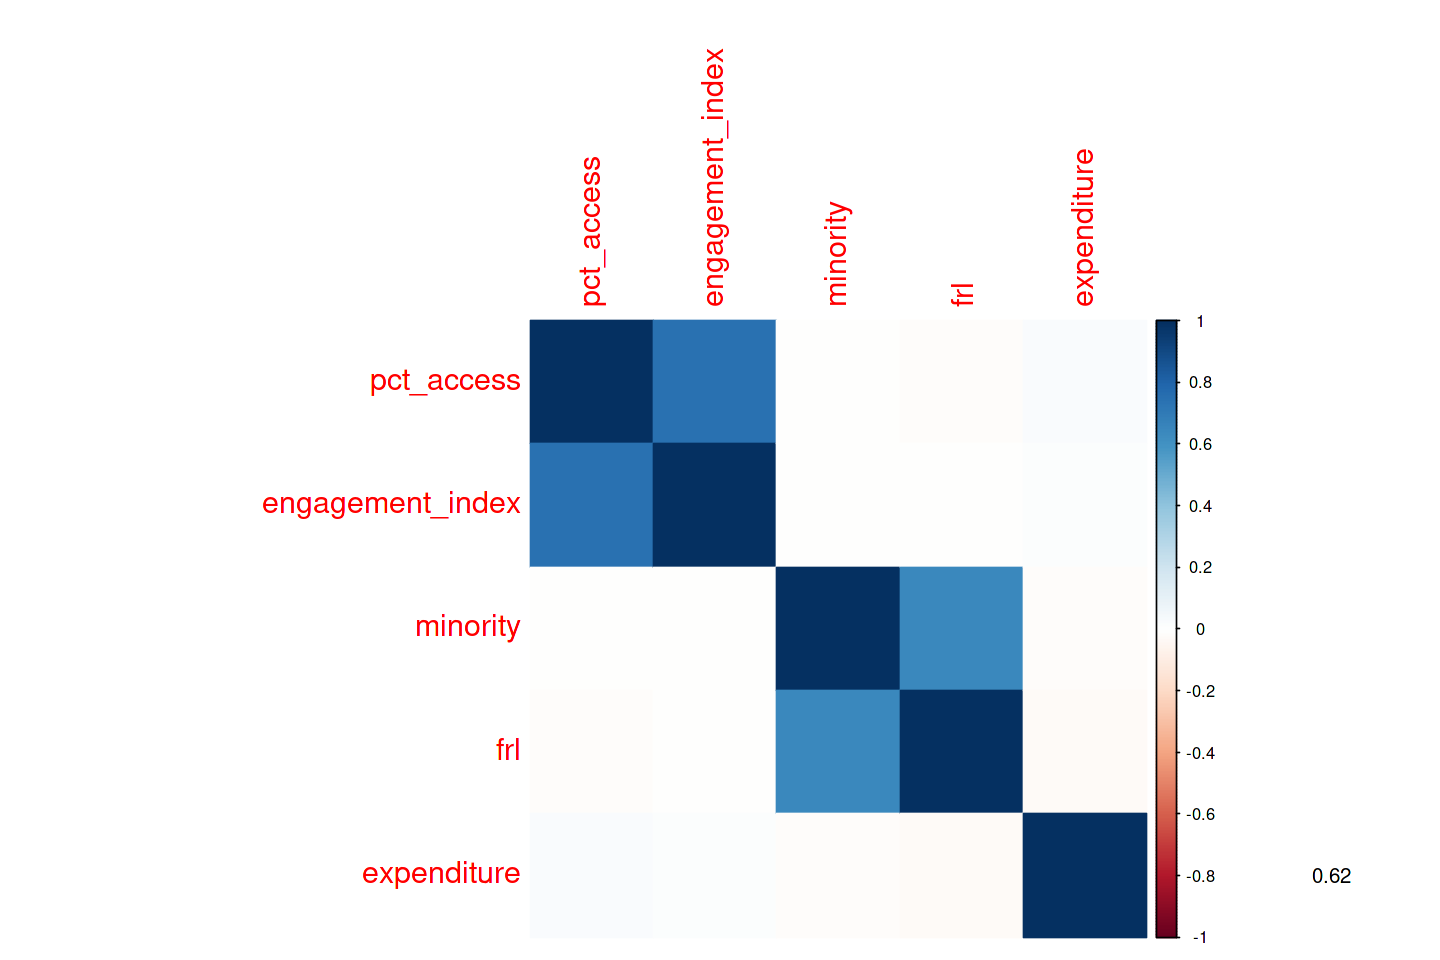

In [ ]:
df <- subset(dl, select=c(pct_access, engagement_index, minority, frl, expenditure))
df <- df[complete.cases(df), ]
M = cor(df)
testRes = cor.mtest(mtcars, conf.level = 0.95)
corrplot(M,
         p.mat = testRes$p,
         insig = 'p-value',
         pch.col='black',
         method='color',
         tl.cex=1.5) # colorful number

# State practices, policies, and interventions associated with changes in student engagement

### Checking for any changes (improvements, etc.) in the states from early to mid pandemic

In [ ]:
week_of_list_early=as.Date(c('2020-04-08', '2020-04-22', '2020-04-29'))
week_of_list_mid=as.Date(c('2020-09-23', '2020-09-30', '2020-10-07'))
week_of_list_both <- c(week_of_list_early, week_of_list_mid)

# loading all engagement data
state_data <- engg %>%
    mutate(week = cut.Date(time, breaks = "1 week", labels = FALSE)) %>%
    arrange(time)
state_data <- state_data %>%
    inner_join(districts)
#Weekly average data - Grouping by week
state_data <- state_data %>%
    group_by(week, state) %>%
    summarize(engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
state_data$date = lubridate::ymd("2020-01-01") + lubridate::weeks(state_data$week - 1)
state_data <- na.omit(state_data)

Joining, by = "district_id"

`summarise()` has grouped output by 'week'. You can override using the `.groups` argument.



In [ ]:
head(state_data)

week state                engagement_index pct_access date      
1 1    Arizona              65.701520        0.30339080 2020-01-01
2 1    California           11.762836        0.05288501 2020-01-01
3 1    Connecticut          98.929942        0.60688411 2020-01-01
4 1    District Of Columbia 53.451083        0.47181172 2020-01-01
5 1    Florida               2.020658        0.01902423 2020-01-01
6 1    Illinois             16.598180        0.12350412 2020-01-01

In [ ]:
state_data_list = filter(state_data, date %in% week_of_list_both)
state_data_df = state_data_list[,1:2]
state_data_df = state_data_df[!duplicated(state_data_df), ]
table(state_data_df$state)


             Arizona           California          Connecticut 
                   6                    6                    6 
District Of Columbia              Florida             Illinois 
                   6                    6                    6 
             Indiana        Massachusetts             Michigan 
                   6                    6                    6 
           Minnesota             Missouri        New Hampshire 
                   3                    6                    6 
          New Jersey             New York       North Carolina 
                   6                    6                    6 
                Ohio            Tennessee                Texas 
                   6                    6                    3 
                Utah             Virginia           Washington 
                   6                    6                    6 
           Wisconsin 
                   6 

We can see that Minnesota and Texas don't have data available for all 6 week so they will be removed for further analysis

In [ ]:
state_data = state_data[!state_data$state=="Minnesota",]
state_data = state_data[!state_data$state=="Texas",] 
state_data = state_data[!state_data$state=="Arizona",] 

In [ ]:
earlyState = subset(state_data, date >= '2020-04-01' & date <= '2020-08-10')
midState = subset(state_data, date >= '2020-08-10')

earlyState <- earlyState %>%
    group_by(state) %>%
    summarize (eng_early = mean(engagement_index, na.rm=TRUE), pct_early = mean(pct_access, na.rm=TRUE))

midState <- midState %>%
    group_by(state) %>%
    summarize (eng_mid = mean(engagement_index, na.rm=TRUE), pct_mid = mean(pct_access, na.rm=TRUE))

StateData <- earlyState %>%
    inner_join (midState, by = "state")
StateData$rank_eng_early <- rank(-StateData$eng_early)
StateData$rank_eng_mid <- rank(-StateData$eng_mid)
StateData$rank_pct_early <- rank(-StateData$pct_early)
StateData$rank_pct_mid <- rank(-StateData$pct_mid)
StateData <- StateData[order(StateData$rank_eng_early),]

In [ ]:
StateData

state                eng_early  pct_early  eng_mid   pct_mid  
1  New York             478.565623 1.04488410 509.86228 1.2533593
2  New Hampshire        241.493735 0.69771335 297.42389 1.0689437
3  Connecticut          197.082092 0.49860833 257.84075 0.6986307
4  Wisconsin            175.249431 0.53474665 224.50357 0.5962984
5  Massachusetts        148.079897 0.34878407 237.87060 0.5786630
6  New Jersey           133.219878 0.34592677 140.49916 0.4210908
7  Illinois             119.062359 0.32009471 221.27424 0.6138523
8  Indiana              109.134491 0.29949288 246.20376 0.7638454
9  District Of Columbia  99.861133 0.42138075 340.16079 1.3443862
10 Ohio                  93.427841 0.31296019 158.90383 0.5159240
11 Utah                  69.021569 0.20841129 113.15018 0.3915569
12 California            62.802692 0.16619442 136.39970 0.3587974
13 Virginia              55.652548 0.13522274  98.69476 0.3086315
14 Missouri              52.924221 0.17035926  94.73185 0.2969569
15 Washington            45.058253 0.16094106  97.79034 0.2951236
16 Florida               35.594123 0.12850913  72.88937 0.2079054
17 Michigan              15.655867 0.04080819 120.87223 0.3550715
18 North Carolina        13.631661 0.01262394  73.37738 0.2004991
19 Tennessee              5.525282 0.01836085  76.88114 0.3324606
   rank_eng_early rank_eng_mid rank_pct_early rank_pct_mid
1   1              1            1              2          
2   2              3            2              3          
3   3              4            4              5          
4   4              7            3              7          
5   5              6            6              8          
6   6             10            7             10          
7   7              8            8              6          
8   8              5           10              4          
9   9              2            5              1          
10 10              9            9              9          
11 11             13           11             11          
12 12             11           13             12          
13 13             14           15             15          
14 14             16           12             16          
15 15             15           14             17          
16 16             19           16             18          
17 17             12           17             13          
18 18             18           19             19          
19 19             17           18             14

We can see some changes in the rankings of the engagement of the states.
Let's see the % changes in the engagement and pct access from early to mid pandemic.

In [ ]:
StateData$percent_change_eng <- ((StateData$eng_mid - StateData$eng_early) / StateData$eng_early) * 100 
StateData$percent_change_pct <- ((StateData$pct_mid - StateData$pct_early) / StateData$pct_early) * 100
StateData <- StateData[order(StateData$percent_change_eng, decreasing = TRUE),]
StateData

state                eng_early  pct_early  eng_mid   pct_mid  
1  Tennessee              5.525282 0.01836085  76.88114 0.3324606
2  Michigan              15.655867 0.04080819 120.87223 0.3550715
3  North Carolina        13.631661 0.01262394  73.37738 0.2004991
4  District Of Columbia  99.861133 0.42138075 340.16079 1.3443862
5  Indiana              109.134491 0.29949288 246.20376 0.7638454
6  California            62.802692 0.16619442 136.39970 0.3587974
7  Washington            45.058253 0.16094106  97.79034 0.2951236
8  Florida               35.594123 0.12850913  72.88937 0.2079054
9  Illinois             119.062359 0.32009471 221.27424 0.6138523
10 Missouri              52.924221 0.17035926  94.73185 0.2969569
11 Virginia              55.652548 0.13522274  98.69476 0.3086315
12 Ohio                  93.427841 0.31296019 158.90383 0.5159240
13 Utah                  69.021569 0.20841129 113.15018 0.3915569
14 Massachusetts        148.079897 0.34878407 237.87060 0.5786630
15 Connecticut          197.082092 0.49860833 257.84075 0.6986307
16 Wisconsin            175.249431 0.53474665 224.50357 0.5962984
17 New Hampshire        241.493735 0.69771335 297.42389 1.0689437
18 New York             478.565623 1.04488410 509.86228 1.2533593
19 New Jersey           133.219878 0.34592677 140.49916 0.4210908
   rank_eng_early rank_eng_mid rank_pct_early rank_pct_mid percent_change_eng
1  19             17           18             14           1291.442675       
2  17             12           17             13            672.057081       
3  18             18           19             19            438.286371       
4   9              2            5              1            240.633822       
5   8              5           10              4            125.596651       
6  12             11           13             12            117.187673       
7  15             15           14             17            117.030914       
8  16             19           16             18            104.779219       
9   7              8            8              6             85.847355       
10 14             16           12             16             78.995266       
11 13             14           15             15             77.340961       
12 10              9            9              9             70.081886       
13 11             13           11             11             63.934522       
14  5              6            6              8             60.636662       
15  3              4            4              5             30.829112       
16  4              7            3              7             28.105162       
17  2              3            2              3             23.160085       
18  1              1            1              2              6.539679       
19  6             10            7             10              5.464113       
   percent_change_pct
1  1710.70364        
2   770.09856        
3  1488.24432        
4   219.04310        
5   155.04626        
6   115.89015        
7    83.37369        
8    61.78262        
9    91.77209        
10   74.31214        
11  128.23937        
12   64.85292        
13   87.87701        
14   65.90868        
15   40.11613        
16   11.51044        
17   53.20671        
18   19.95200        
19   21.72831

States like Michigan, Tennessee made huge improvements in their engagement index. On the other hand, states like Wisconsin, New Jersey have had a decrease in the engagement and access. To see if any policies played a role in this, we can check out the state policies for these states.

In [ ]:
state_response = read.csv('../input/crpe-covid-state-response-database/2020 Covid State Response Database - Master.csv')
compStates <- subset(state_response, select = c("Indicators", "Wisconsin", "California", "Tennessee", "Michigan"))
compStates[c(1, 25, 26),]

Indicators                                                                                                        
1  What are the state's recommendation for reopening schools based on local public health conditions? (Free Response)
25 How, if at all, is the state addressing internet connectivity infrastructure challenges? (Free Response)          
26 How, if at all, is the state addressing students' needs for devices? (Free Response)                              
   Wisconsin                                                                                                                                                                                                                                                                                                                                                                                      
1  The state department of health appears to allow in-person instruction if districts follow guidelines developed by the Department of Public Instruction, which has developed a risk assessment tool for school districts to complete in tandem with local or tribal health authorities, although this seems to include many preventative or policy steps rather than indicators of viral spread.
25 The Governor created a task force to address broadband access in the state, charging the task force to provide affordable broadband internet access to all residents by 2025.                                                                                                                                                                                                                  
26 No information.                                                                                                                                                                                                                                                                                                                                                                                
   California                                                                                                                                                                                                                                                                                                                                                                                                           
1  Schools are not permitted to open under the state's blueprint until tranmission is no longer "widespread," which is defined as more than 7 daily new cases per 100K people and more than 8% positivity rates. Counties with "substantial" spread, defined as 4-7 new daily cases per 100K residents and 5-8% positivity rates for at least two weeks can reopen for in-person instruction subject to state guidlines.
25 A list of telecom companies offering internet services is provided.                                                                                                                                                                                                                                                                                                                                                  
26 N/A                                                                                                                                                                                                                                                                                                                                                                                                                  
   Tennessee                                                                                                                                                                                                                                                                                                                                               

We can see that states which have shown imporvements have clearer instructions for dealing with remote learning during the pandemic.
Some other indicators that point to this improvement.

In [ ]:
compStates[c(2,3,7,8,16,18,22),]

Indicators                                                                                                                                               
2  Are the state's recommendations about school reopening tied to specific indicators or transparent benchmarks? (Yes/No)                                   
3  Does the state require or recommend multiple learning scenarios? (Require/Recommend/No)                                                                  
7  Does the state require or recommend districts submit a 20-21 SY fall reopening plan? (Require/Recommend/No)                                              
8  Are district plans required or recommended to be publicly posted? (Require/Recommend/No)                                                                 
16 Does the state require or recommend that districts implement strategies for accelerating learning and/or addressing learning loss? (Require/Recommend/No)
18 Is the state making new requirements or recommendations around grading for 20-21 SY? (Require/Recommend/No/No Information)                               
22 Does the state prescribe how districts assess learning loss? (Require/Recommend/No)                                                                      
   Wisconsin California Tennessee Michigan      
2  No        Yes        No        Yes           
3  Recommend Recommend  Recommend Require       
7  No        Require    Require   Require       
8  No        No         Require   Require       
16 Recommend Require    Recommend No            
18 Recommend No         Recommend No Information
22 No        No         Recommend No

# Other state related factors that affect the distance learning

In [ ]:
state_covid <- read.csv('../input/selected-data-from-covid-state-policy-database/Selected_State_Policy_Data.csv')
state_covidhealth <- read.csv('../input/kids-first-state-health-data/KidFirstCombinedData.csv')
state_childhoodtrends <- read.csv('../input/state-trends-in-childhood-well-being/StateTrendChildWellBeingData.csv')

In [ ]:
head(state_covid)

state      state_abbrev dt_school.emp_eligible_COV_vaccination
1 Alabama    AL           2/8/2021                              
2 Alaska     AK           2/11/2021                             
3 Arizona    AZ           1/8/2021                              
4 Arkansas   AR           1/18/2021                             
5 California CA           3/1/2021                              
6 Colorado   CO           2/8/2021                              
  school_fm_mandate_2021 no_legal_enf_face.mask.mandate
1 0                      1                             
2 0                      0                             
3 0                      1                             
4 0                      0                             
5 1                      1                             
6 0                      0                             
  banned_school_fm_mandate_2021 evic_initiation_ban_2020
1 0                             0                       
2 0                             1                       
3 1                             0                       
4 1                             0                       
5 0                             1                       
6 0                             1                       
  util_shutoff_moratorium_2020 weekly_uempl_amt_2020
1 0                            275                  
2 0                            370                  
3 0                            240                  
4 1                            451                  
5 1                            450                  
6 0                            618                  
  uemp_rate_2020_rel_prev_year medicaid_expansion Pov_percent Min_Wage
1 250                          0                  14.6         7.25   
2 -                            1                  12.2        10.19   
3 150                          1                  11.2        12.00   
4 208                          1                  14.7        10.00   
5 53                           1                  11.0        13.00   
6 250                          1                   9.3        12.00   
  UI_Max_Amt
1 275       
2 370       
3 240       
4 451       
5 450       
6 618

In [ ]:
#Change character date to Date
state_covid$dt_school.emp_eligible_COV_vaccination = as.Date(state_covid$dt_school.emp_eligible_COV_vaccination, format = "%m/%d/%Y")

In [ ]:
head(state_covidhealth)

state      AdultFluVaxRateAll1864 AdultFluVaxRateHighRisk
1 Alabama    0.390                  0.477                  
2 Alaska     0.395                  0.428                  
3 Arizona    0.359                  0.424                  
4 Arkansas   0.460                  0.516                  
5 California 0.426                  0.535                  
6 Colorado   0.456                  0.573                  
  AdultFluVaxRateNotHighRisk AdultsNotSeeingDrDueToCost
1 0.360                      0.181                     
2 0.388                      0.135                     
3 0.343                      0.139                     
4 0.437                      0.157                     
5 0.401                      0.119                     
6 0.430                      0.121                     
  AdultFluFaxRateAllAdults AdultFluFaxRate1849 AdultFluFaxRate5064
1 0.458                    0.344               0.481              
2 0.421                    0.384               0.421              
3 0.432                    0.335               0.414              
4 0.517                    0.425               0.536              
5 0.475                    0.377               0.534              
6 0.514                    0.413               0.554              
  AdultFluFaxRate65up AllAdultsAtRiskForSeriousIllnessRate
1 0.688               0.431                               
2 0.544               0.328                               
3 0.653               0.391                               
4 0.699               0.435                               
5 0.662               0.333                               
6 0.762               0.313                               
  Under65AtRiskForSeriousIllnessRate Over65AtRiskRateRelativeToAllAtRisk
1 0.271                              0.510                              
2 0.198                              0.494                              
3 0.208                              0.591                              
4 0.277                              0.503                              
5 0.180                              0.560                              
6 0.157                              0.591                              
  ChildFluVaxRateAllChildren ChildFluVaxRate6Mos4Yr ChildFluVaxRate5.12
1 0.578                      0.664                  0.614              
2 0.571                      0.728                  0.580              
3 0.581                      0.703                  0.616              
4 0.659                      0.684                  0.708              
5 0.650                      0.807                  0.647              
6 0.709                      0.832                  0.718              
  ChildFluVaxRate13.17
1 0.458               
2 0.423               
3 0.430               
4 0.572               
5 0.505               
6 0.600

In [ ]:
head(state_childhoodtrends)

state      Overall.Rank Economic.Well.Being.Rank Education.Rank Health.Rank
1 Alabama    47           45                       43             47         
2 Alaska     36           34                       49             30         
3 Arizona    42           36                       46             33         
4 Arkansas   40           46                       31             40         
5 California 34           44                       38             11         
6 Colorado   15           12                       17             26         
  X  Percent.of.Children.Living.In.High.Poverty.Area
1 44 15                                             
2 19  7                                             
3 46 18                                             
4 45 12                                             
5 37 11                                             
6 11  4                                             
  Percent.of.children.w.o.health.insurance
1 4                                       
2 9                                       
3 8                                       
4 5                                       
5 3                                       
6 5                                       
  Children.in.families.where.household.head.lacks.hs.diploma
1 11                                                        
2  6                                                        
3 16                                                        
4 12                                                        
5 20                                                        
6 10                                                        
  Percent.of.children.aged.10.17.who.are.obese Percent.of.Low.birth.Rate.Babies
1 33                                           10.7                            
2 25                                            5.9                            
3 27                                            7.6                            
4 30                                            9.4                            
5 32                                            7.0                            
6 26                                            9.4

In [ ]:
sapply(state_covid, function(x) sum(is.na(x))) #no missing values

state                           state_abbrev 
                                     0                                      0 
dt_school.emp_eligible_COV_vaccination                 school_fm_mandate_2021 
                                     0                                      0 
        no_legal_enf_face.mask.mandate          banned_school_fm_mandate_2021 
                                     0                                      0 
              evic_initiation_ban_2020           util_shutoff_moratorium_2020 
                                     0                                      0 
                 weekly_uempl_amt_2020           uemp_rate_2020_rel_prev_year 
                                     0                                      0 
                    medicaid_expansion                            Pov_percent 
                                     0                                      0 
                              Min_Wage                             UI_Max_Amt 
                                     0                                      0

In [ ]:
sapply(state_covidhealth, function(x) sum(is.na(x))) #no missing values

state               AdultFluVaxRateAll1864 
                                   0                                    0 
             AdultFluVaxRateHighRisk           AdultFluVaxRateNotHighRisk 
                                   0                                    0 
          AdultsNotSeeingDrDueToCost             AdultFluFaxRateAllAdults 
                                   0                                    0 
                 AdultFluFaxRate1849                  AdultFluFaxRate5064 
                                   0                                    0 
                 AdultFluFaxRate65up AllAdultsAtRiskForSeriousIllnessRate 
                                   0                                    0 
  Under65AtRiskForSeriousIllnessRate  Over65AtRiskRateRelativeToAllAtRisk 
                                   0                                    0 
          ChildFluVaxRateAllChildren               ChildFluVaxRate6Mos4Yr 
                                   0                                    0 
                 ChildFluVaxRate5.12                 ChildFluVaxRate13.17 
                                   0                                    0

In [ ]:
sapply(state_childhoodtrends, function(x) sum(is.na(x))) #no missing values

state 
                                                         0 
                                              Overall.Rank 
                                                         0 
                                  Economic.Well.Being.Rank 
                                                         0 
                                            Education.Rank 
                                                         0 
                                               Health.Rank 
                                                         0 
                                                         X 
                                                         0 
           Percent.of.Children.Living.In.High.Poverty.Area 
                                                         0 
                  Percent.of.children.w.o.health.insurance 
                                                         0 
Children.in.families.where.household.head.lacks.hs.diploma 
                                                         0 
              Percent.of.children.aged.10.17.who.are.obese 
                                                         0 
                          Percent.of.Low.birth.Rate.Babies 
                                                         0

In [ ]:
state_combined = state_data %>% group_by(state) %>% summarize (eng_index = mean(engagement_index, na.rm = TRUE),
                                                              pct_acc = mean(pct_access, na.rm = TRUE))
state_combined = subset(state_combined, state!="North Dakota")
state_combined = na.omit(state_combined)
state_combined = state_combined %>% inner_join(state_covid, by = "state")
state_combined = state_combined %>% inner_join(state_covidhealth, by = "state")
state_combined = state_combined %>% inner_join(state_childhoodtrends, by = "state")

state_combined <- replace(state_combined, TRUE, lapply(state_combined, NA2mean)) #Replace missing values with mean

head(state_combined)

Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: retu

state         eng_index pct_acc   state_abbrev
1 California     96.87289 0.2906358 CA          
2 Connecticut   220.87294 0.6398173 CT          
3 Florida        52.00140 0.1903564 FL          
4 Illinois      168.86212 0.5161828 IL          
5 Indiana       185.74709 0.6043746 IN          
6 Massachusetts 187.60652 0.4998512 MA          
  dt_school.emp_eligible_COV_vaccination school_fm_mandate_2021
1 2021-03-01                             1                     
2 2021-03-01                             1                     
3 2021-04-05                             0                     
4 2021-01-25                             1                     
5 2021-03-15                             0                     
6 2021-03-11                             1                     
  no_legal_enf_face.mask.mandate banned_school_fm_mandate_2021
1 1                              0                            
2 0                              0                            
3 1                              1                            
4 0                              0                            
5 1                              0                            
6 0                              0                            
  evic_initiation_ban_2020 util_shutoff_moratorium_2020 ⋯ Overall.Rank
1 1                        1                            ⋯ 34          
2 1                        1                            ⋯ 6           
3 1                        0                            ⋯ 35          
4 1                        1                            ⋯ 24          
5 1                        1                            ⋯ 29          
6 1                        1                            ⋯ 1           
  Economic.Well.Being.Rank Education.Rank Health.Rank X 
1 44                       38             11          37
2 24                       3              2           17
3 42                       16             38          34
4 21                       12             20          27
5 15                       15             35          31
6 14                       2              1           8 
  Percent.of.Children.Living.In.High.Poverty.Area
1 11                                             
2  8                                             
3 10                                             
4  9                                             
5 10                                             
6  6                                             
  Percent.of.children.w.o.health.insurance
1 3                                       
2 3                                       
3 8                                       
4 3                                       
5 7                                       
6 1                                       
  Children.in.families.where.household.head.lacks.hs.diploma
1 20                                                        
2  8                                                        
3 11                                                        
4 11                                                        
5 11                                                        
6  9                                                        
  Percent.of.children.aged.10.17.who.are.obese Percent.of.Low.birth.Rate.Babies
1 32                                           7.0                             
2 26                                           7.6                             
3 33                                           8.7                             
4 29                                           8.5                             
5 33                                           8.1                             
6 26                                           7.6

In [ ]:
ncol(state_combined)

[1] 41

In [ ]:
library(taRifx)
state_comb <- japply(state_combined[,5:41], which(sapply(state_combined[,5:41], class)=="character"), as.numeric)
states_combined <- as.data.frame(cbind(state_combined[,1:4], state_comb))
states_combined


Attaching package: ‘taRifx’


The following objects are masked from ‘package:dplyr’:

    between, distinct, first, last


The following object is masked from ‘package:purrr’:

    rep_along


Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”


state          eng_index pct_acc   state_abbrev
1  California      96.87289 0.2906358 CA          
2  Connecticut    220.87294 0.6398173 CT          
3  Florida         52.00140 0.1903564 FL          
4  Illinois       168.86212 0.5161828 IL          
5  Indiana        185.74709 0.6043746 IN          
6  Massachusetts  187.60652 0.4998512 MA          
7  Michigan        67.85854 0.2170159 MI          
8  Missouri        76.64655 0.2753788 MO          
9  New Hampshire  263.96721 0.9473194 NH          
10 New Jersey     135.36265 0.4256726 NJ          
11 New York       453.20655 1.1279269 NY          
12 North Carolina  54.06529 0.1448677 NC          
13 Ohio           129.19113 0.4698086 OH          
14 Tennessee       45.58732 0.2042839 TN          
15 Utah            98.80059 0.3493240 UT          
16 Virginia        81.59088 0.2708105 VA          
17 Washington      68.89883 0.2461258 WA          
18 Wisconsin      208.17033 0.6703380 WI          
   dt_school.emp_eligible_COV_vaccination school_fm_mandate_2021
1  2021-03-01                             1                     
2  2021-03-01                             1                     
3  2021-04-05                             0                     
4  2021-01-25                             1                     
5  2021-03-15                             0                     
6  2021-03-11                             1                     
7  2021-01-11                             0                     
8  2021-03-15                             0                     
9  2021-03-17                             0                     
10 2021-03-05                             1                     
11 2021-01-11                             1                     
12 2021-02-24                             0                     
13 2021-02-01                             0                     
14 2021-02-22                             0                     
15 2021-01-11                             0                     
16 2021-01-11                             1                     
17 2021-03-02                             1                     
18 2021-03-01                             0                     
   no_legal_enf_face.mask.mandate banned_school_fm_mandate_2021
1  1                              0                            
2  0                              0                            
3  1                              1                            
4  0                              0                            
5  1                              0                            
6  0                              0                            
7  0                              0                            
8  1                              0                            
9  1                              0                            
10 0                              0                            
11 0                              0                            
12 0                              0                            
13 0                              0                            
14 1                              1                            
15 1                              1                            
16 0                              0                            
17 0                              0                            
18 0                              0                            
   evic_initiation_ban_2020 util_shutoff_moratorium_2020 ⋯ Overall.Rank
1  1                        1                            ⋯ 34          
2  1                        1                            ⋯  6          
3  1                        0                            ⋯ 35          
4  1                        1                            ⋯ 24          
5  1                        1                            ⋯ 29          
6  1                        1                            ⋯  1          
7  1                        0                            ⋯ 32          
8  0   

In [ ]:
sum(sapply(states_combined, function(x) sum(is.na(x))))

[1] 3

In [ ]:
states_combined <- replace(states_combined, TRUE, lapply(states_combined, NA2mean)) #Replacing missing values with mean

Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, na.rm = TRUE):
“argument is not numeric or logical: returning NA”


#### Pearson correlation

In [ ]:
names(states_combined)

[1] "state"                                                     
 [2] "eng_index"                                                 
 [3] "pct_acc"                                                   
 [4] "state_abbrev"                                              
 [5] "dt_school.emp_eligible_COV_vaccination"                    
 [6] "school_fm_mandate_2021"                                    
 [7] "no_legal_enf_face.mask.mandate"                            
 [8] "banned_school_fm_mandate_2021"                             
 [9] "evic_initiation_ban_2020"                                  
[10] "util_shutoff_moratorium_2020"                              
[11] "weekly_uempl_amt_2020"                                     
[12] "uemp_rate_2020_rel_prev_year"                              
[13] "medicaid_expansion"                                        
[14] "Pov_percent"                                               
[15] "Min_Wage"                                                  
[16] "UI_Max_Amt"                                                
[17] "AdultFluVaxRateAll1864"                                    
[18] "AdultFluVaxRateHighRisk"                                   
[19] "AdultFluVaxRateNotHighRisk"                                
[20] "AdultsNotSeeingDrDueToCost"                                
[21] "AdultFluFaxRateAllAdults"                                  
[22] "AdultFluFaxRate1849"                                       
[23] "AdultFluFaxRate5064"                                       
[24] "AdultFluFaxRate65up"                                       
[25] "AllAdultsAtRiskForSeriousIllnessRate"                      
[26] "Under65AtRiskForSeriousIllnessRate"                        
[27] "Over65AtRiskRateRelativeToAllAtRisk"                       
[28] "ChildFluVaxRateAllChildren"                                
[29] "ChildFluVaxRate6Mos4Yr"                                    
[30] "ChildFluVaxRate5.12"                                       
[31] "ChildFluVaxRate13.17"                                      
[32] "Overall.Rank"                                              
[33] "Economic.Well.Being.Rank"                                  
[34] "Education.Rank"                                            
[35] "Health.Rank"                                               
[36] "X"                                                         
[37] "Percent.of.Children.Living.In.High.Poverty.Area"           
[38] "Percent.of.children.w.o.health.insurance"                  
[39] "Children.in.families.where.household.head.lacks.hs.diploma"
[40] "Percent.of.children.aged.10.17.who.are.obese"              
[41] "Percent.of.Low.birth.Rate.Babies"

In [ ]:
stateeng = states_combined$eng_index
statepct = states_combined$pct_acc
bannedfm = states_combined$banned_school_fm_mandate_2021
evicini = states_combined$evic_initiation_ban_2020
utilshut = states_combined$util_shutoff_moratorium_2020
medicexp = states_combined$medicaid_expansion
adultfluvax = states_combined$AdultFluVaxRateHighRisk
adultnodoc = round(states_combined$AdultsNotSeeingDrDueToCost, 3)
childfluvax = states_combined$ChildFluVaxRateAllChildren
child6mto4y = states_combined$ChildFluVaxRate6Mos4Yr
child5to12 = states_combined$ChildFluVaxRate5.12
child13to17 = states_combined$ChildFluVaxRate13.17
childwohealthins = states_combined$Percent.of.children.w.o.health.insurance

In [ ]:
preng <- c(cor.test(bannedfm, stateeng)$estimate, cor.test(evicini, stateeng)$estimate,
          cor.test(utilshut, stateeng)$estimate, cor.test(medicexp, stateeng)$estimate,
          cor.test(adultfluvax, stateeng)$estimate, cor.test(adultnodoc, stateeng)$estimate,
          cor.test(childfluvax, stateeng)$estimate, cor.test(child6mto4y, stateeng)$estimate,
          cor.test(child5to12, stateeng)$estimate, cor.test(child13to17, stateeng)$estimate,
          cor.test(childwohealthins, stateeng)$estimate)

prpct <- c(cor.test(bannedfm, statepct)$estimate, cor.test(evicini, statepct)$estimate,
          cor.test(utilshut, statepct)$estimate, cor.test(medicexp, statepct)$estimate,
          cor.test(adultfluvax, statepct)$estimate, cor.test(adultnodoc, statepct)$estimate,
          cor.test(childfluvax, statepct)$estimate, cor.test(child6mto4y, statepct)$estimate,
          cor.test(child5to12, statepct)$estimate, cor.test(child13to17, statepct)$estimate,
          cor.test(childwohealthins, statepct)$estimate)

state_chars = c('School face mask mandate ban 2021', 'Eviction initiation ban, 2020', 'Utility Shutoff Moratorium, 2020',
               'Medicaid Expansion State', 'Flu Vaccination Rate, High Risk Adults', 
                'Percent of Adults Who Dont See Doctors Due to Cost', 'Flu Vaccination Rate, All Children',
               'Flu Vaccination Rate, Children Age 6 Months to Four Years', 'Flu Vaccination Rate, Children Age 5-12',
               'Flu Vaccination Rate, Children Age 13-17', 'Children Without Health Insurance, Percent')

state_characs = as.data.frame(cbind(state_chars, preng, prpct))
names(state_characs) = c('State Characteristics', 'Engagement Index', 'Pct Access')
state_characs

State Characteristics                                    
cor    School face mask mandate ban 2021                        
cor.1  Eviction initiation ban, 2020                            
cor.2  Utility Shutoff Moratorium, 2020                         
cor.3  Medicaid Expansion State                                 
cor.4  Flu Vaccination Rate, High Risk Adults                   
cor.5  Percent of Adults Who Dont See Doctors Due to Cost       
cor.6  Flu Vaccination Rate, All Children                       
cor.7  Flu Vaccination Rate, Children Age 6 Months to Four Years
cor.8  Flu Vaccination Rate, Children Age 5-12                  
cor.9  Flu Vaccination Rate, Children Age 13-17                 
cor.10 Children Without Health Insurance, Percent               
       Engagement Index   Pct Access        
cor    -0.357090594579138 -0.343538172270114
cor.1  0.356133917898908  0.315194863230855 
cor.2  0.381459102514952  0.390162739364568 
cor.3  0.357866396257015  0.360395551294557 
cor.4  0.355310915288701  0.391764446605417 
cor.5  -0.520302187725529 -0.521872976725268
cor.6  0.464346454681774  0.446578179698957 
cor.7  0.375119763390237  0.374799100331488 
cor.8  0.435590392007201  0.420550027448756 
cor.9  0.453061659197024  0.446546830671133 
cor.10 -0.480613995713993 -0.418670995696983

# Factors affecting Digital Learning (Null Model)

In [ ]:
options(warn=-1)
suppressMessages(library("dplyr"))
library("modeest")

engagement_new <- data.frame(matrix(nrow=0, ncol=5))
colnames(engagement) <- c("district", "time", "max_pct_access", "max_engagement_index")

for (i in 1000:9930){
    file <- paste0("../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/", i, ".csv")
    if (file.exists(file)){
        df1 <- read.csv(file, header=T)
        df1$time <- as.Date(df1$time)

        df1_new <- aggregate(df1[,c("time", "pct_access")], by = list(df1$time), FUN = max, na.rm=TRUE)
        
        df1_new <- df1_new[,c("time", "pct_access")]

        
        df2 <- read.csv(file, header=T)
        df2$time <- as.Date(df2$time)
        df2_new <- aggregate(df2[,c("time", "engagement_index")], by = list(df2$time), FUN = max, na.rm=TRUE)
        df2_new <- df2_new[,c("time", "engagement_index")]
        
        df0 <- cbind(df1_new, df2_new)
        
        district <- data.frame(matrix(as.numeric(i), ncol=1, nrow=nrow(df0)))
        colnames(district) <- c("district")
        district <- i
        df <- cbind(district, df0)
        engagement_new <- rbind(engagement_new, df)
    }
}
engagement_new <- engagement_new[,c(1,2,3,5)]
colnames(engagement_new) <- c( "district","time", "max_pct_access", "max_engagement_index")

# Preparing socio-econimic data on districs - Converting Character to Factor 
districts$locale <- as.factor(districts$locale)
districts$pct_black_hispanic <- as.factor(districts$pct_black_hispanic)
districts$pct_free_reduced <- as.factor(districts$pct_free_reduced)
districts$county_connections_ratio <- as.factor(districts$county_connections_ratio)
districts$pp_total_raw <- as.factor(districts$pp_total_raw)

# Adding district data to engagement dataset 

for (i in 1:nrow(engagement_new)){
    for (j in 1:nrow(districts)){
        if (engagement_new[i, "district"]==districts[j, "district_id"]){
            engagement_new[i, "locale"] <- districts[j, "locale"]
            engagement_new[i, "pct_black_hispanic"] <- districts[j, "pct_black_hispanic"]
            engagement_new[i, "pct_free_reduced"] <- districts[j, "pct_free_reduced"]
            engagement_new[i, "county_connections_ratio"] <- districts[j, "county_connections_ratio"]
            engagement_new[i, "pp_total_raw"] <- districts["pp_total_raw"]
        }
    }
}

In [ ]:
head(engagement_new,3)

district time       max_pct_access max_engagement_index locale
1 1000     2020-01-01  3.60           855.43              Suburb
2 1000     2020-01-02 41.76          6135.41              Suburb
3 1000     2020-01-03 49.76          6679.04              Suburb
  pct_black_hispanic pct_free_reduced county_connections_ratio pp_total_raw
1 60-80              20-40            [0.18, 1[                14000-16000 
2 60-80              20-40            [0.18, 1[                14000-16000 
3 60-80              20-40            [0.18, 1[                14000-16000

In [ ]:
# Creating a new dataset with mean engagement index calculated for each district
# and then Adding district data to engagement dataset 

engagement_1 <- aggregate(engagement_new$max_pct_access, list(engagement_new$district), FUN=mean, data = engagement_new, na.action=na.omit)
colnames(engagement_1) <- c("district", "mean_engagement_index")

districts_new <- districts[order(districts$district_id),]
districts_new <- districts_new[,c(1,3:7)]
colnames(districts_new) <- c("district", "locale", "pct_black_hispanic", "pct_free_reduced", "county_connections_ratio", "pp_total_raw")
engagement_district <- merge(engagement_1, districts_new, by="district")

In [ ]:
#Correcting for missing data and -Inf data (replacing by NA)
engagement_district[is.na(engagement_district$mean_engagement_index)] <- NA
engagement_district[engagement_district=="-Inf"] <- NA
engagement_district[engagement_district=="NaN"] <- NA
engagement_district[engagement_district==""] <- NA

In [ ]:
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
install.packages("merTools")
suppressMessages(library(merTools))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



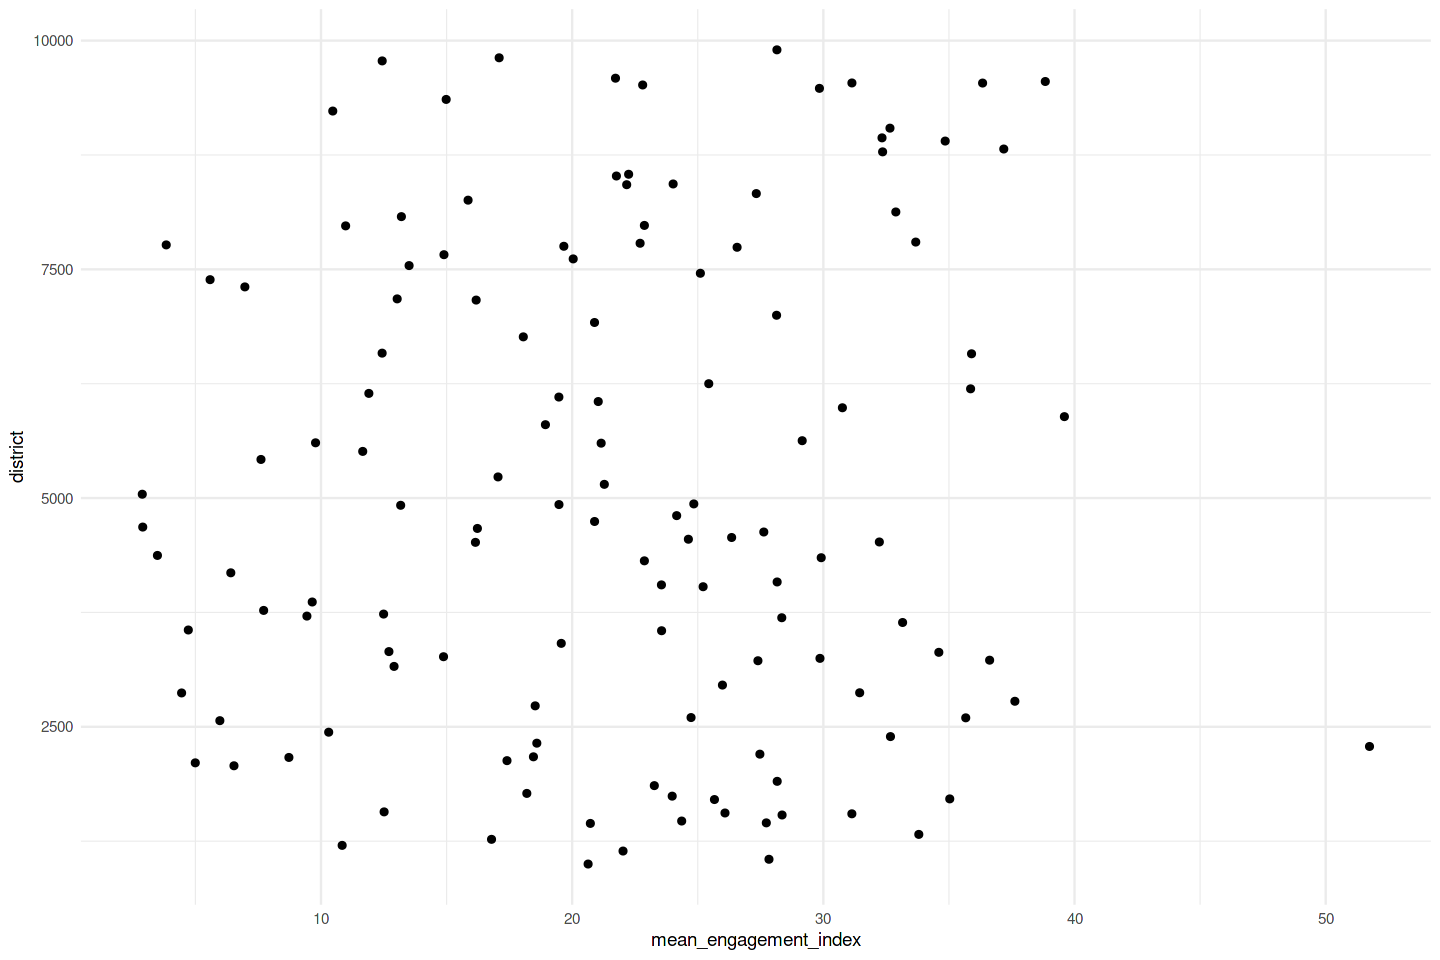

In [ ]:
engagement_district_new <- na.omit(engagement_district)
library(ggplot2)
ggplot(aes(mean_engagement_index, district), data=engagement_district_new) +
  geom_point()

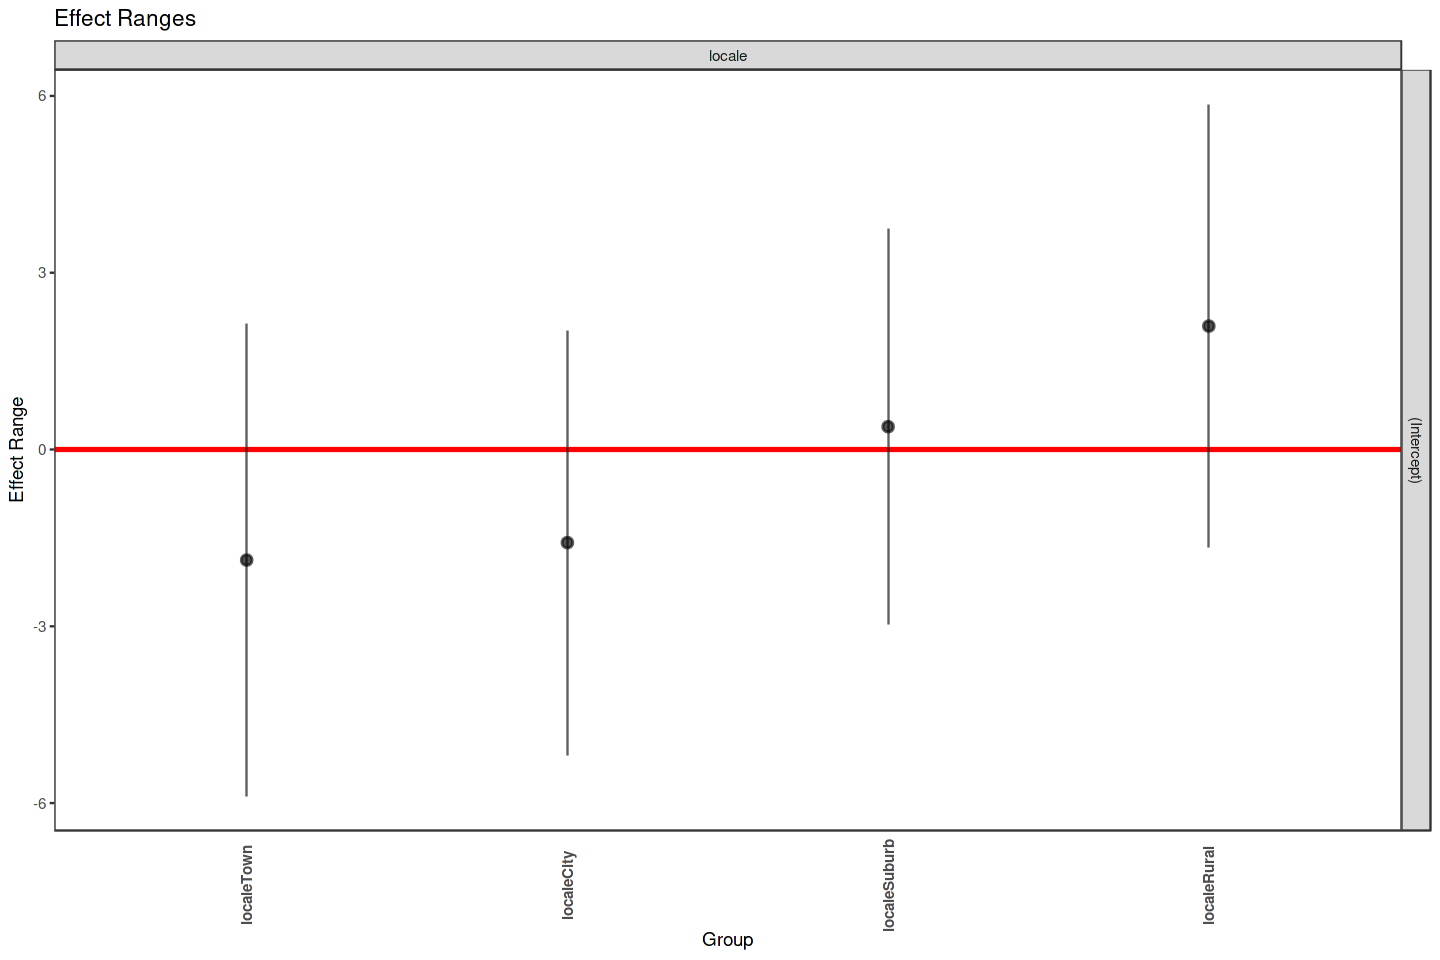

In [ ]:
m1 <- lmer(mean_engagement_index ~ 1 + (1|locale), data=engagement_district_new)
p1 <- plotREsim(REsim(m1), labs=TRUE)
p1

In [ ]:
ranef(m1)
fixef(m1)
confint(m1)

$locale
       (Intercept)
City    -1.2380990
Rural    2.4039842
Suburb   0.6795132
Town    -1.8453984

with conditional variances for “locale” 

(Intercept) 
   21.09363

Computing profile confidence intervals ...



2.5 %     97.5 %   
.sig01       0.000000  6.610198
.sigma       8.487288 10.910778
(Intercept) 17.354124 24.373245

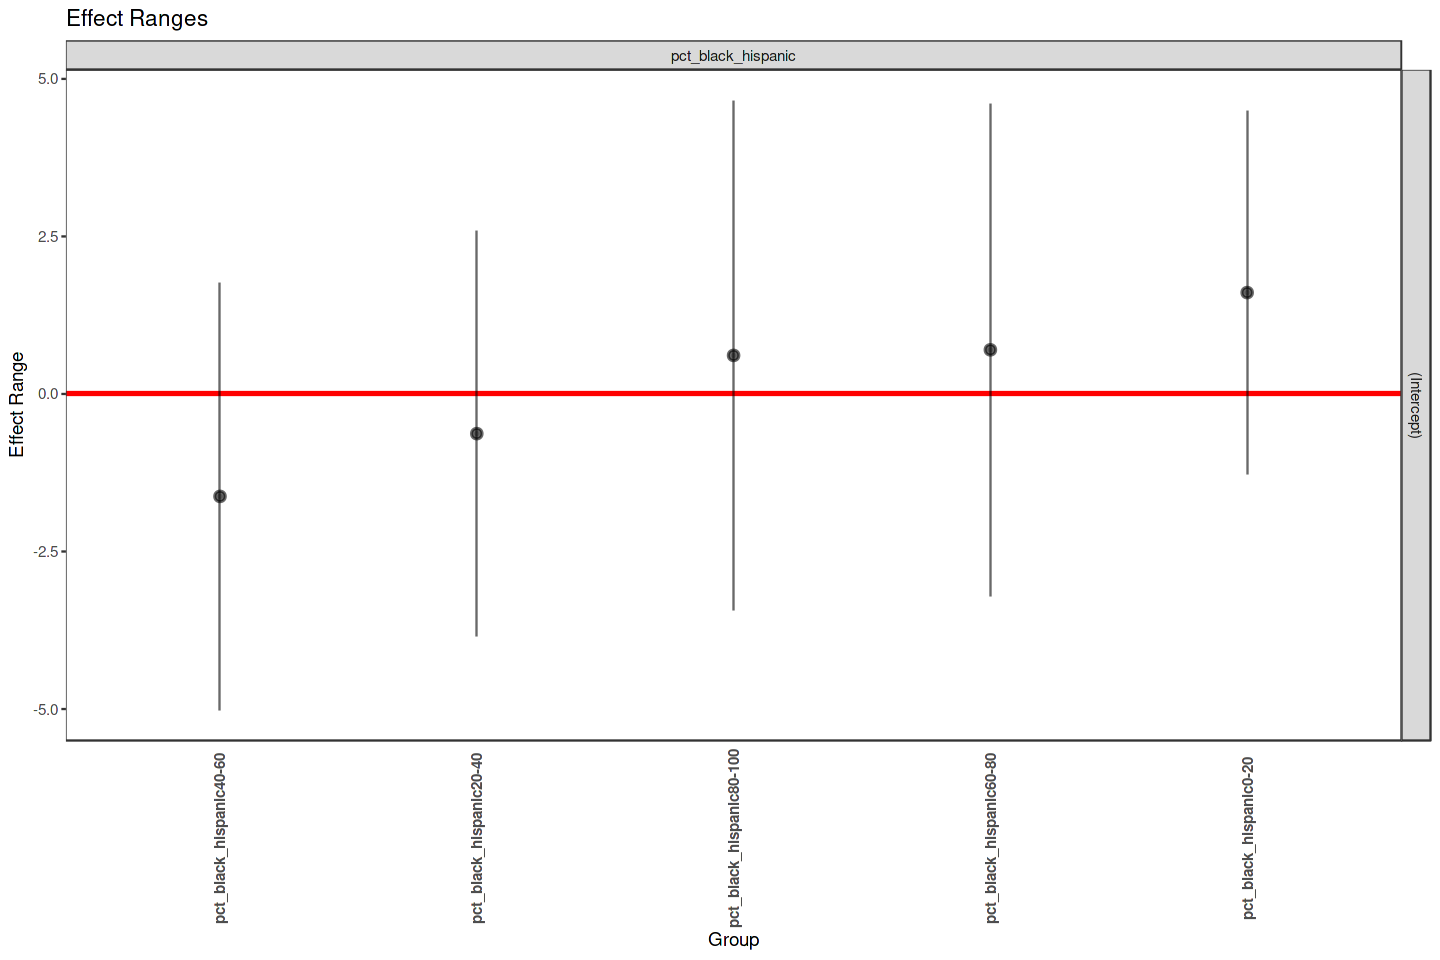

In [ ]:
m2 <- lmer(mean_engagement_index ~ 1 + (1|pct_black_hispanic), data=engagement_district_new)
p2 <- plotREsim(REsim(m2), labs=TRUE)
p2

In [ ]:
ranef(m2)
fixef(m2)
confint(m2)

$pct_black_hispanic
       (Intercept)
0-20     1.5136782
20-40   -0.8861434
40-60   -1.7393749
60-80    0.4500014
80-100   0.6618387

with conditional variances for “pct_black_hispanic” 

(Intercept) 
   20.91326

Computing profile confidence intervals ...



2.5 %     97.5 %   
.sig01       0.000000  5.578454
.sigma       8.488308 10.850402
(Intercept) 17.820431 23.881805

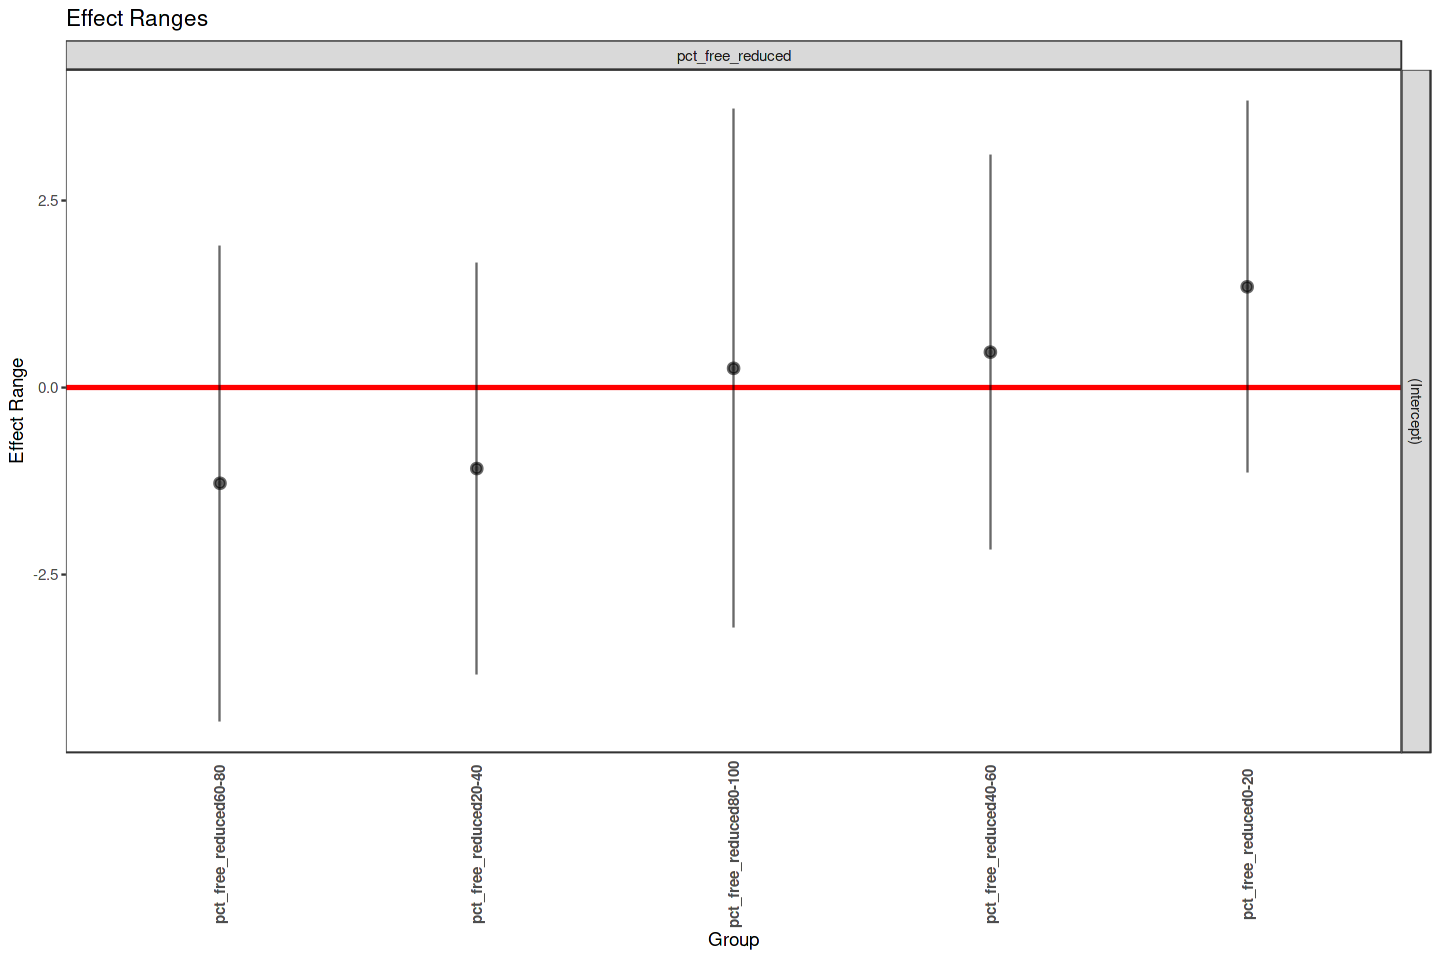

In [ ]:
m3 <- lmer(mean_engagement_index ~ 1 + (1|pct_free_reduced), data=engagement_district_new)
p3 <- plotREsim(REsim(m3), labs=TRUE)
p3

In [ ]:
ranef(m3)
fixef(m3)
confint(m3)

$pct_free_reduced
       (Intercept)
0-20     1.5547220
20-40   -1.2395768
40-60    0.4528722
60-80   -1.0828696
80-100   0.3148522

with conditional variances for “pct_free_reduced” 

(Intercept) 
   21.50728

Computing profile confidence intervals ...



2.5 %     97.5 %   
.sig01       0.000000  4.906906
.sigma       8.489439 10.849694
(Intercept) 18.792954 24.127441

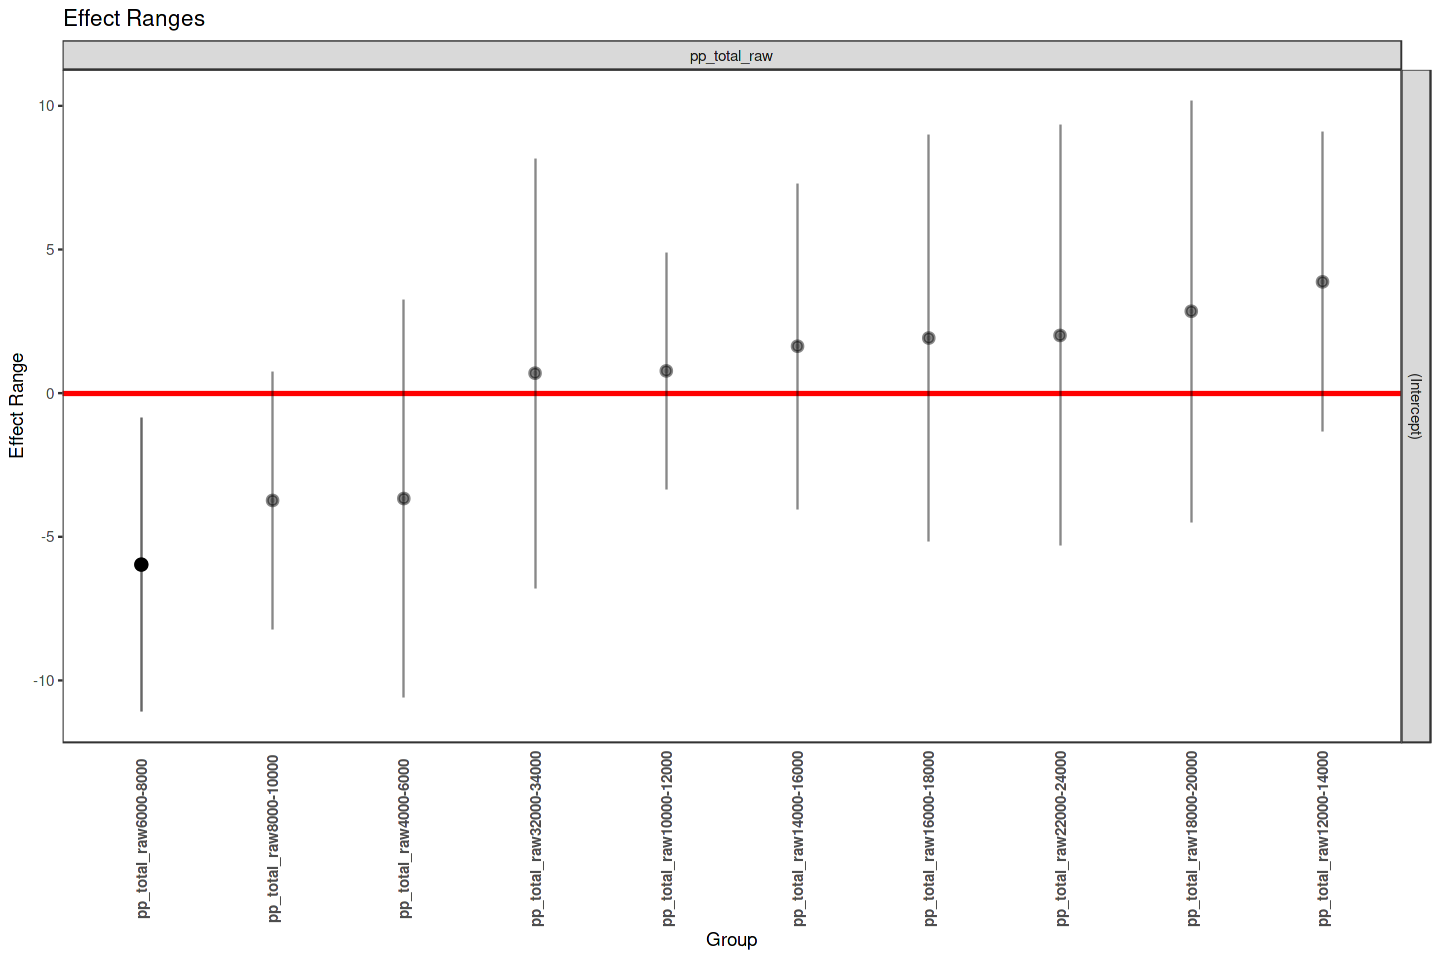

In [ ]:
m4 <- lmer(mean_engagement_index ~ 1 + (1|pp_total_raw), data=engagement_district_new)
p4 <- plotREsim(REsim(m4), labs=TRUE)
p4

In [ ]:
ranef(m4)
fixef(m4)
confint(m4)

$pp_total_raw
            (Intercept)
10000-12000   0.8105160
12000-14000   4.0210520
14000-16000   1.1855311
16000-18000   1.5445826
18000-20000   2.8408906
22000-24000   2.2747114
32000-34000   0.4457212
4000-6000    -3.1426338
6000-8000    -6.0939084
8000-10000   -3.8864627

with conditional variances for “pp_total_raw” 

(Intercept) 
   22.08911

Computing profile confidence intervals ...



2.5 %     97.5 %   
.sig01       1.478815  8.634395
.sigma       8.023007 10.298125
(Intercept) 18.292184 26.241207

In [ ]:
summary(m1)
rand(m1)
summary(m2)
rand(m2)
summary(m3)
rand(m3)
summary(m4)
rand(m4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_engagement_index ~ 1 + (1 | locale)
   Data: engagement_district_new

REML criterion at convergence: 970.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.97946 -0.72861 -0.04108  0.68322  3.14397 

Random effects:
 Groups   Name        Variance Std.Dev.
 locale   (Intercept)  6.185   2.487   
 Residual             90.876   9.533   
Number of obs: 132, groups:  locale, 4

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)   
(Intercept)   21.094      1.585  1.996   13.31  0.00564 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

npar logLik    AIC      LRT      Df Pr(>Chisq)
<none>       3    -485.1573 976.3146       NA NA        NA 
(1 | locale) 2    -485.7298 975.4596 1.145055  1 0.2845868

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_engagement_index ~ 1 + (1 | pct_black_hispanic)
   Data: engagement_district_new

REML criterion at convergence: 970

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.98355 -0.71257  0.04336  0.72168  3.07058 

Random effects:
 Groups             Name        Variance Std.Dev.
 pct_black_hispanic (Intercept)  4.203   2.050   
 Residual                       91.160   9.548   
Number of obs: 132, groups:  pct_black_hispanic, 5

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   20.913      1.403  3.188   14.91 0.000468 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

npar logLik    AIC      LRT      Df Pr(>Chisq)
<none>                   3    -485.0156 976.0312       NA NA        NA 
(1 | pct_black_hispanic) 2    -485.7298 975.4596 1.428409  1 0.2320243

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_engagement_index ~ 1 + (1 | pct_free_reduced)
   Data: engagement_district_new

REML criterion at convergence: 970.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.04935 -0.74579  0.09429  0.71506  3.11838 

Random effects:
 Groups           Name        Variance Std.Dev.
 pct_free_reduced (Intercept)  3.283   1.812   
 Residual                     91.224   9.551   
Number of obs: 132, groups:  pct_free_reduced, 5

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   21.507      1.230  3.358   17.49 0.000204 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

npar logLik    AIC      LRT      Df Pr(>Chisq)
<none>                 3    -485.1064 976.2128       NA NA        NA 
(1 | pct_free_reduced) 2    -485.7298 975.4596 1.246801  1 0.2641644

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_engagement_index ~ 1 + (1 | pp_total_raw)
   Data: engagement_district_new

REML criterion at convergence: 962.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2270 -0.6476 -0.0354  0.6973  2.8349 

Random effects:
 Groups       Name        Variance Std.Dev.
 pp_total_raw (Intercept) 19.97    4.468   
 Residual                 81.76    9.042   
Number of obs: 132, groups:  pp_total_raw, 10

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   22.089      1.907  7.048   11.58 7.65e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

npar logLik    AIC      LRT      Df Pr(>Chisq) 
<none>             3    -481.1452 968.2904       NA NA          NA
(1 | pp_total_raw) 2    -485.7298 975.4596 9.169236  1 0.002461173